<div class="alert alert-info alertinfo" style="margin-top: 0px">
<h1>  Titanic  - Classification models </h1>
</div>

<div class="alert-success" style="margin-top: 0px">
<h1> Imports </h1>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# basic
import pandas as pd
import numpy as np

import data_explorer as de

# preprocessing
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn import model_selection
from sklearn.model_selection import train_test_split

# accuracy metrics
from sklearn.metrics import f1_score
import time, datetime

# classification models
import classification_modeller as cm
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
import catboost
from catboost import CatBoostClassifier, Pool, cv

# visualition
from yellowbrick.target import ClassBalance

<div class="alert-success" style="margin-top: 0px">
<h1> Data set </h1>
</div>

In [2]:
df = pd.read_csv('train.csv')
evaluation_df = pd.read_csv('test.csv')
target = 'Survived'
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Separate target vs features
target = 'Survived'
y = df.loc[:, target]
classes = ["Not survived", "survived"]

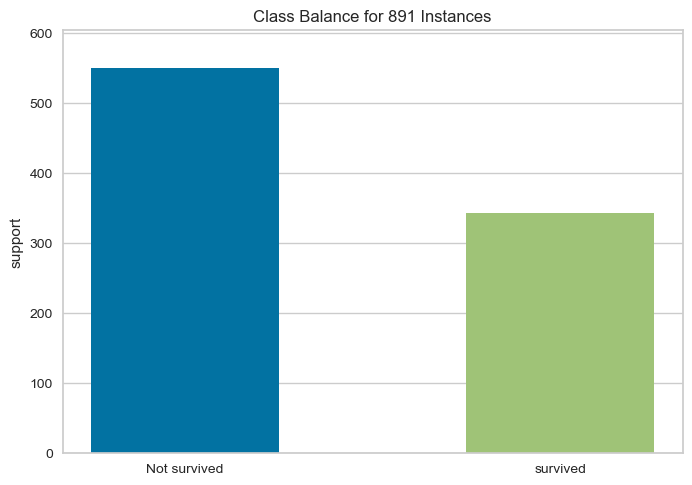

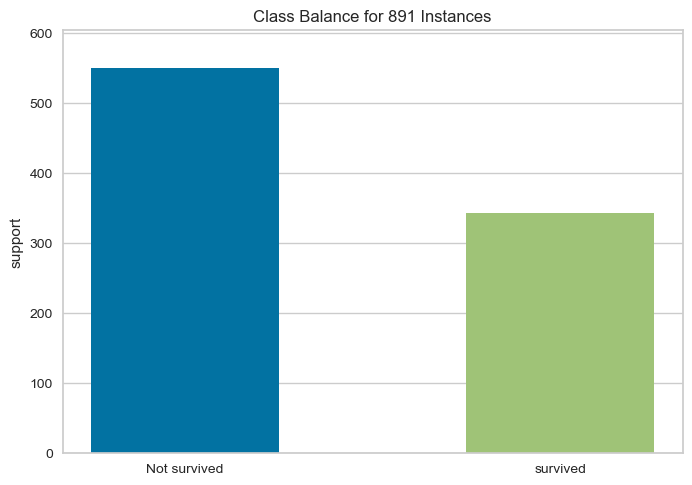

There are 891 records in this data set
There are 891 records in this data set


In [4]:
visualizer = ClassBalance(labels=classes)
visualizer.fit(y) 
visualizer.show() 

print(f'There are {y.shape[0]} records in this data set')

<div class="alert-success" style="margin-top: 0px">
<h1> Train test split with oversampling </h1>
    to combat class imballance
</div>

In [5]:
X = df.copy()
y = df.loc[:, target]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# separate minority and majority classes
died = X[X.Survived==0]
survived = X[X.Survived==1]

# oversample minority
oversampled = resample(survived,
          replace=True,        # sample with replacement
          n_samples=len(died), # match number in majority class
          random_state=0)      # reproducible results

# combine majority and oversampled minority
oversampled = pd.concat([died, oversampled])

# replace training set with oversampled
y_train = oversampled.Survived
X_train = oversampled.drop(target, axis=1)

<div class="alert-success" style="margin-top: 0px">
<h1> Feature engineering </h1>
    Transformations chosen in the previous part (part 1 - exploratory analysis)
</div>

In [6]:
def engineer_title(name: str):
    '''
    function engineers feature 'Title' from name
    
    Args:
        name: str
        
    Returns:
        title: str
    '''
    x = name.rsplit(",")
    title = x[1].strip().split(".")[0]
    return title

def clean_titles(old_title: str):
    '''
    Combines some titles together in order to reduce single cases (noise)
    
    Args:
        old_title: str
        
    Returns:
        new_title: str
    '''
    if old_title in ['Capt', 'Don', 'Jonkheer', 'Rev']:
        new_title = 'On_duty'
    elif old_title in ['Lady', 'Sir', 'the Countess','Dona','Col', 'Dr', 'Major','Mlle', 'Mme', 'Ms']:
        new_title = 'Rare'        
    else:
        new_title = old_title
    return new_title

def engineer_cabin(cabin: str):
    '''
    function engineers feature 'Has_cabin' from Cabin
    if Cabin is missing, has_cabin = 0, else 1
    
    Args:
        cabin: str
        
    Returns:
        has_cabin: int
    '''
    if cabin == cabin:
        has_cabin = 1
    else:
        has_cabin = 0
    return has_cabin

def transform_3(df):
    df.drop(['PassengerId'], axis = 1, inplace = True)
    df['Title'] = df['Name'].apply(lambda x: engineer_title(x))
    df['Title'] = df['Title'].apply(lambda x: clean_titles(x))
    df['Has_Cabin'] = df['Cabin'].apply(lambda x: engineer_cabin(x))
    df = df[['Ticket', 'Title', 'Sex', 'Pclass', 'Has_Cabin']]
    return df

In [7]:
X_train = transform_3(X_train)
X_test = transform_3(X_test)
evaluation_set = transform_3(evaluation_df)
X_train.head()

,Ticket,Title,Sex,Pclass,Has_Cabin
0,A/5 21171,Mr,male,3,0
4,373450,Mr,male,3,0
5,330877,Mr,male,3,0
6,17463,Mr,male,1,1
7,349909,Master,male,3,0


,Ticket,Title,Sex,Pclass,Has_Cabin
0,A/5 21171,Mr,male,3,0
4,373450,Mr,male,3,0
5,330877,Mr,male,3,0
6,17463,Mr,male,1,1
7,349909,Master,male,3,0


<div class="alert-success" style="margin-top: 0px">
<h1> 1 Hot encoding </h1>
</div>

In [8]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
evaluation_set = pd.get_dummies(evaluation_df)

<div class="alert-success" style="margin-top: 0px">
<h1> Aligning </h1>
</div>

In [9]:
# Aligning 
# Due to 1 Hot encoding, some columns may be missing as some values may not be present
# we need to make sure we have the same columns

X_train, evaluation_set = X_train.align(evaluation_set, join='left', axis=1) 
X_train, X_test = X_train.align(X_test, join='left', axis=1) 

X_test.replace(np.nan,0,inplace=True)
evaluation_set.replace(np.nan,0,inplace=True)

In [10]:
X_train.head()

,Pclass,Has_Cabin,Ticket_110152,Ticket_110413,Ticket_110465,Ticket_110564,Ticket_111240,Ticket_111320,Ticket_111361,Ticket_111369,...,Ticket_W/C 14208,Ticket_WE/P 5735,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_On_duty,Title_Rare,Sex_female,Sex_male
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
6,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
7,3,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


,Pclass,Has_Cabin,Ticket_110152,Ticket_110413,Ticket_110465,Ticket_110564,Ticket_111240,Ticket_111320,Ticket_111361,Ticket_111369,...,Ticket_W/C 14208,Ticket_WE/P 5735,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_On_duty,Title_Rare,Sex_female,Sex_male
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
6,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
7,3,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


<div class="alert-success" style="margin-top: 0px">
<h1> Classification Models </h1>
</div>

# Decision Tree Classifier

In [11]:
algo = DecisionTreeClassifier()
model_1, y_pred, acc_train, acc_test, acc_cv = cm.fit_classification_algo(algo, X_train, X_test, y_train, y_test,10)
# feature_importance(model_1, X_train)

Training Accuracy: 99.36
Testing Accuracy: 97.93
Accuracy CV 10 Fold: 79.97
Running Time: 0:00:00.022650
Training Accuracy: 99.36
Testing Accuracy: 97.93
Accuracy CV 10 Fold: 79.97
Running Time: 0:00:00.022650


# Logistic Regression

In [12]:
algo = LogisticRegression()
model_2, y_pred, acc_train, acc_test, acc_cv = cm.fit_classification_algo(algo, X_train, X_test, y_train, y_test,10)

Training Accuracy: 99.18
Testing Accuracy: 97.93
Accuracy CV 10 Fold: 88.11
Running Time: 0:00:00.067052
Training Accuracy: 99.18
Testing Accuracy: 97.93
Accuracy CV 10 Fold: 88.11
Running Time: 0:00:00.067052


# Stochastic Gradient Descent Classifier

In [13]:
algo = SGDClassifier()
model_3, y_pred, acc_train, acc_test, acc_cv = cm.fit_classification_algo(algo, X_train, X_test, y_train, y_test,10)

Training Accuracy: 99.18
Testing Accuracy: 97.22
Accuracy CV 10 Fold: 92.91
Running Time: 0:00:00.027006
Training Accuracy: 99.18
Testing Accuracy: 97.22
Accuracy CV 10 Fold: 92.91
Running Time: 0:00:00.027006


# Linear Support Vector Machine

In [14]:
algo = LinearSVC()
model_4, y_pred, acc_train, acc_test, acc_cv = cm.fit_classification_algo(algo, X_train, X_test, y_train, y_test,10)

Training Accuracy: 99.18
Testing Accuracy: 97.22
Accuracy CV 10 Fold: 93.9
Running Time: 0:00:00.527118
Training Accuracy: 99.18
Testing Accuracy: 97.22
Accuracy CV 10 Fold: 93.9
Running Time: 0:00:00.527118


# Gaussian Naive Bayes 

In [15]:
# not suitable for imbalanced dataset but we ballanced it out by oversampling
algo = GaussianNB()
model_5, y_pred, acc_train, acc_test, acc_cv = cm.fit_classification_algo(algo, X_train, X_test, y_train, y_test,10)

Training Accuracy: 96.15
Testing Accuracy: 97.3
Accuracy CV 10 Fold: 77.11
Running Time: 0:00:00.013004
Training Accuracy: 96.15
Testing Accuracy: 97.3
Accuracy CV 10 Fold: 77.11
Running Time: 0:00:00.013004


# K-Neighbors Classifier 

In [16]:
# not suitable for imbalanced dataset but we ballanced it out by oversampling
algo = KNeighborsClassifier()
model_6, y_pred, acc_train, acc_test, acc_cv = cm.fit_classification_algo(algo, X_train, X_test, y_train, y_test,10)

Training Accuracy: 71.18
Testing Accuracy: 62.39
Accuracy CV 10 Fold: 84.84
Running Time: 0:00:00.002008
Training Accuracy: 71.18
Testing Accuracy: 62.39
Accuracy CV 10 Fold: 84.84
Running Time: 0:00:00.002008


# Gradient Boosting Classifier

In [17]:
# not suitable for imbalanced dataset but we ballanced it out by oversampling
algo = GradientBoostingClassifier()
model_7, y_pred, acc_train, acc_test, acc_cv = cm.fit_classification_algo(algo, X_train, X_test, y_train, y_test,10)

Training Accuracy: 90.27
Testing Accuracy: 86.09
Accuracy CV 10 Fold: 86.08
Running Time: 0:00:00.594414
Training Accuracy: 90.27
Testing Accuracy: 86.09
Accuracy CV 10 Fold: 86.08
Running Time: 0:00:00.594414


# Cat Boost

In [18]:
features = list(X_train.columns)
cat_features = de.get_cat_features(X_train)

model_8 = CatBoostClassifier(task_type = 'GPU', iterations = 1000, eval_metric = 'F1')
model_8.fit(X_train, y_train, cat_features = cat_features, plot = True, eval_set = (X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.070644
Learning rate set to 0.070644
0:	learn: 0.7970343	test: 0.7682119	best: 0.7682119 (0)	total: 25.9ms	remaining: 25.8s
1:	learn: 0.7910028	test: 0.7600000	best: 0.7682119 (0)	total: 51.2ms	remaining: 25.5s
2:	learn: 0.7914339	test: 0.7682119	best: 0.7682119 (0)	total: 76.6ms	remaining: 25.5s
3:	learn: 0.7996289	test: 0.7682119	best: 0.7682119 (0)	total: 102ms	remaining: 25.5s
4:	learn: 0.7973978	test: 0.7682119	best: 0.7682119 (0)	total: 132ms	remaining: 26.3s
5:	learn: 0.7914736	test: 0.7631579	best: 0.7682119 (0)	total: 177ms	remaining: 29.4s
6:	learn: 0.7958993	test: 0.7733333	best: 0.7733333 (6)	total: 224ms	remaining: 31.8s
0:	learn: 0.7970343	test: 0.7682119	best: 0.7682119 (0)	total: 25.9ms	remaining: 25.8s
1:	learn: 0.7910028	test: 0.7600000	best: 0.7682119 (0)	total: 51.2ms	remaining: 25.5s
2:	learn: 0.7914339	test: 0.7682119	best: 0.7682119 (0)	total: 76.6ms	remaining: 25.5s
3:	learn: 0.7996289	test: 0.7682119	best: 0.7682119 (0)	total: 102ms	remai

45:	learn: 0.8621324	test: 0.8133333	best: 0.8133333 (40)	total: 1.33s	remaining: 27.6s
46:	learn: 0.8621324	test: 0.8133333	best: 0.8133333 (40)	total: 1.35s	remaining: 27.5s
47:	learn: 0.8621324	test: 0.8133333	best: 0.8133333 (40)	total: 1.38s	remaining: 27.4s
48:	learn: 0.8621324	test: 0.8133333	best: 0.8133333 (40)	total: 1.41s	remaining: 27.3s
49:	learn: 0.8621324	test: 0.8133333	best: 0.8133333 (40)	total: 1.43s	remaining: 27.2s
50:	learn: 0.8621324	test: 0.8133333	best: 0.8133333 (40)	total: 1.46s	remaining: 27.1s
51:	learn: 0.8621324	test: 0.8133333	best: 0.8133333 (40)	total: 1.48s	remaining: 27s
52:	learn: 0.8621324	test: 0.8133333	best: 0.8133333 (40)	total: 1.51s	remaining: 27s
53:	learn: 0.8621324	test: 0.8133333	best: 0.8133333 (40)	total: 1.53s	remaining: 26.9s
54:	learn: 0.8621324	test: 0.8133333	best: 0.8133333 (40)	total: 1.56s	remaining: 26.8s
55:	learn: 0.8621324	test: 0.8133333	best: 0.8133333 (40)	total: 1.58s	remaining: 26.7s
56:	learn: 0.8621324	test: 0.8133333

94:	learn: 0.8925319	test: 0.8378378	best: 0.8378378 (90)	total: 2.6s	remaining: 24.8s
95:	learn: 0.8925319	test: 0.8378378	best: 0.8378378 (90)	total: 2.63s	remaining: 24.8s
96:	learn: 0.8925319	test: 0.8378378	best: 0.8378378 (90)	total: 2.65s	remaining: 24.7s
97:	learn: 0.8925319	test: 0.8378378	best: 0.8378378 (90)	total: 2.68s	remaining: 24.6s
98:	learn: 0.8925319	test: 0.8378378	best: 0.8378378 (90)	total: 2.7s	remaining: 24.6s
99:	learn: 0.8925319	test: 0.8378378	best: 0.8378378 (90)	total: 2.73s	remaining: 24.5s
100:	learn: 0.8925319	test: 0.8378378	best: 0.8378378 (90)	total: 2.75s	remaining: 24.5s
101:	learn: 0.8925319	test: 0.8378378	best: 0.8378378 (90)	total: 2.77s	remaining: 24.4s
102:	learn: 0.8933455	test: 0.8435374	best: 0.8435374 (102)	total: 2.8s	remaining: 24.4s
103:	learn: 0.8961749	test: 0.8435374	best: 0.8435374 (102)	total: 2.82s	remaining: 24.3s
104:	learn: 0.8981818	test: 0.8513514	best: 0.8513514 (104)	total: 2.85s	remaining: 24.3s
105:	learn: 0.8981818	test:

143:	learn: 0.9169675	test: 0.9054054	best: 0.9127517 (139)	total: 3.88s	remaining: 23.1s
144:	learn: 0.9208633	test: 0.9127517	best: 0.9127517 (139)	total: 3.91s	remaining: 23.1s
145:	learn: 0.9208633	test: 0.9127517	best: 0.9127517 (139)	total: 3.94s	remaining: 23s
146:	learn: 0.9208633	test: 0.9127517	best: 0.9127517 (139)	total: 3.96s	remaining: 23s
147:	learn: 0.9208633	test: 0.9127517	best: 0.9127517 (139)	total: 3.99s	remaining: 23s
148:	learn: 0.9208633	test: 0.9127517	best: 0.9127517 (139)	total: 4.01s	remaining: 22.9s
149:	learn: 0.9208633	test: 0.9127517	best: 0.9127517 (139)	total: 4.04s	remaining: 22.9s
150:	learn: 0.9208633	test: 0.9127517	best: 0.9127517 (139)	total: 4.06s	remaining: 22.8s
151:	learn: 0.9208633	test: 0.9127517	best: 0.9127517 (139)	total: 4.09s	remaining: 22.8s
152:	learn: 0.9208633	test: 0.9127517	best: 0.9127517 (139)	total: 4.11s	remaining: 22.8s
153:	learn: 0.9208633	test: 0.9127517	best: 0.9127517 (139)	total: 4.14s	remaining: 22.7s
154:	learn: 0.92

193:	learn: 0.9263914	test: 0.9127517	best: 0.9127517 (139)	total: 5.15s	remaining: 21.4s
194:	learn: 0.9263914	test: 0.9127517	best: 0.9127517 (139)	total: 5.17s	remaining: 21.4s
195:	learn: 0.9263914	test: 0.9127517	best: 0.9127517 (139)	total: 5.2s	remaining: 21.3s
196:	learn: 0.9273543	test: 0.9127517	best: 0.9127517 (139)	total: 5.22s	remaining: 21.3s
197:	learn: 0.9273543	test: 0.9127517	best: 0.9127517 (139)	total: 5.25s	remaining: 21.3s
198:	learn: 0.9281867	test: 0.9189189	best: 0.9189189 (198)	total: 5.27s	remaining: 21.2s
199:	learn: 0.9281867	test: 0.9189189	best: 0.9189189 (198)	total: 5.29s	remaining: 21.2s
200:	learn: 0.9281867	test: 0.9189189	best: 0.9189189 (198)	total: 5.32s	remaining: 21.1s
201:	learn: 0.9281867	test: 0.9189189	best: 0.9189189 (198)	total: 5.34s	remaining: 21.1s
193:	learn: 0.9263914	test: 0.9127517	best: 0.9127517 (139)	total: 5.15s	remaining: 21.4s
194:	learn: 0.9263914	test: 0.9127517	best: 0.9127517 (139)	total: 5.17s	remaining: 21.4s
195:	learn:

236:	learn: 0.9301075	test: 0.9261745	best: 0.9261745 (221)	total: 6.24s	remaining: 20.1s
237:	learn: 0.9301075	test: 0.9261745	best: 0.9261745 (221)	total: 6.26s	remaining: 20s
238:	learn: 0.9309417	test: 0.9261745	best: 0.9261745 (221)	total: 6.28s	remaining: 20s
239:	learn: 0.9309417	test: 0.9261745	best: 0.9261745 (221)	total: 6.31s	remaining: 20s
240:	learn: 0.9318996	test: 0.9261745	best: 0.9261745 (221)	total: 6.33s	remaining: 19.9s
241:	learn: 0.9318996	test: 0.9261745	best: 0.9261745 (221)	total: 6.36s	remaining: 19.9s
242:	learn: 0.9318996	test: 0.9261745	best: 0.9261745 (221)	total: 6.38s	remaining: 19.9s
243:	learn: 0.9318996	test: 0.9261745	best: 0.9261745 (221)	total: 6.41s	remaining: 19.8s
244:	learn: 0.9318996	test: 0.9261745	best: 0.9261745 (221)	total: 6.43s	remaining: 19.8s
245:	learn: 0.9318996	test: 0.9261745	best: 0.9261745 (221)	total: 6.46s	remaining: 19.8s
246:	learn: 0.9318996	test: 0.9261745	best: 0.9261745 (221)	total: 6.48s	remaining: 19.8s
247:	learn: 0.93

288:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 7.58s	remaining: 18.7s
289:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 7.61s	remaining: 18.6s
290:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 7.63s	remaining: 18.6s
291:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 7.66s	remaining: 18.6s
292:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 7.7s	remaining: 18.6s
293:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 7.72s	remaining: 18.5s
294:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 7.75s	remaining: 18.5s
295:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 7.77s	remaining: 18.5s
288:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 7.58s	remaining: 18.7s
289:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 7.61s	remaining: 18.6s
290:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 7.63s	remaining: 18.6s
291:	learn:

332:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 8.68s	remaining: 17.4s
333:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 8.71s	remaining: 17.4s
334:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 8.73s	remaining: 17.3s
335:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 8.76s	remaining: 17.3s
336:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 8.78s	remaining: 17.3s
337:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 8.8s	remaining: 17.2s
338:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 8.83s	remaining: 17.2s
339:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 8.85s	remaining: 17.2s
340:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 8.88s	remaining: 17.2s
341:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 8.9s	remaining: 17.1s
342:	learn: 0.9336918	test: 0.9261745	best: 0.9261745 (221)	total: 8.93s	remaining: 17.1s
343:	learn: 

383:	learn: 0.9364369	test: 0.9261745	best: 0.9261745 (221)	total: 9.98s	remaining: 16s
384:	learn: 0.9364369	test: 0.9261745	best: 0.9261745 (221)	total: 10s	remaining: 16s
385:	learn: 0.9364369	test: 0.9261745	best: 0.9261745 (221)	total: 10s	remaining: 16s
386:	learn: 0.9364369	test: 0.9261745	best: 0.9261745 (221)	total: 10.1s	remaining: 15.9s
387:	learn: 0.9364369	test: 0.9261745	best: 0.9261745 (221)	total: 10.1s	remaining: 15.9s
388:	learn: 0.9364369	test: 0.9261745	best: 0.9261745 (221)	total: 10.1s	remaining: 15.9s
389:	learn: 0.9372760	test: 0.9261745	best: 0.9261745 (221)	total: 10.1s	remaining: 15.8s
390:	learn: 0.9372760	test: 0.9261745	best: 0.9261745 (221)	total: 10.2s	remaining: 15.8s
391:	learn: 0.9372760	test: 0.9261745	best: 0.9261745 (221)	total: 10.2s	remaining: 15.8s
383:	learn: 0.9364369	test: 0.9261745	best: 0.9261745 (221)	total: 9.98s	remaining: 16s
384:	learn: 0.9364369	test: 0.9261745	best: 0.9261745 (221)	total: 10s	remaining: 16s
385:	learn: 0.9364369	test

427:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 11.1s	remaining: 14.8s
428:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 11.1s	remaining: 14.8s
429:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 11.1s	remaining: 14.8s
430:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 11.2s	remaining: 14.7s
431:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 11.2s	remaining: 14.7s
432:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 11.2s	remaining: 14.7s
433:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 11.2s	remaining: 14.7s
434:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 11.3s	remaining: 14.6s
435:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 11.3s	remaining: 14.6s
436:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 11.3s	remaining: 14.6s
437:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 11.3s	remaining: 14.5s
438:	learn

480:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 12.4s	remaining: 13.4s
481:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 12.4s	remaining: 13.3s
482:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 12.4s	remaining: 13.3s
483:	learn: 0.9401251	test: 0.9261745	best: 0.9261745 (221)	total: 12.5s	remaining: 13.3s
484:	learn: 0.9401251	test: 0.9261745	best: 0.9261745 (221)	total: 12.5s	remaining: 13.3s
485:	learn: 0.9401251	test: 0.9261745	best: 0.9261745 (221)	total: 12.5s	remaining: 13.2s
486:	learn: 0.9401251	test: 0.9261745	best: 0.9261745 (221)	total: 12.5s	remaining: 13.2s
487:	learn: 0.9401251	test: 0.9261745	best: 0.9261745 (221)	total: 12.6s	remaining: 13.2s
488:	learn: 0.9401251	test: 0.9261745	best: 0.9261745 (221)	total: 12.6s	remaining: 13.1s
480:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 12.4s	remaining: 13.4s
481:	learn: 0.9382274	test: 0.9261745	best: 0.9261745 (221)	total: 12.4s	remaining: 13.3s
482:	learn

522:	learn: 0.9410714	test: 0.9261745	best: 0.9261745 (221)	total: 13.5s	remaining: 12.3s
523:	learn: 0.9410714	test: 0.9261745	best: 0.9261745 (221)	total: 13.5s	remaining: 12.2s
524:	learn: 0.9410714	test: 0.9261745	best: 0.9261745 (221)	total: 13.5s	remaining: 12.2s
525:	learn: 0.9410714	test: 0.9261745	best: 0.9261745 (221)	total: 13.5s	remaining: 12.2s
526:	learn: 0.9410714	test: 0.9261745	best: 0.9261745 (221)	total: 13.6s	remaining: 12.2s
527:	learn: 0.9410714	test: 0.9261745	best: 0.9261745 (221)	total: 13.6s	remaining: 12.1s
528:	learn: 0.9410714	test: 0.9261745	best: 0.9261745 (221)	total: 13.6s	remaining: 12.1s
529:	learn: 0.9410714	test: 0.9261745	best: 0.9261745 (221)	total: 13.6s	remaining: 12.1s
530:	learn: 0.9410714	test: 0.9261745	best: 0.9261745 (221)	total: 13.7s	remaining: 12.1s
531:	learn: 0.9410714	test: 0.9261745	best: 0.9261745 (221)	total: 13.7s	remaining: 12s
532:	learn: 0.9410714	test: 0.9261745	best: 0.9261745 (221)	total: 13.7s	remaining: 12s
533:	learn: 0.

572:	learn: 0.9409660	test: 0.9261745	best: 0.9261745 (221)	total: 14.8s	remaining: 11s
573:	learn: 0.9409660	test: 0.9261745	best: 0.9261745 (221)	total: 14.8s	remaining: 11s
574:	learn: 0.9409660	test: 0.9261745	best: 0.9261745 (221)	total: 14.8s	remaining: 11s
575:	learn: 0.9409660	test: 0.9261745	best: 0.9261745 (221)	total: 14.9s	remaining: 10.9s
576:	learn: 0.9409660	test: 0.9261745	best: 0.9261745 (221)	total: 14.9s	remaining: 10.9s
577:	learn: 0.9409660	test: 0.9261745	best: 0.9261745 (221)	total: 14.9s	remaining: 10.9s
578:	learn: 0.9409660	test: 0.9261745	best: 0.9261745 (221)	total: 14.9s	remaining: 10.9s
579:	learn: 0.9409660	test: 0.9261745	best: 0.9261745 (221)	total: 15s	remaining: 10.8s
580:	learn: 0.9409660	test: 0.9261745	best: 0.9261745 (221)	total: 15s	remaining: 10.8s
581:	learn: 0.9419124	test: 0.9261745	best: 0.9261745 (221)	total: 15s	remaining: 10.8s
582:	learn: 0.9419124	test: 0.9261745	best: 0.9261745 (221)	total: 15s	remaining: 10.7s
583:	learn: 0.9419124	te

626:	learn: 0.9452915	test: 0.9387755	best: 0.9387755 (604)	total: 16.1s	remaining: 9.59s
627:	learn: 0.9452915	test: 0.9387755	best: 0.9387755 (604)	total: 16.1s	remaining: 9.56s
628:	learn: 0.9461400	test: 0.9387755	best: 0.9387755 (604)	total: 16.2s	remaining: 9.54s
629:	learn: 0.9461400	test: 0.9387755	best: 0.9387755 (604)	total: 16.2s	remaining: 9.51s
630:	learn: 0.9461400	test: 0.9387755	best: 0.9387755 (604)	total: 16.2s	remaining: 9.48s
631:	learn: 0.9461400	test: 0.9387755	best: 0.9387755 (604)	total: 16.2s	remaining: 9.46s
632:	learn: 0.9461400	test: 0.9387755	best: 0.9387755 (604)	total: 16.3s	remaining: 9.43s
633:	learn: 0.9461400	test: 0.9387755	best: 0.9387755 (604)	total: 16.3s	remaining: 9.4s
634:	learn: 0.9461400	test: 0.9387755	best: 0.9387755 (604)	total: 16.3s	remaining: 9.38s
626:	learn: 0.9452915	test: 0.9387755	best: 0.9387755 (604)	total: 16.1s	remaining: 9.59s
627:	learn: 0.9452915	test: 0.9387755	best: 0.9387755 (604)	total: 16.1s	remaining: 9.56s
628:	learn:

669:	learn: 0.9478417	test: 0.9452055	best: 0.9452055 (635)	total: 17.2s	remaining: 8.47s
670:	learn: 0.9478417	test: 0.9452055	best: 0.9452055 (635)	total: 17.2s	remaining: 8.44s
671:	learn: 0.9478417	test: 0.9452055	best: 0.9452055 (635)	total: 17.2s	remaining: 8.42s
672:	learn: 0.9478417	test: 0.9452055	best: 0.9452055 (635)	total: 17.3s	remaining: 8.39s
673:	learn: 0.9478417	test: 0.9452055	best: 0.9452055 (635)	total: 17.3s	remaining: 8.37s
674:	learn: 0.9478417	test: 0.9452055	best: 0.9452055 (635)	total: 17.3s	remaining: 8.34s
675:	learn: 0.9478417	test: 0.9452055	best: 0.9452055 (635)	total: 17.4s	remaining: 8.32s
676:	learn: 0.9478417	test: 0.9452055	best: 0.9452055 (635)	total: 17.4s	remaining: 8.29s
677:	learn: 0.9478417	test: 0.9452055	best: 0.9452055 (635)	total: 17.4s	remaining: 8.27s
678:	learn: 0.9478417	test: 0.9452055	best: 0.9452055 (635)	total: 17.4s	remaining: 8.24s
679:	learn: 0.9478417	test: 0.9452055	best: 0.9452055 (635)	total: 17.5s	remaining: 8.21s
680:	learn

721:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 18.5s	remaining: 7.13s
722:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 18.5s	remaining: 7.11s
723:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 18.6s	remaining: 7.08s
724:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 18.6s	remaining: 7.05s
725:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 18.6s	remaining: 7.03s
726:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 18.6s	remaining: 7s
727:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 18.7s	remaining: 6.97s
728:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 18.7s	remaining: 6.95s
729:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 18.7s	remaining: 6.92s
721:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 18.5s	remaining: 7.13s
722:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 18.5s	remaining: 7.11s
723:	learn: 0

766:	learn: 0.9477477	test: 0.9452055	best: 0.9452055 (635)	total: 19.6s	remaining: 5.96s
767:	learn: 0.9477477	test: 0.9452055	best: 0.9452055 (635)	total: 19.6s	remaining: 5.93s
768:	learn: 0.9477477	test: 0.9452055	best: 0.9452055 (635)	total: 19.7s	remaining: 5.91s
769:	learn: 0.9477477	test: 0.9452055	best: 0.9452055 (635)	total: 19.7s	remaining: 5.88s
770:	learn: 0.9477477	test: 0.9452055	best: 0.9452055 (635)	total: 19.7s	remaining: 5.86s
771:	learn: 0.9477477	test: 0.9452055	best: 0.9452055 (635)	total: 19.7s	remaining: 5.83s
772:	learn: 0.9477477	test: 0.9452055	best: 0.9452055 (635)	total: 19.8s	remaining: 5.81s
773:	learn: 0.9477477	test: 0.9452055	best: 0.9452055 (635)	total: 19.8s	remaining: 5.78s
774:	learn: 0.9477477	test: 0.9452055	best: 0.9452055 (635)	total: 19.8s	remaining: 5.75s
775:	learn: 0.9477477	test: 0.9452055	best: 0.9452055 (635)	total: 19.8s	remaining: 5.73s
776:	learn: 0.9477477	test: 0.9452055	best: 0.9452055 (635)	total: 19.9s	remaining: 5.7s
777:	learn:

820:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 21s	remaining: 4.57s
821:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 21s	remaining: 4.54s
822:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 21s	remaining: 4.52s
823:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 21s	remaining: 4.49s
824:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 21.1s	remaining: 4.47s
825:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 21.1s	remaining: 4.44s
826:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 21.1s	remaining: 4.42s
827:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 21.1s	remaining: 4.39s
828:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 21.2s	remaining: 4.36s
820:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 21s	remaining: 4.57s
821:	learn: 0.9486949	test: 0.9452055	best: 0.9452055 (635)	total: 21s	remaining: 4.54s
822:	learn: 0.9486949	

863:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 22.1s	remaining: 3.47s
864:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 22.1s	remaining: 3.45s
865:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 22.1s	remaining: 3.42s
866:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 22.1s	remaining: 3.4s
867:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 22.2s	remaining: 3.37s
868:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 22.2s	remaining: 3.35s
869:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 22.2s	remaining: 3.32s
870:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 22.3s	remaining: 3.29s
871:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 22.3s	remaining: 3.27s
872:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 22.3s	remaining: 3.24s
873:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 22.3s	remaining: 3.22s
874:	learn:

912:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 23.4s	remaining: 2.23s
913:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 23.4s	remaining: 2.2s
914:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 23.4s	remaining: 2.17s
915:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 23.4s	remaining: 2.15s
916:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 23.5s	remaining: 2.12s
917:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 23.5s	remaining: 2.1s
918:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 23.5s	remaining: 2.07s
919:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 23.5s	remaining: 2.05s
920:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 23.6s	remaining: 2.02s
921:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 23.6s	remaining: 2s
922:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 23.6s	remaining: 1.97s
923:	learn: 0.9

962:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 24.7s	remaining: 948ms
963:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 24.7s	remaining: 922ms
964:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 24.7s	remaining: 896ms
965:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 24.7s	remaining: 871ms
966:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 24.8s	remaining: 845ms
967:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 24.8s	remaining: 820ms
968:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 24.8s	remaining: 794ms
969:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 24.8s	remaining: 768ms
970:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 24.9s	remaining: 743ms
971:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 24.9s	remaining: 717ms
972:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 24.9s	remaining: 691ms
973:	learn

998:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 25.6s	remaining: 25.6ms
999:	learn: 0.9495495	test: 0.9517241	best: 0.9517241 (844)	total: 25.6s	remaining: 0us
bestTest = 0.9517241379
bestIteration = 844
Shrink model to first 845 iterations.


In [19]:
print('Training Accuracy: ', f1_score(y_train, model_8.predict(X_train)))
print('Testing Accuracy: ', f1_score(y_test, model_8.predict(X_test)))

Training Accuracy:  0.9495495495495496
Testing Accuracy:  0.9517241379310345
Training Accuracy:  0.9495495495495496
Testing Accuracy:  0.9517241379310345


# Cat Boost with CV

In [20]:
# Catboost Algorithm
cat_features = np.where(X_train.dtypes != np.float)[0]
train_pool = Pool(X_train, y_train, cat_features)

model_9 = CatBoostClassifier(iterations = 1000, custom_loss=['Accuracy'],loss_function = 'Logloss')

start_time = time.time()
model_9.fit(train_pool, plot= True)
acc_catboost = round(model_9.score(X_train,y_train),2)

cv_params = model_9.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=False)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

# Catboost metrics

print('----Catboost Metrics----')
print('Accuracy:{}'.format(acc_catboost))
print('Accuracy CV 10-Fold:{}'.format(acc_cv_catboost))
print('Running Time:{}' .format(datetime.timedelta(seconds = catboost_time)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.010722
0:	learn: 0.6868471	total: 40.1ms	remaining: 40s
1:	learn: 0.6809132	total: 65.1ms	remaining: 32.5s
2:	learn: 0.6743178	total: 95.4ms	remaining: 31.7s
3:	learn: 0.6676676	total: 127ms	remaining: 31.5s
4:	learn: 0.6610005	total: 168ms	remaining: 33.4s
Learning rate set to 0.010722
0:	learn: 0.6868471	total: 40.1ms	remaining: 40s
1:	learn: 0.6809132	total: 65.1ms	remaining: 32.5s
2:	learn: 0.6743178	total: 95.4ms	remaining: 31.7s
3:	learn: 0.6676676	total: 127ms	remaining: 31.5s
4:	learn: 0.6610005	total: 168ms	remaining: 33.4s
5:	learn: 0.6553279	total: 201ms	remaining: 33.3s
6:	learn: 0.6491315	total: 231ms	remaining: 32.8s
7:	learn: 0.6441339	total: 263ms	remaining: 32.6s
8:	learn: 0.6380311	total: 301ms	remaining: 33.2s
9:	learn: 0.6331391	total: 347ms	remaining: 34.4s
10:	learn: 0.6292152	total: 362ms	remaining: 32.6s
5:	learn: 0.6553279	total: 201ms	remaining: 33.3s
6:	learn: 0.6491315	total: 231ms	remaining: 32.8s
7:	learn: 0.6441339	total: 263ms	rema

79:	learn: 0.4654843	total: 2.42s	remaining: 27.8s
80:	learn: 0.4646663	total: 2.46s	remaining: 27.9s
81:	learn: 0.4636949	total: 2.49s	remaining: 27.9s
82:	learn: 0.4628874	total: 2.52s	remaining: 27.9s
83:	learn: 0.4620988	total: 2.56s	remaining: 27.9s
84:	learn: 0.4612399	total: 2.59s	remaining: 27.9s
85:	learn: 0.4604363	total: 2.62s	remaining: 27.8s
86:	learn: 0.4596582	total: 2.63s	remaining: 27.7s
87:	learn: 0.4587179	total: 2.67s	remaining: 27.6s
88:	learn: 0.4580164	total: 2.69s	remaining: 27.6s
89:	learn: 0.4572976	total: 2.72s	remaining: 27.6s
90:	learn: 0.4565996	total: 2.76s	remaining: 27.5s
91:	learn: 0.4560008	total: 2.78s	remaining: 27.5s
92:	learn: 0.4552947	total: 2.8s	remaining: 27.4s
86:	learn: 0.4596582	total: 2.63s	remaining: 27.7s
87:	learn: 0.4587179	total: 2.67s	remaining: 27.6s
88:	learn: 0.4580164	total: 2.69s	remaining: 27.6s
89:	learn: 0.4572976	total: 2.72s	remaining: 27.6s
90:	learn: 0.4565996	total: 2.76s	remaining: 27.5s
91:	learn: 0.4560008	total: 2.78

161:	learn: 0.4218496	total: 4.86s	remaining: 25.2s
162:	learn: 0.4217607	total: 4.88s	remaining: 25.1s
163:	learn: 0.4213822	total: 4.91s	remaining: 25s
164:	learn: 0.4212117	total: 4.95s	remaining: 25.1s
165:	learn: 0.4207434	total: 4.99s	remaining: 25s
166:	learn: 0.4203879	total: 5.03s	remaining: 25.1s
167:	learn: 0.4201950	total: 5.06s	remaining: 25.1s
168:	learn: 0.4199706	total: 5.09s	remaining: 25s
169:	learn: 0.4195658	total: 5.15s	remaining: 25.1s
170:	learn: 0.4191700	total: 5.18s	remaining: 25.1s
171:	learn: 0.4190493	total: 5.2s	remaining: 25s
172:	learn: 0.4188730	total: 5.21s	remaining: 24.9s
173:	learn: 0.4185855	total: 5.25s	remaining: 24.9s
168:	learn: 0.4199706	total: 5.09s	remaining: 25s
169:	learn: 0.4195658	total: 5.15s	remaining: 25.1s
170:	learn: 0.4191700	total: 5.18s	remaining: 25.1s
171:	learn: 0.4190493	total: 5.2s	remaining: 25s
172:	learn: 0.4188730	total: 5.21s	remaining: 24.9s
173:	learn: 0.4185855	total: 5.25s	remaining: 24.9s
174:	learn: 0.4182782	tota

246:	learn: 0.4045838	total: 7.33s	remaining: 22.3s
247:	learn: 0.4043782	total: 7.37s	remaining: 22.3s
248:	learn: 0.4041562	total: 7.41s	remaining: 22.4s
249:	learn: 0.4040676	total: 7.43s	remaining: 22.3s
250:	learn: 0.4038684	total: 7.46s	remaining: 22.3s
251:	learn: 0.4037844	total: 7.49s	remaining: 22.2s
252:	learn: 0.4036587	total: 7.52s	remaining: 22.2s
246:	learn: 0.4045838	total: 7.33s	remaining: 22.3s
247:	learn: 0.4043782	total: 7.37s	remaining: 22.3s
248:	learn: 0.4041562	total: 7.41s	remaining: 22.4s
249:	learn: 0.4040676	total: 7.43s	remaining: 22.3s
250:	learn: 0.4038684	total: 7.46s	remaining: 22.3s
251:	learn: 0.4037844	total: 7.49s	remaining: 22.2s
252:	learn: 0.4036587	total: 7.52s	remaining: 22.2s
253:	learn: 0.4033634	total: 7.55s	remaining: 22.2s
254:	learn: 0.4032945	total: 7.58s	remaining: 22.1s
255:	learn: 0.4031396	total: 7.61s	remaining: 22.1s
256:	learn: 0.4029228	total: 7.64s	remaining: 22.1s
257:	learn: 0.4028041	total: 7.69s	remaining: 22.1s
258:	learn: 

324:	learn: 0.3931642	total: 9.53s	remaining: 19.8s
325:	learn: 0.3929386	total: 9.56s	remaining: 19.8s
326:	learn: 0.3928468	total: 9.59s	remaining: 19.7s
327:	learn: 0.3927715	total: 9.64s	remaining: 19.7s
328:	learn: 0.3926208	total: 9.67s	remaining: 19.7s
329:	learn: 0.3925406	total: 9.69s	remaining: 19.7s
330:	learn: 0.3923901	total: 9.73s	remaining: 19.7s
331:	learn: 0.3921929	total: 9.77s	remaining: 19.7s
332:	learn: 0.3921440	total: 9.79s	remaining: 19.6s
333:	learn: 0.3920747	total: 9.8s	remaining: 19.6s
334:	learn: 0.3919446	total: 9.83s	remaining: 19.5s
335:	learn: 0.3917966	total: 9.86s	remaining: 19.5s
336:	learn: 0.3915573	total: 9.89s	remaining: 19.5s
337:	learn: 0.3914827	total: 9.91s	remaining: 19.4s
338:	learn: 0.3914151	total: 9.92s	remaining: 19.3s
339:	learn: 0.3913668	total: 9.93s	remaining: 19.3s
340:	learn: 0.3910865	total: 9.96s	remaining: 19.3s
331:	learn: 0.3921929	total: 9.77s	remaining: 19.7s
332:	learn: 0.3921440	total: 9.79s	remaining: 19.6s
333:	learn: 0

407:	learn: 0.3830120	total: 11.7s	remaining: 17s
408:	learn: 0.3829508	total: 11.8s	remaining: 17s
409:	learn: 0.3828278	total: 11.8s	remaining: 17s
410:	learn: 0.3827102	total: 11.8s	remaining: 16.9s
411:	learn: 0.3826534	total: 11.8s	remaining: 16.9s
412:	learn: 0.3826102	total: 11.8s	remaining: 16.8s
413:	learn: 0.3824134	total: 11.9s	remaining: 16.8s
414:	learn: 0.3823396	total: 11.9s	remaining: 16.8s
415:	learn: 0.3822008	total: 11.9s	remaining: 16.8s
407:	learn: 0.3830120	total: 11.7s	remaining: 17s
408:	learn: 0.3829508	total: 11.8s	remaining: 17s
409:	learn: 0.3828278	total: 11.8s	remaining: 17s
410:	learn: 0.3827102	total: 11.8s	remaining: 16.9s
411:	learn: 0.3826534	total: 11.8s	remaining: 16.9s
412:	learn: 0.3826102	total: 11.8s	remaining: 16.8s
413:	learn: 0.3824134	total: 11.9s	remaining: 16.8s
414:	learn: 0.3823396	total: 11.9s	remaining: 16.8s
415:	learn: 0.3822008	total: 11.9s	remaining: 16.8s
416:	learn: 0.3820332	total: 12s	remaining: 16.7s
417:	learn: 0.3818561	tota

487:	learn: 0.3743704	total: 13.9s	remaining: 14.6s
488:	learn: 0.3741805	total: 14s	remaining: 14.6s
489:	learn: 0.3740327	total: 14s	remaining: 14.6s
490:	learn: 0.3739051	total: 14s	remaining: 14.5s
491:	learn: 0.3738113	total: 14.1s	remaining: 14.5s
492:	learn: 0.3736551	total: 14.1s	remaining: 14.5s
493:	learn: 0.3735955	total: 14.1s	remaining: 14.5s
494:	learn: 0.3734885	total: 14.1s	remaining: 14.4s
487:	learn: 0.3743704	total: 13.9s	remaining: 14.6s
488:	learn: 0.3741805	total: 14s	remaining: 14.6s
489:	learn: 0.3740327	total: 14s	remaining: 14.6s
490:	learn: 0.3739051	total: 14s	remaining: 14.5s
491:	learn: 0.3738113	total: 14.1s	remaining: 14.5s
492:	learn: 0.3736551	total: 14.1s	remaining: 14.5s
493:	learn: 0.3735955	total: 14.1s	remaining: 14.5s
494:	learn: 0.3734885	total: 14.1s	remaining: 14.4s
495:	learn: 0.3733468	total: 14.2s	remaining: 14.4s
496:	learn: 0.3732961	total: 14.2s	remaining: 14.4s
497:	learn: 0.3732223	total: 14.2s	remaining: 14.3s
498:	learn: 0.3731333	to

564:	learn: 0.3662958	total: 15.9s	remaining: 12.2s
565:	learn: 0.3661910	total: 15.9s	remaining: 12.2s
566:	learn: 0.3660338	total: 16s	remaining: 12.2s
567:	learn: 0.3659011	total: 16s	remaining: 12.2s
568:	learn: 0.3658171	total: 16s	remaining: 12.1s
569:	learn: 0.3656987	total: 16s	remaining: 12.1s
570:	learn: 0.3655383	total: 16.1s	remaining: 12.1s
571:	learn: 0.3653442	total: 16.1s	remaining: 12s
572:	learn: 0.3651919	total: 16.1s	remaining: 12s
573:	learn: 0.3650961	total: 16.2s	remaining: 12s
574:	learn: 0.3649935	total: 16.2s	remaining: 12s
575:	learn: 0.3649047	total: 16.2s	remaining: 11.9s
576:	learn: 0.3648107	total: 16.2s	remaining: 11.9s
577:	learn: 0.3647893	total: 16.3s	remaining: 11.9s
578:	learn: 0.3646646	total: 16.3s	remaining: 11.8s
579:	learn: 0.3645524	total: 16.3s	remaining: 11.8s
580:	learn: 0.3645078	total: 16.3s	remaining: 11.8s
572:	learn: 0.3651919	total: 16.1s	remaining: 12s
573:	learn: 0.3650961	total: 16.2s	remaining: 12s
574:	learn: 0.3649935	total: 16.

649:	learn: 0.3561093	total: 18.2s	remaining: 9.78s
650:	learn: 0.3560253	total: 18.2s	remaining: 9.75s
651:	learn: 0.3559379	total: 18.2s	remaining: 9.72s
652:	learn: 0.3557527	total: 18.3s	remaining: 9.7s
653:	learn: 0.3555443	total: 18.3s	remaining: 9.67s
654:	learn: 0.3554778	total: 18.3s	remaining: 9.64s
655:	learn: 0.3554044	total: 18.3s	remaining: 9.61s
656:	learn: 0.3553129	total: 18.4s	remaining: 9.59s
649:	learn: 0.3561093	total: 18.2s	remaining: 9.78s
650:	learn: 0.3560253	total: 18.2s	remaining: 9.75s
651:	learn: 0.3559379	total: 18.2s	remaining: 9.72s
652:	learn: 0.3557527	total: 18.3s	remaining: 9.7s
653:	learn: 0.3555443	total: 18.3s	remaining: 9.67s
654:	learn: 0.3554778	total: 18.3s	remaining: 9.64s
655:	learn: 0.3554044	total: 18.3s	remaining: 9.61s
656:	learn: 0.3553129	total: 18.4s	remaining: 9.59s
657:	learn: 0.3552113	total: 18.4s	remaining: 9.56s
658:	learn: 0.3550710	total: 18.4s	remaining: 9.54s
659:	learn: 0.3548494	total: 18.5s	remaining: 9.51s
660:	learn: 0.

727:	learn: 0.3452668	total: 20.4s	remaining: 7.63s
728:	learn: 0.3451413	total: 20.4s	remaining: 7.6s
729:	learn: 0.3450156	total: 20.5s	remaining: 7.58s
730:	learn: 0.3448843	total: 20.5s	remaining: 7.55s
731:	learn: 0.3446665	total: 20.5s	remaining: 7.52s
732:	learn: 0.3445195	total: 20.6s	remaining: 7.49s
733:	learn: 0.3444000	total: 20.6s	remaining: 7.47s
734:	learn: 0.3443030	total: 20.6s	remaining: 7.44s
735:	learn: 0.3441592	total: 20.7s	remaining: 7.41s
736:	learn: 0.3440357	total: 20.7s	remaining: 7.39s
737:	learn: 0.3438916	total: 20.7s	remaining: 7.36s
738:	learn: 0.3437345	total: 20.8s	remaining: 7.33s
739:	learn: 0.3436120	total: 20.8s	remaining: 7.3s
740:	learn: 0.3433999	total: 20.8s	remaining: 7.28s
741:	learn: 0.3432121	total: 20.9s	remaining: 7.25s
742:	learn: 0.3431081	total: 20.9s	remaining: 7.22s
735:	learn: 0.3441592	total: 20.7s	remaining: 7.41s
736:	learn: 0.3440357	total: 20.7s	remaining: 7.39s
737:	learn: 0.3438916	total: 20.7s	remaining: 7.36s
738:	learn: 0.

807:	learn: 0.3336805	total: 22.9s	remaining: 5.44s
808:	learn: 0.3334887	total: 22.9s	remaining: 5.41s
809:	learn: 0.3333633	total: 23s	remaining: 5.39s
810:	learn: 0.3331906	total: 23s	remaining: 5.36s
811:	learn: 0.3330701	total: 23s	remaining: 5.33s
812:	learn: 0.3328498	total: 23.1s	remaining: 5.3s
813:	learn: 0.3327438	total: 23.1s	remaining: 5.28s
814:	learn: 0.3325896	total: 23.1s	remaining: 5.25s
815:	learn: 0.3324722	total: 23.2s	remaining: 5.22s
816:	learn: 0.3322799	total: 23.2s	remaining: 5.2s
817:	learn: 0.3320846	total: 23.2s	remaining: 5.17s
818:	learn: 0.3319753	total: 23.3s	remaining: 5.14s
819:	learn: 0.3318540	total: 23.3s	remaining: 5.12s
820:	learn: 0.3316104	total: 23.3s	remaining: 5.09s
814:	learn: 0.3325896	total: 23.1s	remaining: 5.25s
815:	learn: 0.3324722	total: 23.2s	remaining: 5.22s
816:	learn: 0.3322799	total: 23.2s	remaining: 5.2s
817:	learn: 0.3320846	total: 23.2s	remaining: 5.17s
818:	learn: 0.3319753	total: 23.3s	remaining: 5.14s
819:	learn: 0.3318540

888:	learn: 0.3225288	total: 25.6s	remaining: 3.19s
889:	learn: 0.3224236	total: 25.6s	remaining: 3.16s
890:	learn: 0.3222369	total: 25.6s	remaining: 3.14s
891:	learn: 0.3221352	total: 25.7s	remaining: 3.11s
892:	learn: 0.3220249	total: 25.7s	remaining: 3.08s
893:	learn: 0.3219222	total: 25.7s	remaining: 3.05s
894:	learn: 0.3218191	total: 25.8s	remaining: 3.02s
895:	learn: 0.3217195	total: 25.8s	remaining: 2.99s
896:	learn: 0.3216166	total: 25.8s	remaining: 2.96s
897:	learn: 0.3214158	total: 25.8s	remaining: 2.94s
898:	learn: 0.3212495	total: 25.9s	remaining: 2.91s
899:	learn: 0.3211363	total: 25.9s	remaining: 2.88s
900:	learn: 0.3210315	total: 25.9s	remaining: 2.85s
901:	learn: 0.3209293	total: 26s	remaining: 2.82s
895:	learn: 0.3217195	total: 25.8s	remaining: 2.99s
896:	learn: 0.3216166	total: 25.8s	remaining: 2.96s
897:	learn: 0.3214158	total: 25.8s	remaining: 2.94s
898:	learn: 0.3212495	total: 25.9s	remaining: 2.91s
899:	learn: 0.3211363	total: 25.9s	remaining: 2.88s
900:	learn: 0.

968:	learn: 0.3124772	total: 28.1s	remaining: 900ms
969:	learn: 0.3123081	total: 28.2s	remaining: 871ms
970:	learn: 0.3121596	total: 28.2s	remaining: 842ms
971:	learn: 0.3120684	total: 28.2s	remaining: 813ms
972:	learn: 0.3119507	total: 28.3s	remaining: 785ms
973:	learn: 0.3118274	total: 28.3s	remaining: 756ms
974:	learn: 0.3117158	total: 28.3s	remaining: 727ms
975:	learn: 0.3115339	total: 28.4s	remaining: 698ms
976:	learn: 0.3114420	total: 28.4s	remaining: 669ms
977:	learn: 0.3113557	total: 28.4s	remaining: 640ms
978:	learn: 0.3111670	total: 28.5s	remaining: 611ms
979:	learn: 0.3110816	total: 28.5s	remaining: 582ms
980:	learn: 0.3109870	total: 28.5s	remaining: 553ms
981:	learn: 0.3109024	total: 28.6s	remaining: 524ms
975:	learn: 0.3115339	total: 28.4s	remaining: 698ms
976:	learn: 0.3114420	total: 28.4s	remaining: 669ms
977:	learn: 0.3113557	total: 28.4s	remaining: 640ms
978:	learn: 0.3111670	total: 28.5s	remaining: 611ms
979:	learn: 0.3110816	total: 28.5s	remaining: 582ms
980:	learn: 

27:	learn: 0.4714906	test: 0.4720651	best: 0.4720651 (27)	total: 848ms	remaining: 29.4s
28:	learn: 0.4685771	test: 0.4705711	best: 0.4705711 (28)	total: 883ms	remaining: 29.6s
29:	learn: 0.4656376	test: 0.4682935	best: 0.4682935 (29)	total: 912ms	remaining: 29.5s
30:	learn: 0.4631142	test: 0.4666666	best: 0.4666666 (30)	total: 941ms	remaining: 29.4s
31:	learn: 0.4605861	test: 0.4643298	best: 0.4643298 (31)	total: 979ms	remaining: 29.6s
32:	learn: 0.4583516	test: 0.4630175	best: 0.4630175 (32)	total: 998ms	remaining: 29.2s
33:	learn: 0.4558561	test: 0.4619318	best: 0.4619318 (33)	total: 1.03s	remaining: 29.2s
34:	learn: 0.4546204	test: 0.4614406	best: 0.4614406 (34)	total: 1.04s	remaining: 28.7s
35:	learn: 0.4520930	test: 0.4597183	best: 0.4597183 (35)	total: 1.07s	remaining: 28.7s
36:	learn: 0.4497187	test: 0.4583416	best: 0.4583416 (36)	total: 1.11s	remaining: 29s
37:	learn: 0.4469838	test: 0.4566427	best: 0.4566427 (37)	total: 1.14s	remaining: 29s
38:	learn: 0.4458433	test: 0.4559726

79:	learn: 0.4062766	test: 0.4298335	best: 0.4298335 (79)	total: 2.42s	remaining: 27.8s
80:	learn: 0.4058443	test: 0.4298585	best: 0.4298335 (79)	total: 2.45s	remaining: 27.8s
81:	learn: 0.4053848	test: 0.4298957	best: 0.4298335 (79)	total: 2.47s	remaining: 27.6s
82:	learn: 0.4044049	test: 0.4292920	best: 0.4292920 (82)	total: 2.5s	remaining: 27.6s
83:	learn: 0.4037583	test: 0.4291126	best: 0.4291126 (83)	total: 2.54s	remaining: 27.7s
84:	learn: 0.4028792	test: 0.4283949	best: 0.4283949 (84)	total: 2.56s	remaining: 27.6s
85:	learn: 0.4020227	test: 0.4278142	best: 0.4278142 (85)	total: 2.61s	remaining: 27.7s
79:	learn: 0.4062766	test: 0.4298335	best: 0.4298335 (79)	total: 2.42s	remaining: 27.8s
80:	learn: 0.4058443	test: 0.4298585	best: 0.4298335 (79)	total: 2.45s	remaining: 27.8s
81:	learn: 0.4053848	test: 0.4298957	best: 0.4298335 (79)	total: 2.47s	remaining: 27.6s
82:	learn: 0.4044049	test: 0.4292920	best: 0.4292920 (82)	total: 2.5s	remaining: 27.6s
83:	learn: 0.4037583	test: 0.42911

126:	learn: 0.3845829	test: 0.4177172	best: 0.4177172 (126)	total: 3.79s	remaining: 26s
127:	learn: 0.3840760	test: 0.4172588	best: 0.4172588 (127)	total: 3.83s	remaining: 26.1s
128:	learn: 0.3835980	test: 0.4166987	best: 0.4166987 (128)	total: 3.87s	remaining: 26.1s
129:	learn: 0.3833275	test: 0.4162633	best: 0.4162633 (129)	total: 3.89s	remaining: 26s
130:	learn: 0.3828672	test: 0.4161490	best: 0.4161490 (130)	total: 3.92s	remaining: 26s
131:	learn: 0.3825288	test: 0.4158724	best: 0.4158724 (131)	total: 3.94s	remaining: 25.9s
132:	learn: 0.3821282	test: 0.4158884	best: 0.4158724 (131)	total: 3.97s	remaining: 25.9s
126:	learn: 0.3845829	test: 0.4177172	best: 0.4177172 (126)	total: 3.79s	remaining: 26s
127:	learn: 0.3840760	test: 0.4172588	best: 0.4172588 (127)	total: 3.83s	remaining: 26.1s
128:	learn: 0.3835980	test: 0.4166987	best: 0.4166987 (128)	total: 3.87s	remaining: 26.1s
129:	learn: 0.3833275	test: 0.4162633	best: 0.4162633 (129)	total: 3.89s	remaining: 26s
130:	learn: 0.382867

170:	learn: 0.3680611	test: 0.4079759	best: 0.4079759 (170)	total: 5.07s	remaining: 24.6s
171:	learn: 0.3677318	test: 0.4078775	best: 0.4078775 (171)	total: 5.1s	remaining: 24.5s
172:	learn: 0.3673963	test: 0.4079026	best: 0.4078775 (171)	total: 5.13s	remaining: 24.5s
173:	learn: 0.3668346	test: 0.4077133	best: 0.4077133 (173)	total: 5.16s	remaining: 24.5s
174:	learn: 0.3665402	test: 0.4076140	best: 0.4076140 (174)	total: 5.19s	remaining: 24.5s
175:	learn: 0.3658105	test: 0.4068392	best: 0.4068392 (175)	total: 5.24s	remaining: 24.5s
176:	learn: 0.3656400	test: 0.4067061	best: 0.4067061 (176)	total: 5.28s	remaining: 24.5s
177:	learn: 0.3652987	test: 0.4061243	best: 0.4061243 (177)	total: 5.3s	remaining: 24.5s
178:	learn: 0.3649975	test: 0.4061243	best: 0.4061243 (177)	total: 5.33s	remaining: 24.5s
179:	learn: 0.3645229	test: 0.4060717	best: 0.4060717 (179)	total: 5.37s	remaining: 24.5s
180:	learn: 0.3644167	test: 0.4060628	best: 0.4060628 (180)	total: 5.39s	remaining: 24.4s
181:	learn: 

220:	learn: 0.3495538	test: 0.3955822	best: 0.3955822 (220)	total: 6.62s	remaining: 23.3s
221:	learn: 0.3491147	test: 0.3951254	best: 0.3951254 (221)	total: 6.65s	remaining: 23.3s
222:	learn: 0.3488283	test: 0.3950821	best: 0.3950821 (222)	total: 6.68s	remaining: 23.3s
223:	learn: 0.3482444	test: 0.3948451	best: 0.3948451 (223)	total: 6.71s	remaining: 23.2s
224:	learn: 0.3476461	test: 0.3948710	best: 0.3948451 (223)	total: 6.75s	remaining: 23.3s
225:	learn: 0.3472007	test: 0.3946330	best: 0.3946330 (225)	total: 6.78s	remaining: 23.2s
226:	learn: 0.3469619	test: 0.3945722	best: 0.3945722 (226)	total: 6.81s	remaining: 23.2s
220:	learn: 0.3495538	test: 0.3955822	best: 0.3955822 (220)	total: 6.62s	remaining: 23.3s
221:	learn: 0.3491147	test: 0.3951254	best: 0.3951254 (221)	total: 6.65s	remaining: 23.3s
222:	learn: 0.3488283	test: 0.3950821	best: 0.3950821 (222)	total: 6.68s	remaining: 23.3s
223:	learn: 0.3482444	test: 0.3948451	best: 0.3948451 (223)	total: 6.71s	remaining: 23.2s
224:	learn

268:	learn: 0.3312885	test: 0.3849613	best: 0.3849590 (267)	total: 8.22s	remaining: 22.3s
269:	learn: 0.3306323	test: 0.3845395	best: 0.3845395 (269)	total: 8.25s	remaining: 22.3s
270:	learn: 0.3302822	test: 0.3845262	best: 0.3845262 (270)	total: 8.28s	remaining: 22.3s
271:	learn: 0.3299058	test: 0.3845564	best: 0.3845262 (270)	total: 8.3s	remaining: 22.2s
272:	learn: 0.3298340	test: 0.3845650	best: 0.3845262 (270)	total: 8.31s	remaining: 22.1s
273:	learn: 0.3293009	test: 0.3840248	best: 0.3840248 (273)	total: 8.35s	remaining: 22.1s
274:	learn: 0.3289535	test: 0.3840233	best: 0.3840233 (274)	total: 8.39s	remaining: 22.1s
275:	learn: 0.3286217	test: 0.3837842	best: 0.3837842 (275)	total: 8.42s	remaining: 22.1s
268:	learn: 0.3312885	test: 0.3849613	best: 0.3849590 (267)	total: 8.22s	remaining: 22.3s
269:	learn: 0.3306323	test: 0.3845395	best: 0.3845395 (269)	total: 8.25s	remaining: 22.3s
270:	learn: 0.3302822	test: 0.3845262	best: 0.3845262 (270)	total: 8.28s	remaining: 22.3s
271:	learn:

311:	learn: 0.3158672	test: 0.3771583	best: 0.3771583 (311)	total: 9.61s	remaining: 21.2s
312:	learn: 0.3154429	test: 0.3769310	best: 0.3769310 (312)	total: 9.64s	remaining: 21.2s
313:	learn: 0.3148505	test: 0.3767358	best: 0.3767358 (313)	total: 9.67s	remaining: 21.1s
314:	learn: 0.3144094	test: 0.3763235	best: 0.3763235 (314)	total: 9.7s	remaining: 21.1s
315:	learn: 0.3141458	test: 0.3759103	best: 0.3759103 (315)	total: 9.73s	remaining: 21.1s
316:	learn: 0.3135790	test: 0.3757072	best: 0.3757072 (316)	total: 9.77s	remaining: 21s
317:	learn: 0.3131899	test: 0.3753580	best: 0.3753580 (317)	total: 9.8s	remaining: 21s
318:	learn: 0.3129165	test: 0.3753384	best: 0.3753384 (318)	total: 9.83s	remaining: 21s
319:	learn: 0.3125569	test: 0.3753258	best: 0.3753258 (319)	total: 9.86s	remaining: 20.9s
320:	learn: 0.3123239	test: 0.3753261	best: 0.3753258 (319)	total: 9.88s	remaining: 20.9s
321:	learn: 0.3120703	test: 0.3753086	best: 0.3753086 (321)	total: 9.91s	remaining: 20.9s
322:	learn: 0.3116

360:	learn: 0.2993885	test: 0.3654191	best: 0.3654191 (360)	total: 11.2s	remaining: 19.8s
361:	learn: 0.2987703	test: 0.3653447	best: 0.3653447 (361)	total: 11.2s	remaining: 19.7s
362:	learn: 0.2985739	test: 0.3649899	best: 0.3649899 (362)	total: 11.2s	remaining: 19.7s
363:	learn: 0.2982415	test: 0.3644827	best: 0.3644827 (363)	total: 11.3s	remaining: 19.7s
364:	learn: 0.2980360	test: 0.3641479	best: 0.3641479 (364)	total: 11.3s	remaining: 19.7s
365:	learn: 0.2976698	test: 0.3639209	best: 0.3639209 (365)	total: 11.3s	remaining: 19.6s
366:	learn: 0.2974732	test: 0.3635752	best: 0.3635752 (366)	total: 11.4s	remaining: 19.6s
367:	learn: 0.2969450	test: 0.3634613	best: 0.3634613 (367)	total: 11.4s	remaining: 19.6s
368:	learn: 0.2966422	test: 0.3631735	best: 0.3631735 (368)	total: 11.4s	remaining: 19.6s
369:	learn: 0.2962185	test: 0.3631952	best: 0.3631735 (368)	total: 11.5s	remaining: 19.5s
370:	learn: 0.2960187	test: 0.3628471	best: 0.3628471 (370)	total: 11.5s	remaining: 19.5s
371:	learn

409:	learn: 0.2847517	test: 0.3562694	best: 0.3562694 (409)	total: 12.7s	remaining: 18.3s
410:	learn: 0.2842597	test: 0.3559098	best: 0.3559098 (410)	total: 12.8s	remaining: 18.3s
411:	learn: 0.2840792	test: 0.3559179	best: 0.3559098 (410)	total: 12.8s	remaining: 18.3s
412:	learn: 0.2835868	test: 0.3558638	best: 0.3558638 (412)	total: 12.8s	remaining: 18.3s
413:	learn: 0.2834171	test: 0.3558547	best: 0.3558547 (413)	total: 12.9s	remaining: 18.2s
414:	learn: 0.2831421	test: 0.3555869	best: 0.3555869 (414)	total: 12.9s	remaining: 18.2s
415:	learn: 0.2829797	test: 0.3552830	best: 0.3552830 (415)	total: 12.9s	remaining: 18.2s
416:	learn: 0.2827995	test: 0.3549889	best: 0.3549889 (416)	total: 13s	remaining: 18.1s
417:	learn: 0.2824587	test: 0.3545483	best: 0.3545483 (417)	total: 13s	remaining: 18.1s
418:	learn: 0.2821902	test: 0.3543778	best: 0.3543778 (418)	total: 13s	remaining: 18.1s
419:	learn: 0.2818055	test: 0.3540369	best: 0.3540369 (419)	total: 13.1s	remaining: 18s
420:	learn: 0.2814

458:	learn: 0.2711665	test: 0.3482969	best: 0.3482969 (458)	total: 14.3s	remaining: 16.9s
459:	learn: 0.2710064	test: 0.3482892	best: 0.3482892 (459)	total: 14.3s	remaining: 16.8s
460:	learn: 0.2705310	test: 0.3480620	best: 0.3480620 (460)	total: 14.4s	remaining: 16.8s
461:	learn: 0.2702616	test: 0.3474263	best: 0.3474263 (461)	total: 14.4s	remaining: 16.8s
462:	learn: 0.2700951	test: 0.3472452	best: 0.3472452 (462)	total: 14.4s	remaining: 16.7s
463:	learn: 0.2699361	test: 0.3469736	best: 0.3469736 (463)	total: 14.5s	remaining: 16.7s
464:	learn: 0.2695093	test: 0.3471220	best: 0.3469736 (463)	total: 14.5s	remaining: 16.7s
465:	learn: 0.2693270	test: 0.3468144	best: 0.3468144 (465)	total: 14.5s	remaining: 16.6s
466:	learn: 0.2691826	test: 0.3465602	best: 0.3465602 (466)	total: 14.6s	remaining: 16.6s
467:	learn: 0.2690341	test: 0.3465597	best: 0.3465597 (467)	total: 14.6s	remaining: 16.6s
468:	learn: 0.2688869	test: 0.3465588	best: 0.3465588 (468)	total: 14.6s	remaining: 16.6s
469:	learn

507:	learn: 0.2597557	test: 0.3395128	best: 0.3395114 (506)	total: 15.8s	remaining: 15.4s
508:	learn: 0.2593127	test: 0.3394494	best: 0.3394494 (508)	total: 15.9s	remaining: 15.3s
509:	learn: 0.2591679	test: 0.3394163	best: 0.3394163 (509)	total: 15.9s	remaining: 15.3s
510:	learn: 0.2588150	test: 0.3396134	best: 0.3394163 (509)	total: 15.9s	remaining: 15.3s
511:	learn: 0.2586577	test: 0.3394443	best: 0.3394163 (509)	total: 16s	remaining: 15.2s
512:	learn: 0.2584125	test: 0.3394261	best: 0.3394163 (509)	total: 16s	remaining: 15.2s
513:	learn: 0.2582759	test: 0.3391851	best: 0.3391851 (513)	total: 16s	remaining: 15.2s
514:	learn: 0.2581302	test: 0.3391925	best: 0.3391851 (513)	total: 16.1s	remaining: 15.2s
515:	learn: 0.2576600	test: 0.3391856	best: 0.3391851 (513)	total: 16.1s	remaining: 15.1s
516:	learn: 0.2574270	test: 0.3386309	best: 0.3386309 (516)	total: 16.2s	remaining: 15.1s
517:	learn: 0.2570858	test: 0.3385919	best: 0.3385919 (517)	total: 16.2s	remaining: 15.1s
518:	learn: 0.25

555:	learn: 0.2490950	test: 0.3340801	best: 0.3340801 (555)	total: 17.4s	remaining: 13.9s
556:	learn: 0.2489479	test: 0.3340797	best: 0.3340797 (556)	total: 17.4s	remaining: 13.9s
557:	learn: 0.2487372	test: 0.3338776	best: 0.3338776 (557)	total: 17.5s	remaining: 13.8s
558:	learn: 0.2485963	test: 0.3338845	best: 0.3338776 (557)	total: 17.5s	remaining: 13.8s
559:	learn: 0.2484780	test: 0.3336588	best: 0.3336588 (559)	total: 17.5s	remaining: 13.8s
560:	learn: 0.2480406	test: 0.3336477	best: 0.3336477 (560)	total: 17.6s	remaining: 13.7s
561:	learn: 0.2475675	test: 0.3337165	best: 0.3336477 (560)	total: 17.6s	remaining: 13.7s
562:	learn: 0.2471982	test: 0.3336435	best: 0.3336435 (562)	total: 17.6s	remaining: 13.7s
563:	learn: 0.2470554	test: 0.3336496	best: 0.3336435 (562)	total: 17.7s	remaining: 13.7s
564:	learn: 0.2468411	test: 0.3335047	best: 0.3335047 (564)	total: 17.7s	remaining: 13.7s
565:	learn: 0.2467036	test: 0.3332798	best: 0.3332798 (565)	total: 17.8s	remaining: 13.6s
566:	learn

601:	learn: 0.2405256	test: 0.3290551	best: 0.3290487 (600)	total: 18.9s	remaining: 12.5s
602:	learn: 0.2403028	test: 0.3290086	best: 0.3290086 (602)	total: 19s	remaining: 12.5s
603:	learn: 0.2401218	test: 0.3289949	best: 0.3289949 (603)	total: 19s	remaining: 12.5s
604:	learn: 0.2400024	test: 0.3287785	best: 0.3287785 (604)	total: 19s	remaining: 12.4s
605:	learn: 0.2398686	test: 0.3287772	best: 0.3287772 (605)	total: 19.1s	remaining: 12.4s
606:	learn: 0.2397256	test: 0.3287513	best: 0.3287513 (606)	total: 19.1s	remaining: 12.4s
607:	learn: 0.2395981	test: 0.3285643	best: 0.3285643 (607)	total: 19.1s	remaining: 12.3s
608:	learn: 0.2394737	test: 0.3285636	best: 0.3285636 (608)	total: 19.2s	remaining: 12.3s
609:	learn: 0.2390916	test: 0.3287243	best: 0.3285636 (608)	total: 19.2s	remaining: 12.3s
610:	learn: 0.2388886	test: 0.3285178	best: 0.3285178 (610)	total: 19.2s	remaining: 12.2s
611:	learn: 0.2387434	test: 0.3285208	best: 0.3285178 (610)	total: 19.3s	remaining: 12.2s
612:	learn: 0.23

649:	learn: 0.2317436	test: 0.3235499	best: 0.3235499 (649)	total: 20.5s	remaining: 11s
650:	learn: 0.2313946	test: 0.3236210	best: 0.3235499 (649)	total: 20.5s	remaining: 11s
651:	learn: 0.2312950	test: 0.3234236	best: 0.3234236 (651)	total: 20.6s	remaining: 11s
652:	learn: 0.2311001	test: 0.3232891	best: 0.3232891 (652)	total: 20.6s	remaining: 11s
653:	learn: 0.2309265	test: 0.3229371	best: 0.3229371 (653)	total: 20.7s	remaining: 10.9s
654:	learn: 0.2307998	test: 0.3225977	best: 0.3225977 (654)	total: 20.7s	remaining: 10.9s
655:	learn: 0.2306760	test: 0.3226043	best: 0.3225977 (654)	total: 20.7s	remaining: 10.9s
656:	learn: 0.2303156	test: 0.3223379	best: 0.3223379 (656)	total: 20.8s	remaining: 10.8s
657:	learn: 0.2301978	test: 0.3221331	best: 0.3221331 (657)	total: 20.8s	remaining: 10.8s
658:	learn: 0.2300626	test: 0.3219467	best: 0.3219467 (658)	total: 20.8s	remaining: 10.8s
659:	learn: 0.2299368	test: 0.3219602	best: 0.3219467 (658)	total: 20.9s	remaining: 10.8s
660:	learn: 0.2298

698:	learn: 0.2230933	test: 0.3171614	best: 0.3171542 (697)	total: 22.1s	remaining: 9.54s
699:	learn: 0.2229712	test: 0.3168134	best: 0.3168134 (699)	total: 22.2s	remaining: 9.5s
700:	learn: 0.2228495	test: 0.3168137	best: 0.3168134 (699)	total: 22.2s	remaining: 9.47s
701:	learn: 0.2227324	test: 0.3168144	best: 0.3168134 (699)	total: 22.2s	remaining: 9.44s
702:	learn: 0.2226008	test: 0.3166610	best: 0.3166610 (702)	total: 22.3s	remaining: 9.41s
703:	learn: 0.2221969	test: 0.3162251	best: 0.3162251 (703)	total: 22.3s	remaining: 9.37s
704:	learn: 0.2220777	test: 0.3160718	best: 0.3160718 (704)	total: 22.3s	remaining: 9.35s
705:	learn: 0.2219600	test: 0.3160783	best: 0.3160718 (704)	total: 22.4s	remaining: 9.32s
706:	learn: 0.2217872	test: 0.3157847	best: 0.3157847 (706)	total: 22.4s	remaining: 9.28s
707:	learn: 0.2216761	test: 0.3157851	best: 0.3157847 (706)	total: 22.4s	remaining: 9.25s
708:	learn: 0.2215044	test: 0.3157743	best: 0.3157743 (708)	total: 22.5s	remaining: 9.22s
709:	learn:

749:	learn: 0.2154039	test: 0.3118284	best: 0.3117591 (747)	total: 23.7s	remaining: 7.92s
750:	learn: 0.2152212	test: 0.3112275	best: 0.3112275 (750)	total: 23.8s	remaining: 7.88s
751:	learn: 0.2151236	test: 0.3112242	best: 0.3112242 (751)	total: 23.8s	remaining: 7.85s
752:	learn: 0.2148170	test: 0.3111730	best: 0.3111730 (752)	total: 23.8s	remaining: 7.82s
753:	learn: 0.2147077	test: 0.3111796	best: 0.3111730 (752)	total: 23.9s	remaining: 7.79s
754:	learn: 0.2145880	test: 0.3110323	best: 0.3110323 (754)	total: 23.9s	remaining: 7.76s
755:	learn: 0.2144820	test: 0.3108886	best: 0.3108886 (755)	total: 23.9s	remaining: 7.72s
749:	learn: 0.2154039	test: 0.3118284	best: 0.3117591 (747)	total: 23.7s	remaining: 7.92s
750:	learn: 0.2152212	test: 0.3112275	best: 0.3112275 (750)	total: 23.8s	remaining: 7.88s
751:	learn: 0.2151236	test: 0.3112242	best: 0.3112242 (751)	total: 23.8s	remaining: 7.85s
752:	learn: 0.2148170	test: 0.3111730	best: 0.3111730 (752)	total: 23.8s	remaining: 7.82s
753:	learn

792:	learn: 0.2086814	test: 0.3071175	best: 0.3069406 (788)	total: 25.2s	remaining: 6.57s
793:	learn: 0.2085883	test: 0.3071156	best: 0.3069406 (788)	total: 25.2s	remaining: 6.53s
794:	learn: 0.2084866	test: 0.3071152	best: 0.3069406 (788)	total: 25.2s	remaining: 6.5s
795:	learn: 0.2083864	test: 0.3067802	best: 0.3067802 (795)	total: 25.2s	remaining: 6.47s
796:	learn: 0.2082775	test: 0.3064785	best: 0.3064785 (796)	total: 25.3s	remaining: 6.44s
797:	learn: 0.2079863	test: 0.3065755	best: 0.3064785 (796)	total: 25.3s	remaining: 6.41s
798:	learn: 0.2078848	test: 0.3064271	best: 0.3064271 (798)	total: 25.4s	remaining: 6.38s
799:	learn: 0.2077433	test: 0.3061293	best: 0.3061293 (799)	total: 25.4s	remaining: 6.35s
800:	learn: 0.2075925	test: 0.3058388	best: 0.3058388 (800)	total: 25.4s	remaining: 6.32s
801:	learn: 0.2074951	test: 0.3058387	best: 0.3058387 (801)	total: 25.5s	remaining: 6.29s
802:	learn: 0.2073840	test: 0.3057310	best: 0.3057310 (802)	total: 25.5s	remaining: 6.26s
803:	learn:

844:	learn: 0.2016309	test: 0.3005598	best: 0.3005596 (843)	total: 26.9s	remaining: 4.93s
845:	learn: 0.2015332	test: 0.3004304	best: 0.3004304 (845)	total: 26.9s	remaining: 4.9s
846:	learn: 0.2012692	test: 0.3005252	best: 0.3004304 (845)	total: 26.9s	remaining: 4.87s
847:	learn: 0.2011640	test: 0.3005317	best: 0.3004304 (845)	total: 27s	remaining: 4.84s
848:	learn: 0.2010687	test: 0.3004155	best: 0.3004155 (848)	total: 27s	remaining: 4.8s
849:	learn: 0.2009099	test: 0.3003956	best: 0.3003956 (849)	total: 27s	remaining: 4.77s
850:	learn: 0.2008135	test: 0.3004024	best: 0.3003956 (849)	total: 27.1s	remaining: 4.74s
844:	learn: 0.2016309	test: 0.3005598	best: 0.3005596 (843)	total: 26.9s	remaining: 4.93s
845:	learn: 0.2015332	test: 0.3004304	best: 0.3004304 (845)	total: 26.9s	remaining: 4.9s
846:	learn: 0.2012692	test: 0.3005252	best: 0.3004304 (845)	total: 26.9s	remaining: 4.87s
847:	learn: 0.2011640	test: 0.3005317	best: 0.3004304 (845)	total: 27s	remaining: 4.84s
848:	learn: 0.2010687

891:	learn: 0.1956155	test: 0.2971654	best: 0.2971545 (890)	total: 28.4s	remaining: 3.44s
892:	learn: 0.1954619	test: 0.2971446	best: 0.2971446 (892)	total: 28.4s	remaining: 3.4s
893:	learn: 0.1953712	test: 0.2971500	best: 0.2971446 (892)	total: 28.5s	remaining: 3.37s
894:	learn: 0.1952742	test: 0.2970322	best: 0.2970322 (894)	total: 28.5s	remaining: 3.34s
895:	learn: 0.1951792	test: 0.2970383	best: 0.2970322 (894)	total: 28.5s	remaining: 3.31s
896:	learn: 0.1948595	test: 0.2970950	best: 0.2970322 (894)	total: 28.6s	remaining: 3.28s
897:	learn: 0.1947717	test: 0.2971008	best: 0.2970322 (894)	total: 28.6s	remaining: 3.25s
891:	learn: 0.1956155	test: 0.2971654	best: 0.2971545 (890)	total: 28.4s	remaining: 3.44s
892:	learn: 0.1954619	test: 0.2971446	best: 0.2971446 (892)	total: 28.4s	remaining: 3.4s
893:	learn: 0.1953712	test: 0.2971500	best: 0.2971446 (892)	total: 28.5s	remaining: 3.37s
894:	learn: 0.1952742	test: 0.2970322	best: 0.2970322 (894)	total: 28.5s	remaining: 3.34s
895:	learn: 

934:	learn: 0.1900941	test: 0.2937011	best: 0.2936879 (933)	total: 29.8s	remaining: 2.07s
935:	learn: 0.1899996	test: 0.2934632	best: 0.2934632 (935)	total: 29.9s	remaining: 2.04s
936:	learn: 0.1899150	test: 0.2934694	best: 0.2934632 (935)	total: 29.9s	remaining: 2.01s
937:	learn: 0.1896965	test: 0.2934442	best: 0.2934442 (937)	total: 29.9s	remaining: 1.98s
938:	learn: 0.1896099	test: 0.2934505	best: 0.2934442 (937)	total: 30s	remaining: 1.95s
939:	learn: 0.1893379	test: 0.2934650	best: 0.2934442 (937)	total: 30s	remaining: 1.91s
940:	learn: 0.1892540	test: 0.2934707	best: 0.2934442 (937)	total: 30s	remaining: 1.88s
941:	learn: 0.1891663	test: 0.2934765	best: 0.2934442 (937)	total: 30s	remaining: 1.85s
942:	learn: 0.1890820	test: 0.2934831	best: 0.2934442 (937)	total: 30.1s	remaining: 1.82s
943:	learn: 0.1889903	test: 0.2932571	best: 0.2932571 (943)	total: 30.1s	remaining: 1.78s
944:	learn: 0.1889018	test: 0.2931558	best: 0.2931558 (944)	total: 30.1s	remaining: 1.75s
945:	learn: 0.1888

983:	learn: 0.1841345	test: 0.2895654	best: 0.2895654 (983)	total: 31.4s	remaining: 510ms
984:	learn: 0.1840607	test: 0.2894304	best: 0.2894304 (984)	total: 31.4s	remaining: 478ms
985:	learn: 0.1839219	test: 0.2893144	best: 0.2893144 (985)	total: 31.4s	remaining: 446ms
986:	learn: 0.1836699	test: 0.2893066	best: 0.2893066 (986)	total: 31.5s	remaining: 414ms
987:	learn: 0.1835865	test: 0.2893118	best: 0.2893066 (986)	total: 31.5s	remaining: 383ms
988:	learn: 0.1835054	test: 0.2890941	best: 0.2890941 (988)	total: 31.5s	remaining: 351ms
989:	learn: 0.1834182	test: 0.2891006	best: 0.2890941 (988)	total: 31.6s	remaining: 319ms
990:	learn: 0.1832795	test: 0.2890706	best: 0.2890706 (990)	total: 31.6s	remaining: 287ms
991:	learn: 0.1831995	test: 0.2889512	best: 0.2889512 (991)	total: 31.6s	remaining: 255ms
992:	learn: 0.1830567	test: 0.2889172	best: 0.2889172 (992)	total: 31.7s	remaining: 223ms
993:	learn: 0.1829666	test: 0.2889171	best: 0.2889171 (993)	total: 31.7s	remaining: 191ms
994:	learn

35:	learn: 0.4569892	test: 0.4399026	best: 0.4399026 (35)	total: 1.01s	remaining: 27s
36:	learn: 0.4553644	test: 0.4383842	best: 0.4383842 (36)	total: 1.04s	remaining: 27s
37:	learn: 0.4537109	test: 0.4363995	best: 0.4363995 (37)	total: 1.07s	remaining: 27s
38:	learn: 0.4512809	test: 0.4329802	best: 0.4329802 (38)	total: 1.1s	remaining: 27s
39:	learn: 0.4493033	test: 0.4304829	best: 0.4304829 (39)	total: 1.13s	remaining: 27s
40:	learn: 0.4478417	test: 0.4291336	best: 0.4291336 (40)	total: 1.15s	remaining: 27s
41:	learn: 0.4461313	test: 0.4277689	best: 0.4277689 (41)	total: 1.18s	remaining: 27s
42:	learn: 0.4442067	test: 0.4259187	best: 0.4259187 (42)	total: 1.21s	remaining: 27s
35:	learn: 0.4569892	test: 0.4399026	best: 0.4399026 (35)	total: 1.01s	remaining: 27s
36:	learn: 0.4553644	test: 0.4383842	best: 0.4383842 (36)	total: 1.04s	remaining: 27s
37:	learn: 0.4537109	test: 0.4363995	best: 0.4363995 (37)	total: 1.07s	remaining: 27s
38:	learn: 0.4512809	test: 0.4329802	best: 0.4329802 (3

80:	learn: 0.4141734	test: 0.3972757	best: 0.3972757 (80)	total: 2.36s	remaining: 26.8s
81:	learn: 0.4131872	test: 0.3962518	best: 0.3962518 (81)	total: 2.4s	remaining: 26.8s
82:	learn: 0.4126563	test: 0.3961647	best: 0.3961647 (82)	total: 2.41s	remaining: 26.7s
83:	learn: 0.4119985	test: 0.3960709	best: 0.3960709 (83)	total: 2.44s	remaining: 26.6s
84:	learn: 0.4112375	test: 0.3960484	best: 0.3960484 (84)	total: 2.47s	remaining: 26.6s
85:	learn: 0.4102849	test: 0.3952879	best: 0.3952879 (85)	total: 2.52s	remaining: 26.7s
86:	learn: 0.4098434	test: 0.3953896	best: 0.3952879 (85)	total: 2.54s	remaining: 26.6s
87:	learn: 0.4090564	test: 0.3948714	best: 0.3948714 (87)	total: 2.56s	remaining: 26.6s
88:	learn: 0.4085589	test: 0.3947448	best: 0.3947448 (88)	total: 2.61s	remaining: 26.7s
89:	learn: 0.4079266	test: 0.3938165	best: 0.3938165 (89)	total: 2.64s	remaining: 26.7s
90:	learn: 0.4070839	test: 0.3931884	best: 0.3931884 (90)	total: 2.67s	remaining: 26.7s
91:	learn: 0.4064035	test: 0.3926

128:	learn: 0.3899083	test: 0.3795462	best: 0.3795462 (128)	total: 3.73s	remaining: 25.2s
129:	learn: 0.3892685	test: 0.3795326	best: 0.3795326 (129)	total: 3.76s	remaining: 25.1s
130:	learn: 0.3885320	test: 0.3786938	best: 0.3786938 (130)	total: 3.79s	remaining: 25.1s
131:	learn: 0.3878604	test: 0.3785692	best: 0.3785692 (131)	total: 3.81s	remaining: 25.1s
132:	learn: 0.3874945	test: 0.3785294	best: 0.3785294 (132)	total: 3.84s	remaining: 25.1s
133:	learn: 0.3872049	test: 0.3785439	best: 0.3785294 (132)	total: 3.87s	remaining: 25s
134:	learn: 0.3870881	test: 0.3785564	best: 0.3785294 (132)	total: 3.88s	remaining: 24.9s
135:	learn: 0.3867730	test: 0.3784635	best: 0.3784635 (135)	total: 3.91s	remaining: 24.8s
136:	learn: 0.3864116	test: 0.3784925	best: 0.3784635 (135)	total: 3.94s	remaining: 24.8s
137:	learn: 0.3859558	test: 0.3782634	best: 0.3782634 (137)	total: 3.97s	remaining: 24.8s
138:	learn: 0.3853817	test: 0.3779423	best: 0.3779423 (138)	total: 4s	remaining: 24.8s
139:	learn: 0.3

175:	learn: 0.3701803	test: 0.3691153	best: 0.3689925 (174)	total: 5.09s	remaining: 23.8s
176:	learn: 0.3698925	test: 0.3691794	best: 0.3689925 (174)	total: 5.11s	remaining: 23.8s
177:	learn: 0.3694254	test: 0.3691938	best: 0.3689925 (174)	total: 5.14s	remaining: 23.7s
178:	learn: 0.3692213	test: 0.3692145	best: 0.3689925 (174)	total: 5.16s	remaining: 23.7s
179:	learn: 0.3686357	test: 0.3691198	best: 0.3689925 (174)	total: 5.21s	remaining: 23.7s
180:	learn: 0.3679903	test: 0.3682177	best: 0.3682177 (180)	total: 5.24s	remaining: 23.7s
181:	learn: 0.3677275	test: 0.3674234	best: 0.3674234 (181)	total: 5.27s	remaining: 23.7s
182:	learn: 0.3675304	test: 0.3672939	best: 0.3672939 (182)	total: 5.3s	remaining: 23.6s
183:	learn: 0.3669878	test: 0.3670163	best: 0.3670163 (183)	total: 5.33s	remaining: 23.6s
184:	learn: 0.3664141	test: 0.3669810	best: 0.3669810 (184)	total: 5.36s	remaining: 23.6s
185:	learn: 0.3658879	test: 0.3667755	best: 0.3667755 (185)	total: 5.39s	remaining: 23.6s
186:	learn:

223:	learn: 0.3515639	test: 0.3608640	best: 0.3608199 (222)	total: 6.58s	remaining: 22.8s
224:	learn: 0.3510589	test: 0.3608108	best: 0.3608108 (224)	total: 6.62s	remaining: 22.8s
225:	learn: 0.3507959	test: 0.3608832	best: 0.3608108 (224)	total: 6.66s	remaining: 22.8s
226:	learn: 0.3503337	test: 0.3606119	best: 0.3606119 (226)	total: 6.69s	remaining: 22.8s
227:	learn: 0.3500337	test: 0.3603984	best: 0.3603984 (227)	total: 6.73s	remaining: 22.8s
228:	learn: 0.3496272	test: 0.3595616	best: 0.3595616 (228)	total: 6.77s	remaining: 22.8s
229:	learn: 0.3493206	test: 0.3595702	best: 0.3595616 (228)	total: 6.79s	remaining: 22.8s
230:	learn: 0.3489291	test: 0.3597719	best: 0.3595616 (228)	total: 6.82s	remaining: 22.7s
231:	learn: 0.3484420	test: 0.3597167	best: 0.3595616 (228)	total: 6.88s	remaining: 22.8s
232:	learn: 0.3483111	test: 0.3597097	best: 0.3595616 (228)	total: 6.89s	remaining: 22.7s
233:	learn: 0.3478635	test: 0.3595696	best: 0.3595616 (228)	total: 6.94s	remaining: 22.7s
234:	learn

269:	learn: 0.3325541	test: 0.3542634	best: 0.3542634 (269)	total: 8.14s	remaining: 22s
270:	learn: 0.3322030	test: 0.3542784	best: 0.3542634 (269)	total: 8.17s	remaining: 22s
271:	learn: 0.3318458	test: 0.3542027	best: 0.3542027 (271)	total: 8.2s	remaining: 21.9s
272:	learn: 0.3314646	test: 0.3542119	best: 0.3542027 (271)	total: 8.23s	remaining: 21.9s
273:	learn: 0.3309362	test: 0.3538214	best: 0.3538214 (273)	total: 8.27s	remaining: 21.9s
274:	learn: 0.3305996	test: 0.3538170	best: 0.3538170 (274)	total: 8.3s	remaining: 21.9s
275:	learn: 0.3302676	test: 0.3538154	best: 0.3538154 (275)	total: 8.33s	remaining: 21.8s
276:	learn: 0.3299366	test: 0.3533608	best: 0.3533608 (276)	total: 8.36s	remaining: 21.8s
277:	learn: 0.3293372	test: 0.3526759	best: 0.3526759 (277)	total: 8.39s	remaining: 21.8s
278:	learn: 0.3289802	test: 0.3522120	best: 0.3522120 (278)	total: 8.42s	remaining: 21.8s
279:	learn: 0.3285008	test: 0.3520508	best: 0.3520508 (279)	total: 8.46s	remaining: 21.7s
280:	learn: 0.32

316:	learn: 0.3153510	test: 0.3456905	best: 0.3456458 (314)	total: 9.68s	remaining: 20.9s
317:	learn: 0.3150772	test: 0.3452789	best: 0.3452789 (317)	total: 9.72s	remaining: 20.8s
318:	learn: 0.3148176	test: 0.3448886	best: 0.3448886 (318)	total: 9.77s	remaining: 20.9s
319:	learn: 0.3145484	test: 0.3448982	best: 0.3448886 (318)	total: 9.8s	remaining: 20.8s
320:	learn: 0.3142477	test: 0.3449268	best: 0.3448886 (318)	total: 9.83s	remaining: 20.8s
321:	learn: 0.3138958	test: 0.3442624	best: 0.3442624 (321)	total: 9.89s	remaining: 20.8s
322:	learn: 0.3135310	test: 0.3438797	best: 0.3438797 (322)	total: 9.92s	remaining: 20.8s
323:	learn: 0.3132767	test: 0.3434987	best: 0.3434987 (323)	total: 9.95s	remaining: 20.8s
324:	learn: 0.3127117	test: 0.3433162	best: 0.3433162 (324)	total: 10s	remaining: 20.8s
325:	learn: 0.3124328	test: 0.3429147	best: 0.3429147 (325)	total: 10s	remaining: 20.7s
326:	learn: 0.3121646	test: 0.3425239	best: 0.3425239 (326)	total: 10.1s	remaining: 20.7s
327:	learn: 0.3

364:	learn: 0.2999225	test: 0.3347496	best: 0.3347340 (362)	total: 11.3s	remaining: 19.6s
365:	learn: 0.2997090	test: 0.3344348	best: 0.3344348 (365)	total: 11.3s	remaining: 19.6s
366:	learn: 0.2992778	test: 0.3344890	best: 0.3344348 (365)	total: 11.4s	remaining: 19.6s
367:	learn: 0.2989255	test: 0.3332265	best: 0.3332265 (367)	total: 11.4s	remaining: 19.5s
368:	learn: 0.2982958	test: 0.3335443	best: 0.3332265 (367)	total: 11.4s	remaining: 19.5s
369:	learn: 0.2979429	test: 0.3335314	best: 0.3332265 (367)	total: 11.4s	remaining: 19.5s
370:	learn: 0.2975411	test: 0.3332695	best: 0.3332265 (367)	total: 11.5s	remaining: 19.5s
371:	learn: 0.2971725	test: 0.3329814	best: 0.3329814 (371)	total: 11.5s	remaining: 19.4s
372:	learn: 0.2969689	test: 0.3329904	best: 0.3329814 (371)	total: 11.5s	remaining: 19.4s
373:	learn: 0.2967599	test: 0.3326828	best: 0.3326828 (373)	total: 11.6s	remaining: 19.4s
374:	learn: 0.2961735	test: 0.3321585	best: 0.3321585 (374)	total: 11.6s	remaining: 19.3s
375:	learn

412:	learn: 0.2837774	test: 0.3241584	best: 0.3237667 (411)	total: 12.9s	remaining: 18.3s
413:	learn: 0.2834476	test: 0.3242047	best: 0.3237667 (411)	total: 12.9s	remaining: 18.3s
414:	learn: 0.2830585	test: 0.3242380	best: 0.3237667 (411)	total: 13s	remaining: 18.3s
415:	learn: 0.2828684	test: 0.3239570	best: 0.3237667 (411)	total: 13s	remaining: 18.2s
416:	learn: 0.2824694	test: 0.3237498	best: 0.3237498 (416)	total: 13s	remaining: 18.2s
417:	learn: 0.2818259	test: 0.3236144	best: 0.3236144 (417)	total: 13s	remaining: 18.2s
418:	learn: 0.2814024	test: 0.3235244	best: 0.3235244 (418)	total: 13.1s	remaining: 18.1s
419:	learn: 0.2811025	test: 0.3233852	best: 0.3233852 (419)	total: 13.1s	remaining: 18.1s
420:	learn: 0.2809233	test: 0.3233849	best: 0.3233849 (420)	total: 13.2s	remaining: 18.1s
421:	learn: 0.2807367	test: 0.3231040	best: 0.3231040 (421)	total: 13.2s	remaining: 18.1s
422:	learn: 0.2804514	test: 0.3231460	best: 0.3231040 (421)	total: 13.2s	remaining: 18s
423:	learn: 0.280181

459:	learn: 0.2704349	test: 0.3176320	best: 0.3176229 (458)	total: 14.5s	remaining: 17s
460:	learn: 0.2699307	test: 0.3173547	best: 0.3173547 (460)	total: 14.5s	remaining: 17s
461:	learn: 0.2697560	test: 0.3173736	best: 0.3173547 (460)	total: 14.6s	remaining: 17s
462:	learn: 0.2694354	test: 0.3171040	best: 0.3171040 (462)	total: 14.6s	remaining: 16.9s
463:	learn: 0.2691714	test: 0.3168398	best: 0.3168398 (463)	total: 14.6s	remaining: 16.9s
464:	learn: 0.2689299	test: 0.3168782	best: 0.3168398 (463)	total: 14.7s	remaining: 16.9s
465:	learn: 0.2687576	test: 0.3168871	best: 0.3168398 (463)	total: 14.7s	remaining: 16.9s
466:	learn: 0.2686024	test: 0.3166278	best: 0.3166278 (466)	total: 14.7s	remaining: 16.8s
467:	learn: 0.2683426	test: 0.3165270	best: 0.3165270 (467)	total: 14.8s	remaining: 16.8s
468:	learn: 0.2681770	test: 0.3162844	best: 0.3162844 (468)	total: 14.8s	remaining: 16.8s
469:	learn: 0.2680063	test: 0.3160410	best: 0.3160410 (469)	total: 14.8s	remaining: 16.7s
470:	learn: 0.26

508:	learn: 0.2573808	test: 0.3101217	best: 0.3101138 (507)	total: 16.1s	remaining: 15.5s
509:	learn: 0.2572312	test: 0.3098922	best: 0.3098922 (509)	total: 16.1s	remaining: 15.5s
510:	learn: 0.2570679	test: 0.3096736	best: 0.3096736 (510)	total: 16.1s	remaining: 15.5s
511:	learn: 0.2568331	test: 0.3097004	best: 0.3096736 (510)	total: 16.2s	remaining: 15.4s
512:	learn: 0.2565951	test: 0.3096504	best: 0.3096504 (512)	total: 16.2s	remaining: 15.4s
513:	learn: 0.2564420	test: 0.3094340	best: 0.3094340 (513)	total: 16.2s	remaining: 15.4s
514:	learn: 0.2563014	test: 0.3092116	best: 0.3092116 (514)	total: 16.3s	remaining: 15.3s
515:	learn: 0.2560384	test: 0.3089023	best: 0.3089023 (515)	total: 16.3s	remaining: 15.3s
516:	learn: 0.2556485	test: 0.3083928	best: 0.3083928 (516)	total: 16.4s	remaining: 15.3s
517:	learn: 0.2554138	test: 0.3084174	best: 0.3083928 (516)	total: 16.4s	remaining: 15.2s
518:	learn: 0.2551222	test: 0.3082690	best: 0.3082690 (518)	total: 16.4s	remaining: 15.2s
519:	learn

554:	learn: 0.2470905	test: 0.3038332	best: 0.3038332 (554)	total: 17.6s	remaining: 14.1s
555:	learn: 0.2466828	test: 0.3035110	best: 0.3035110 (555)	total: 17.6s	remaining: 14.1s
556:	learn: 0.2462937	test: 0.3032361	best: 0.3032361 (556)	total: 17.7s	remaining: 14.1s
557:	learn: 0.2460603	test: 0.3031024	best: 0.3031024 (557)	total: 17.7s	remaining: 14s
558:	learn: 0.2459242	test: 0.3028923	best: 0.3028923 (558)	total: 17.7s	remaining: 14s
559:	learn: 0.2457875	test: 0.3026890	best: 0.3026890 (559)	total: 17.8s	remaining: 14s
560:	learn: 0.2454985	test: 0.3025441	best: 0.3025441 (560)	total: 17.8s	remaining: 13.9s
561:	learn: 0.2453605	test: 0.3021325	best: 0.3021325 (561)	total: 17.8s	remaining: 13.9s
562:	learn: 0.2452304	test: 0.3019554	best: 0.3019554 (562)	total: 17.9s	remaining: 13.9s
563:	learn: 0.2450920	test: 0.3019628	best: 0.3019554 (562)	total: 17.9s	remaining: 13.8s
564:	learn: 0.2449403	test: 0.3019305	best: 0.3019305 (564)	total: 17.9s	remaining: 13.8s
565:	learn: 0.24

601:	learn: 0.2371478	test: 0.2957989	best: 0.2957966 (600)	total: 19.1s	remaining: 12.6s
602:	learn: 0.2370274	test: 0.2957985	best: 0.2957966 (600)	total: 19.2s	remaining: 12.6s
603:	learn: 0.2366770	test: 0.2954785	best: 0.2954785 (603)	total: 19.2s	remaining: 12.6s
604:	learn: 0.2365506	test: 0.2952983	best: 0.2952983 (604)	total: 19.2s	remaining: 12.5s
605:	learn: 0.2364211	test: 0.2952885	best: 0.2952885 (605)	total: 19.2s	remaining: 12.5s
606:	learn: 0.2362171	test: 0.2951061	best: 0.2951061 (606)	total: 19.3s	remaining: 12.5s
607:	learn: 0.2360912	test: 0.2951129	best: 0.2951061 (606)	total: 19.3s	remaining: 12.4s
608:	learn: 0.2356890	test: 0.2949629	best: 0.2949629 (608)	total: 19.3s	remaining: 12.4s
609:	learn: 0.2355585	test: 0.2945789	best: 0.2945789 (609)	total: 19.4s	remaining: 12.4s
610:	learn: 0.2354355	test: 0.2945506	best: 0.2945506 (610)	total: 19.4s	remaining: 12.4s
611:	learn: 0.2353090	test: 0.2945476	best: 0.2945476 (611)	total: 19.4s	remaining: 12.3s
612:	learn

649:	learn: 0.2282317	test: 0.2900942	best: 0.2898350 (648)	total: 20.7s	remaining: 11.1s
650:	learn: 0.2280352	test: 0.2900987	best: 0.2898350 (648)	total: 20.7s	remaining: 11.1s
651:	learn: 0.2279159	test: 0.2899155	best: 0.2898350 (648)	total: 20.7s	remaining: 11.1s
652:	learn: 0.2277071	test: 0.2897135	best: 0.2897135 (652)	total: 20.8s	remaining: 11s
653:	learn: 0.2275837	test: 0.2892962	best: 0.2892962 (653)	total: 20.8s	remaining: 11s
654:	learn: 0.2274648	test: 0.2892965	best: 0.2892962 (653)	total: 20.8s	remaining: 11s
655:	learn: 0.2272157	test: 0.2890048	best: 0.2890048 (655)	total: 20.8s	remaining: 10.9s
656:	learn: 0.2270955	test: 0.2889963	best: 0.2889963 (656)	total: 20.9s	remaining: 10.9s
657:	learn: 0.2269767	test: 0.2889961	best: 0.2889961 (657)	total: 20.9s	remaining: 10.9s
658:	learn: 0.2268639	test: 0.2888139	best: 0.2888139 (658)	total: 20.9s	remaining: 10.8s
659:	learn: 0.2266280	test: 0.2888393	best: 0.2888139 (658)	total: 21s	remaining: 10.8s
660:	learn: 0.2265

700:	learn: 0.2195243	test: 0.2840444	best: 0.2840444 (700)	total: 22.3s	remaining: 9.49s
701:	learn: 0.2194198	test: 0.2840438	best: 0.2840438 (701)	total: 22.3s	remaining: 9.46s
702:	learn: 0.2193088	test: 0.2840368	best: 0.2840368 (702)	total: 22.3s	remaining: 9.44s
703:	learn: 0.2191926	test: 0.2838149	best: 0.2838149 (703)	total: 22.4s	remaining: 9.4s
704:	learn: 0.2190718	test: 0.2838068	best: 0.2838068 (704)	total: 22.4s	remaining: 9.38s
705:	learn: 0.2188982	test: 0.2837914	best: 0.2837914 (705)	total: 22.4s	remaining: 9.35s
700:	learn: 0.2195243	test: 0.2840444	best: 0.2840444 (700)	total: 22.3s	remaining: 9.49s
701:	learn: 0.2194198	test: 0.2840438	best: 0.2840438 (701)	total: 22.3s	remaining: 9.46s
702:	learn: 0.2193088	test: 0.2840368	best: 0.2840368 (702)	total: 22.3s	remaining: 9.44s
703:	learn: 0.2191926	test: 0.2838149	best: 0.2838149 (703)	total: 22.4s	remaining: 9.4s
704:	learn: 0.2190718	test: 0.2838068	best: 0.2838068 (704)	total: 22.4s	remaining: 9.38s
705:	learn: 

747:	learn: 0.2127682	test: 0.2795655	best: 0.2793305 (743)	total: 23.8s	remaining: 8.03s
748:	learn: 0.2126710	test: 0.2795606	best: 0.2793305 (743)	total: 23.9s	remaining: 8s
749:	learn: 0.2124418	test: 0.2796000	best: 0.2793305 (743)	total: 23.9s	remaining: 7.97s
750:	learn: 0.2123141	test: 0.2795609	best: 0.2793305 (743)	total: 24s	remaining: 7.95s
751:	learn: 0.2120908	test: 0.2793131	best: 0.2793131 (751)	total: 24s	remaining: 7.91s
752:	learn: 0.2118813	test: 0.2794099	best: 0.2793131 (751)	total: 24s	remaining: 7.88s
747:	learn: 0.2127682	test: 0.2795655	best: 0.2793305 (743)	total: 23.8s	remaining: 8.03s
748:	learn: 0.2126710	test: 0.2795606	best: 0.2793305 (743)	total: 23.9s	remaining: 8s
749:	learn: 0.2124418	test: 0.2796000	best: 0.2793305 (743)	total: 23.9s	remaining: 7.97s
750:	learn: 0.2123141	test: 0.2795609	best: 0.2793305 (743)	total: 24s	remaining: 7.95s
751:	learn: 0.2120908	test: 0.2793131	best: 0.2793131 (751)	total: 24s	remaining: 7.91s
752:	learn: 0.2118813	test

794:	learn: 0.2058350	test: 0.2757911	best: 0.2757911 (794)	total: 25.4s	remaining: 6.55s
795:	learn: 0.2057345	test: 0.2756461	best: 0.2756461 (795)	total: 25.4s	remaining: 6.52s
796:	learn: 0.2056358	test: 0.2756352	best: 0.2756352 (796)	total: 25.5s	remaining: 6.48s
797:	learn: 0.2055339	test: 0.2756082	best: 0.2756082 (797)	total: 25.5s	remaining: 6.45s
798:	learn: 0.2054363	test: 0.2756034	best: 0.2756034 (798)	total: 25.5s	remaining: 6.42s
799:	learn: 0.2053456	test: 0.2755993	best: 0.2755993 (799)	total: 25.5s	remaining: 6.38s
800:	learn: 0.2051531	test: 0.2756219	best: 0.2755993 (799)	total: 25.6s	remaining: 6.35s
794:	learn: 0.2058350	test: 0.2757911	best: 0.2757911 (794)	total: 25.4s	remaining: 6.55s
795:	learn: 0.2057345	test: 0.2756461	best: 0.2756461 (795)	total: 25.4s	remaining: 6.52s
796:	learn: 0.2056358	test: 0.2756352	best: 0.2756352 (796)	total: 25.5s	remaining: 6.48s
797:	learn: 0.2055339	test: 0.2756082	best: 0.2756082 (797)	total: 25.5s	remaining: 6.45s
798:	learn

841:	learn: 0.1991364	test: 0.2717603	best: 0.2717603 (841)	total: 27s	remaining: 5.06s
842:	learn: 0.1990406	test: 0.2716115	best: 0.2716115 (842)	total: 27s	remaining: 5.03s
843:	learn: 0.1988832	test: 0.2715924	best: 0.2715924 (843)	total: 27s	remaining: 5s
844:	learn: 0.1987890	test: 0.2715868	best: 0.2715868 (844)	total: 27.1s	remaining: 4.96s
845:	learn: 0.1986858	test: 0.2711380	best: 0.2711380 (845)	total: 27.1s	remaining: 4.93s
846:	learn: 0.1985977	test: 0.2711323	best: 0.2711323 (846)	total: 27.1s	remaining: 4.9s
847:	learn: 0.1984221	test: 0.2711495	best: 0.2711323 (846)	total: 27.2s	remaining: 4.87s
841:	learn: 0.1991364	test: 0.2717603	best: 0.2717603 (841)	total: 27s	remaining: 5.06s
842:	learn: 0.1990406	test: 0.2716115	best: 0.2716115 (842)	total: 27s	remaining: 5.03s
843:	learn: 0.1988832	test: 0.2715924	best: 0.2715924 (843)	total: 27s	remaining: 5s
844:	learn: 0.1987890	test: 0.2715868	best: 0.2715868 (844)	total: 27.1s	remaining: 4.96s
845:	learn: 0.1986858	test: 0

888:	learn: 0.1929988	test: 0.2683546	best: 0.2683342 (885)	total: 28.6s	remaining: 3.56s
889:	learn: 0.1928405	test: 0.2682466	best: 0.2682466 (889)	total: 28.6s	remaining: 3.53s
890:	learn: 0.1926955	test: 0.2681480	best: 0.2681480 (890)	total: 28.6s	remaining: 3.5s
891:	learn: 0.1924954	test: 0.2678111	best: 0.2678111 (891)	total: 28.6s	remaining: 3.47s
892:	learn: 0.1923011	test: 0.2676297	best: 0.2676297 (892)	total: 28.7s	remaining: 3.44s
893:	learn: 0.1922115	test: 0.2676126	best: 0.2676126 (893)	total: 28.7s	remaining: 3.4s
894:	learn: 0.1921314	test: 0.2676083	best: 0.2676083 (894)	total: 28.7s	remaining: 3.37s
888:	learn: 0.1929988	test: 0.2683546	best: 0.2683342 (885)	total: 28.6s	remaining: 3.56s
889:	learn: 0.1928405	test: 0.2682466	best: 0.2682466 (889)	total: 28.6s	remaining: 3.53s
890:	learn: 0.1926955	test: 0.2681480	best: 0.2681480 (890)	total: 28.6s	remaining: 3.5s
891:	learn: 0.1924954	test: 0.2678111	best: 0.2678111 (891)	total: 28.6s	remaining: 3.47s
892:	learn: 0

932:	learn: 0.1874073	test: 0.2647731	best: 0.2647731 (932)	total: 30.2s	remaining: 2.17s
933:	learn: 0.1873220	test: 0.2646382	best: 0.2646382 (933)	total: 30.2s	remaining: 2.13s
934:	learn: 0.1870352	test: 0.2645678	best: 0.2645678 (934)	total: 30.2s	remaining: 2.1s
935:	learn: 0.1869386	test: 0.2645413	best: 0.2645413 (935)	total: 30.3s	remaining: 2.07s
936:	learn: 0.1867858	test: 0.2644495	best: 0.2644495 (936)	total: 30.3s	remaining: 2.04s
937:	learn: 0.1867032	test: 0.2644452	best: 0.2644452 (937)	total: 30.3s	remaining: 2s
938:	learn: 0.1864986	test: 0.2644672	best: 0.2644452 (937)	total: 30.4s	remaining: 1.97s
939:	learn: 0.1863748	test: 0.2644780	best: 0.2644452 (937)	total: 30.4s	remaining: 1.94s
940:	learn: 0.1862907	test: 0.2641796	best: 0.2641796 (940)	total: 30.4s	remaining: 1.91s
941:	learn: 0.1862103	test: 0.2640537	best: 0.2640537 (941)	total: 30.5s	remaining: 1.87s
942:	learn: 0.1860433	test: 0.2639713	best: 0.2639713 (942)	total: 30.5s	remaining: 1.84s
943:	learn: 0.

980:	learn: 0.1815245	test: 0.2611831	best: 0.2611831 (980)	total: 31.7s	remaining: 615ms
981:	learn: 0.1814382	test: 0.2610590	best: 0.2610590 (981)	total: 31.8s	remaining: 582ms
982:	learn: 0.1813579	test: 0.2609233	best: 0.2609233 (982)	total: 31.8s	remaining: 550ms
983:	learn: 0.1812776	test: 0.2608055	best: 0.2608055 (983)	total: 31.8s	remaining: 518ms
984:	learn: 0.1811340	test: 0.2607247	best: 0.2607247 (984)	total: 31.9s	remaining: 486ms
985:	learn: 0.1808532	test: 0.2604996	best: 0.2604996 (985)	total: 31.9s	remaining: 453ms
986:	learn: 0.1807789	test: 0.2605001	best: 0.2604996 (985)	total: 31.9s	remaining: 421ms
987:	learn: 0.1806988	test: 0.2603679	best: 0.2603679 (987)	total: 32s	remaining: 388ms
988:	learn: 0.1806219	test: 0.2603745	best: 0.2603679 (987)	total: 32s	remaining: 356ms
989:	learn: 0.1805385	test: 0.2602475	best: 0.2602475 (989)	total: 32s	remaining: 324ms
990:	learn: 0.1804527	test: 0.2602428	best: 0.2602428 (990)	total: 32.1s	remaining: 291ms
991:	learn: 0.18

32:	learn: 0.4617705	test: 0.4415015	best: 0.4415015 (32)	total: 924ms	remaining: 27.1s
33:	learn: 0.4602707	test: 0.4403857	best: 0.4403857 (33)	total: 959ms	remaining: 27.3s
34:	learn: 0.4578032	test: 0.4384090	best: 0.4384090 (34)	total: 989ms	remaining: 27.3s
35:	learn: 0.4558721	test: 0.4360224	best: 0.4360224 (35)	total: 1.02s	remaining: 27.5s
36:	learn: 0.4534057	test: 0.4344709	best: 0.4344709 (36)	total: 1.05s	remaining: 27.5s
37:	learn: 0.4504634	test: 0.4325615	best: 0.4325615 (37)	total: 1.08s	remaining: 27.5s
32:	learn: 0.4617705	test: 0.4415015	best: 0.4415015 (32)	total: 924ms	remaining: 27.1s
33:	learn: 0.4602707	test: 0.4403857	best: 0.4403857 (33)	total: 959ms	remaining: 27.3s
34:	learn: 0.4578032	test: 0.4384090	best: 0.4384090 (34)	total: 989ms	remaining: 27.3s
35:	learn: 0.4558721	test: 0.4360224	best: 0.4360224 (35)	total: 1.02s	remaining: 27.5s
36:	learn: 0.4534057	test: 0.4344709	best: 0.4344709 (36)	total: 1.05s	remaining: 27.5s
37:	learn: 0.4504634	test: 0.432

81:	learn: 0.4087614	test: 0.4050461	best: 0.4050461 (81)	total: 2.48s	remaining: 27.8s
82:	learn: 0.4084998	test: 0.4046355	best: 0.4046355 (82)	total: 2.49s	remaining: 27.5s
83:	learn: 0.4077733	test: 0.4042420	best: 0.4042420 (83)	total: 2.52s	remaining: 27.5s
84:	learn: 0.4073464	test: 0.4037530	best: 0.4037530 (84)	total: 2.55s	remaining: 27.5s
85:	learn: 0.4068220	test: 0.4036711	best: 0.4036711 (85)	total: 2.58s	remaining: 27.4s
86:	learn: 0.4065021	test: 0.4030546	best: 0.4030546 (86)	total: 2.6s	remaining: 27.3s
87:	learn: 0.4057690	test: 0.4026339	best: 0.4026339 (87)	total: 2.63s	remaining: 27.3s
88:	learn: 0.4053298	test: 0.4018489	best: 0.4018489 (88)	total: 2.68s	remaining: 27.4s
81:	learn: 0.4087614	test: 0.4050461	best: 0.4050461 (81)	total: 2.48s	remaining: 27.8s
82:	learn: 0.4084998	test: 0.4046355	best: 0.4046355 (82)	total: 2.49s	remaining: 27.5s
83:	learn: 0.4077733	test: 0.4042420	best: 0.4042420 (83)	total: 2.52s	remaining: 27.5s
84:	learn: 0.4073464	test: 0.4037

126:	learn: 0.3881132	test: 0.3907140	best: 0.3906903 (124)	total: 3.83s	remaining: 26.3s
127:	learn: 0.3874481	test: 0.3906605	best: 0.3906605 (127)	total: 3.86s	remaining: 26.3s
128:	learn: 0.3871884	test: 0.3906742	best: 0.3906605 (127)	total: 3.9s	remaining: 26.3s
129:	learn: 0.3866375	test: 0.3904912	best: 0.3904912 (129)	total: 3.94s	remaining: 26.4s
130:	learn: 0.3862507	test: 0.3904900	best: 0.3904900 (130)	total: 3.97s	remaining: 26.3s
131:	learn: 0.3859889	test: 0.3904779	best: 0.3904779 (131)	total: 3.99s	remaining: 26.2s
132:	learn: 0.3855773	test: 0.3900884	best: 0.3900884 (132)	total: 4.02s	remaining: 26.2s
133:	learn: 0.3852508	test: 0.3892439	best: 0.3892439 (133)	total: 4.04s	remaining: 26.1s
134:	learn: 0.3850061	test: 0.3892269	best: 0.3892269 (134)	total: 4.05s	remaining: 26s
135:	learn: 0.3844711	test: 0.3889416	best: 0.3889416 (135)	total: 4.08s	remaining: 25.9s
136:	learn: 0.3844209	test: 0.3889388	best: 0.3889388 (136)	total: 4.11s	remaining: 25.9s
137:	learn: 0

174:	learn: 0.3703620	test: 0.3795582	best: 0.3795582 (174)	total: 5.19s	remaining: 24.5s
175:	learn: 0.3700138	test: 0.3796549	best: 0.3795582 (174)	total: 5.22s	remaining: 24.4s
176:	learn: 0.3698399	test: 0.3791933	best: 0.3791933 (176)	total: 5.25s	remaining: 24.4s
177:	learn: 0.3694687	test: 0.3791047	best: 0.3791047 (177)	total: 5.28s	remaining: 24.4s
178:	learn: 0.3692785	test: 0.3791035	best: 0.3791035 (178)	total: 5.3s	remaining: 24.3s
179:	learn: 0.3688202	test: 0.3787985	best: 0.3787985 (179)	total: 5.34s	remaining: 24.3s
180:	learn: 0.3686555	test: 0.3787947	best: 0.3787947 (180)	total: 5.35s	remaining: 24.2s
181:	learn: 0.3680717	test: 0.3780602	best: 0.3780602 (181)	total: 5.38s	remaining: 24.2s
182:	learn: 0.3675814	test: 0.3778481	best: 0.3778481 (182)	total: 5.41s	remaining: 24.2s
183:	learn: 0.3672304	test: 0.3778487	best: 0.3778481 (182)	total: 5.44s	remaining: 24.1s
184:	learn: 0.3669440	test: 0.3778467	best: 0.3778467 (184)	total: 5.47s	remaining: 24.1s
185:	learn:

225:	learn: 0.3522716	test: 0.3661022	best: 0.3661022 (225)	total: 6.72s	remaining: 23s
226:	learn: 0.3518269	test: 0.3657868	best: 0.3657868 (226)	total: 6.75s	remaining: 23s
227:	learn: 0.3516670	test: 0.3657847	best: 0.3657847 (227)	total: 6.77s	remaining: 22.9s
228:	learn: 0.3511859	test: 0.3656744	best: 0.3656744 (228)	total: 6.81s	remaining: 22.9s
229:	learn: 0.3506151	test: 0.3653904	best: 0.3653904 (229)	total: 6.84s	remaining: 22.9s
230:	learn: 0.3501963	test: 0.3649831	best: 0.3649831 (230)	total: 6.87s	remaining: 22.9s
231:	learn: 0.3497782	test: 0.3647221	best: 0.3647221 (231)	total: 6.89s	remaining: 22.8s
232:	learn: 0.3493653	test: 0.3644179	best: 0.3644179 (232)	total: 6.92s	remaining: 22.8s
225:	learn: 0.3522716	test: 0.3661022	best: 0.3661022 (225)	total: 6.72s	remaining: 23s
226:	learn: 0.3518269	test: 0.3657868	best: 0.3657868 (226)	total: 6.75s	remaining: 23s
227:	learn: 0.3516670	test: 0.3657847	best: 0.3657847 (227)	total: 6.77s	remaining: 22.9s
228:	learn: 0.3511

274:	learn: 0.3331925	test: 0.3534556	best: 0.3534556 (274)	total: 8.28s	remaining: 21.8s
275:	learn: 0.3327844	test: 0.3531456	best: 0.3531456 (275)	total: 8.31s	remaining: 21.8s
276:	learn: 0.3324412	test: 0.3527278	best: 0.3527278 (276)	total: 8.34s	remaining: 21.8s
277:	learn: 0.3321126	test: 0.3527253	best: 0.3527253 (277)	total: 8.37s	remaining: 21.7s
278:	learn: 0.3317644	test: 0.3527272	best: 0.3527253 (277)	total: 8.41s	remaining: 21.7s
279:	learn: 0.3313867	test: 0.3523473	best: 0.3523473 (279)	total: 8.45s	remaining: 21.7s
274:	learn: 0.3331925	test: 0.3534556	best: 0.3534556 (274)	total: 8.28s	remaining: 21.8s
275:	learn: 0.3327844	test: 0.3531456	best: 0.3531456 (275)	total: 8.31s	remaining: 21.8s
276:	learn: 0.3324412	test: 0.3527278	best: 0.3527278 (276)	total: 8.34s	remaining: 21.8s
277:	learn: 0.3321126	test: 0.3527253	best: 0.3527253 (277)	total: 8.37s	remaining: 21.7s
278:	learn: 0.3317644	test: 0.3527272	best: 0.3527253 (277)	total: 8.41s	remaining: 21.7s
279:	learn

321:	learn: 0.3159940	test: 0.3430080	best: 0.3430069 (320)	total: 10.1s	remaining: 21.3s
322:	learn: 0.3156203	test: 0.3427189	best: 0.3427189 (322)	total: 10.1s	remaining: 21.2s
323:	learn: 0.3151547	test: 0.3419713	best: 0.3419713 (323)	total: 10.2s	remaining: 21.2s
324:	learn: 0.3147664	test: 0.3419677	best: 0.3419677 (324)	total: 10.2s	remaining: 21.2s
325:	learn: 0.3144849	test: 0.3419687	best: 0.3419677 (324)	total: 10.2s	remaining: 21.1s
326:	learn: 0.3141114	test: 0.3416826	best: 0.3416826 (326)	total: 10.3s	remaining: 21.1s
327:	learn: 0.3138389	test: 0.3416828	best: 0.3416826 (326)	total: 10.3s	remaining: 21.1s
321:	learn: 0.3159940	test: 0.3430080	best: 0.3430069 (320)	total: 10.1s	remaining: 21.3s
322:	learn: 0.3156203	test: 0.3427189	best: 0.3427189 (322)	total: 10.1s	remaining: 21.2s
323:	learn: 0.3151547	test: 0.3419713	best: 0.3419713 (323)	total: 10.2s	remaining: 21.2s
324:	learn: 0.3147664	test: 0.3419677	best: 0.3419677 (324)	total: 10.2s	remaining: 21.2s
325:	learn

365:	learn: 0.3009069	test: 0.3348970	best: 0.3348970 (365)	total: 11.7s	remaining: 20.2s
366:	learn: 0.3006941	test: 0.3348966	best: 0.3348966 (366)	total: 11.7s	remaining: 20.2s
367:	learn: 0.3003666	test: 0.3346390	best: 0.3346390 (367)	total: 11.8s	remaining: 20.2s
368:	learn: 0.3001668	test: 0.3343160	best: 0.3343160 (368)	total: 11.8s	remaining: 20.2s
369:	learn: 0.2999420	test: 0.3343161	best: 0.3343160 (368)	total: 11.8s	remaining: 20.2s
370:	learn: 0.2996190	test: 0.3340565	best: 0.3340565 (370)	total: 11.9s	remaining: 20.1s
371:	learn: 0.2992305	test: 0.3340557	best: 0.3340557 (371)	total: 11.9s	remaining: 20.1s
372:	learn: 0.2987774	test: 0.3335221	best: 0.3335221 (372)	total: 11.9s	remaining: 20.1s
373:	learn: 0.2985806	test: 0.3331610	best: 0.3331610 (373)	total: 12s	remaining: 20s
374:	learn: 0.2982201	test: 0.3329151	best: 0.3329151 (374)	total: 12s	remaining: 20s
375:	learn: 0.2979908	test: 0.3325686	best: 0.3325686 (375)	total: 12s	remaining: 20s
376:	learn: 0.2975698	

413:	learn: 0.2864853	test: 0.3263302	best: 0.3263302 (413)	total: 13.4s	remaining: 19s
414:	learn: 0.2863244	test: 0.3263309	best: 0.3263302 (413)	total: 13.5s	remaining: 19s
415:	learn: 0.2861428	test: 0.3260986	best: 0.3260986 (415)	total: 13.5s	remaining: 18.9s
416:	learn: 0.2859414	test: 0.3257584	best: 0.3257584 (416)	total: 13.5s	remaining: 18.9s
417:	learn: 0.2857497	test: 0.3257583	best: 0.3257583 (417)	total: 13.6s	remaining: 18.9s
418:	learn: 0.2854482	test: 0.3254851	best: 0.3254851 (418)	total: 13.6s	remaining: 18.8s
419:	learn: 0.2850315	test: 0.3253341	best: 0.3253341 (419)	total: 13.6s	remaining: 18.8s
420:	learn: 0.2844837	test: 0.3247409	best: 0.3247409 (420)	total: 13.7s	remaining: 18.8s
421:	learn: 0.2841924	test: 0.3245162	best: 0.3245162 (421)	total: 13.7s	remaining: 18.8s
422:	learn: 0.2839274	test: 0.3243134	best: 0.3243134 (422)	total: 13.7s	remaining: 18.7s
423:	learn: 0.2836157	test: 0.3241990	best: 0.3241990 (423)	total: 13.8s	remaining: 18.7s
424:	learn: 0.

464:	learn: 0.2730821	test: 0.3165173	best: 0.3165153 (463)	total: 15.2s	remaining: 17.5s
465:	learn: 0.2729140	test: 0.3165178	best: 0.3165153 (463)	total: 15.3s	remaining: 17.5s
466:	learn: 0.2725867	test: 0.3163756	best: 0.3163756 (466)	total: 15.3s	remaining: 17.5s
467:	learn: 0.2723219	test: 0.3161727	best: 0.3161727 (467)	total: 15.4s	remaining: 17.5s
468:	learn: 0.2721844	test: 0.3161731	best: 0.3161727 (467)	total: 15.4s	remaining: 17.5s
464:	learn: 0.2730821	test: 0.3165173	best: 0.3165153 (463)	total: 15.2s	remaining: 17.5s
465:	learn: 0.2729140	test: 0.3165178	best: 0.3165153 (463)	total: 15.3s	remaining: 17.5s
466:	learn: 0.2725867	test: 0.3163756	best: 0.3163756 (466)	total: 15.3s	remaining: 17.5s
467:	learn: 0.2723219	test: 0.3161727	best: 0.3161727 (467)	total: 15.4s	remaining: 17.5s
468:	learn: 0.2721844	test: 0.3161731	best: 0.3161727 (467)	total: 15.4s	remaining: 17.5s
469:	learn: 0.2720540	test: 0.3161729	best: 0.3161727 (467)	total: 15.5s	remaining: 17.4s
470:	learn

508:	learn: 0.2620904	test: 0.3095647	best: 0.3095647 (508)	total: 17.1s	remaining: 16.5s
509:	learn: 0.2619302	test: 0.3093301	best: 0.3093301 (509)	total: 17.1s	remaining: 16.5s
510:	learn: 0.2617880	test: 0.3093297	best: 0.3093297 (510)	total: 17.2s	remaining: 16.4s
511:	learn: 0.2616503	test: 0.3093290	best: 0.3093290 (511)	total: 17.2s	remaining: 16.4s
512:	learn: 0.2611736	test: 0.3092384	best: 0.3092384 (512)	total: 17.3s	remaining: 16.4s
513:	learn: 0.2607693	test: 0.3088830	best: 0.3088830 (513)	total: 17.4s	remaining: 16.5s
514:	learn: 0.2606108	test: 0.3088454	best: 0.3088454 (514)	total: 17.4s	remaining: 16.4s
515:	learn: 0.2601865	test: 0.3084352	best: 0.3084352 (515)	total: 17.5s	remaining: 16.4s
516:	learn: 0.2600350	test: 0.3082001	best: 0.3082001 (516)	total: 17.5s	remaining: 16.4s
512:	learn: 0.2611736	test: 0.3092384	best: 0.3092384 (512)	total: 17.3s	remaining: 16.4s
513:	learn: 0.2607693	test: 0.3088830	best: 0.3088830 (513)	total: 17.4s	remaining: 16.5s
514:	learn

558:	learn: 0.2520334	test: 0.3032617	best: 0.3032617 (558)	total: 18.9s	remaining: 14.9s
559:	learn: 0.2515695	test: 0.3028511	best: 0.3028511 (559)	total: 18.9s	remaining: 14.9s
560:	learn: 0.2514402	test: 0.3026457	best: 0.3026457 (560)	total: 19s	remaining: 14.8s
561:	learn: 0.2511593	test: 0.3026480	best: 0.3026457 (560)	total: 19s	remaining: 14.8s
562:	learn: 0.2509374	test: 0.3024691	best: 0.3024691 (562)	total: 19s	remaining: 14.8s
563:	learn: 0.2507986	test: 0.3024691	best: 0.3024691 (563)	total: 19.1s	remaining: 14.7s
558:	learn: 0.2520334	test: 0.3032617	best: 0.3032617 (558)	total: 18.9s	remaining: 14.9s
559:	learn: 0.2515695	test: 0.3028511	best: 0.3028511 (559)	total: 18.9s	remaining: 14.9s
560:	learn: 0.2514402	test: 0.3026457	best: 0.3026457 (560)	total: 19s	remaining: 14.8s
561:	learn: 0.2511593	test: 0.3026480	best: 0.3026457 (560)	total: 19s	remaining: 14.8s
562:	learn: 0.2509374	test: 0.3024691	best: 0.3024691 (562)	total: 19s	remaining: 14.8s
563:	learn: 0.2507986	

604:	learn: 0.2427074	test: 0.2974706	best: 0.2974706 (604)	total: 20.5s	remaining: 13.4s
605:	learn: 0.2424891	test: 0.2974707	best: 0.2974706 (604)	total: 20.6s	remaining: 13.4s
606:	learn: 0.2423576	test: 0.2974706	best: 0.2974706 (604)	total: 20.6s	remaining: 13.3s
607:	learn: 0.2421371	test: 0.2974709	best: 0.2974706 (604)	total: 20.6s	remaining: 13.3s
608:	learn: 0.2420055	test: 0.2972867	best: 0.2972867 (608)	total: 20.7s	remaining: 13.3s
609:	learn: 0.2418809	test: 0.2972867	best: 0.2972867 (609)	total: 20.7s	remaining: 13.2s
604:	learn: 0.2427074	test: 0.2974706	best: 0.2974706 (604)	total: 20.5s	remaining: 13.4s
605:	learn: 0.2424891	test: 0.2974707	best: 0.2974706 (604)	total: 20.6s	remaining: 13.4s
606:	learn: 0.2423576	test: 0.2974706	best: 0.2974706 (604)	total: 20.6s	remaining: 13.3s
607:	learn: 0.2421371	test: 0.2974709	best: 0.2974706 (604)	total: 20.6s	remaining: 13.3s
608:	learn: 0.2420055	test: 0.2972867	best: 0.2972867 (608)	total: 20.7s	remaining: 13.3s
609:	learn

649:	learn: 0.2345795	test: 0.2912400	best: 0.2912400 (649)	total: 22.1s	remaining: 11.9s
650:	learn: 0.2343897	test: 0.2912393	best: 0.2912393 (650)	total: 22.1s	remaining: 11.9s
651:	learn: 0.2342864	test: 0.2912395	best: 0.2912393 (650)	total: 22.2s	remaining: 11.8s
652:	learn: 0.2341474	test: 0.2910234	best: 0.2910234 (652)	total: 22.2s	remaining: 11.8s
653:	learn: 0.2340082	test: 0.2906208	best: 0.2906208 (653)	total: 22.2s	remaining: 11.8s
654:	learn: 0.2338897	test: 0.2906210	best: 0.2906208 (653)	total: 22.3s	remaining: 11.7s
655:	learn: 0.2337685	test: 0.2904551	best: 0.2904551 (655)	total: 22.3s	remaining: 11.7s
656:	learn: 0.2336516	test: 0.2902420	best: 0.2902420 (656)	total: 22.3s	remaining: 11.7s
657:	learn: 0.2334019	test: 0.2902197	best: 0.2902197 (657)	total: 22.4s	remaining: 11.6s
658:	learn: 0.2332829	test: 0.2902197	best: 0.2902197 (658)	total: 22.4s	remaining: 11.6s
659:	learn: 0.2331561	test: 0.2902193	best: 0.2902193 (659)	total: 22.4s	remaining: 11.6s
660:	learn

697:	learn: 0.2263497	test: 0.2872708	best: 0.2872708 (697)	total: 23.7s	remaining: 10.2s
698:	learn: 0.2262286	test: 0.2871116	best: 0.2871116 (698)	total: 23.7s	remaining: 10.2s
699:	learn: 0.2261005	test: 0.2869159	best: 0.2869159 (699)	total: 23.7s	remaining: 10.2s
700:	learn: 0.2260017	test: 0.2869162	best: 0.2869159 (699)	total: 23.8s	remaining: 10.1s
701:	learn: 0.2258873	test: 0.2867399	best: 0.2867399 (701)	total: 23.8s	remaining: 10.1s
702:	learn: 0.2255856	test: 0.2867948	best: 0.2867399 (701)	total: 23.8s	remaining: 10.1s
703:	learn: 0.2254760	test: 0.2867951	best: 0.2867399 (701)	total: 23.9s	remaining: 10s
704:	learn: 0.2253563	test: 0.2866128	best: 0.2866128 (704)	total: 23.9s	remaining: 10s
705:	learn: 0.2252296	test: 0.2864257	best: 0.2864257 (705)	total: 23.9s	remaining: 9.96s
706:	learn: 0.2248681	test: 0.2863821	best: 0.2863821 (706)	total: 24s	remaining: 9.93s
707:	learn: 0.2246900	test: 0.2862335	best: 0.2862335 (707)	total: 24s	remaining: 9.9s
708:	learn: 0.22434

745:	learn: 0.2184096	test: 0.2828515	best: 0.2828515 (745)	total: 25.2s	remaining: 8.59s
746:	learn: 0.2182160	test: 0.2826425	best: 0.2826425 (746)	total: 25.3s	remaining: 8.56s
747:	learn: 0.2181275	test: 0.2826425	best: 0.2826425 (746)	total: 25.3s	remaining: 8.53s
748:	learn: 0.2180217	test: 0.2826425	best: 0.2826425 (746)	total: 25.3s	remaining: 8.49s
749:	learn: 0.2179138	test: 0.2824739	best: 0.2824739 (749)	total: 25.4s	remaining: 8.46s
750:	learn: 0.2177999	test: 0.2821495	best: 0.2821495 (750)	total: 25.4s	remaining: 8.44s
751:	learn: 0.2174771	test: 0.2822261	best: 0.2821495 (750)	total: 25.5s	remaining: 8.4s
752:	learn: 0.2172915	test: 0.2814261	best: 0.2814261 (752)	total: 25.5s	remaining: 8.37s
753:	learn: 0.2171788	test: 0.2814272	best: 0.2814261 (752)	total: 25.6s	remaining: 8.34s
754:	learn: 0.2169821	test: 0.2809426	best: 0.2809426 (754)	total: 25.6s	remaining: 8.3s
755:	learn: 0.2168775	test: 0.2809436	best: 0.2809426 (754)	total: 25.6s	remaining: 8.27s
756:	learn: 

791:	learn: 0.2119266	test: 0.2778827	best: 0.2778827 (791)	total: 26.8s	remaining: 7.05s
792:	learn: 0.2118188	test: 0.2778834	best: 0.2778827 (791)	total: 26.9s	remaining: 7.01s
793:	learn: 0.2115026	test: 0.2776603	best: 0.2776603 (793)	total: 26.9s	remaining: 6.98s
794:	learn: 0.2114010	test: 0.2776456	best: 0.2776456 (794)	total: 26.9s	remaining: 6.94s
795:	learn: 0.2110982	test: 0.2777263	best: 0.2776456 (794)	total: 27s	remaining: 6.91s
796:	learn: 0.2109909	test: 0.2775639	best: 0.2775639 (796)	total: 27s	remaining: 6.88s
797:	learn: 0.2108880	test: 0.2775638	best: 0.2775638 (797)	total: 27s	remaining: 6.84s
798:	learn: 0.2107983	test: 0.2775644	best: 0.2775638 (797)	total: 27.1s	remaining: 6.81s
799:	learn: 0.2106158	test: 0.2773697	best: 0.2773697 (799)	total: 27.1s	remaining: 6.77s
800:	learn: 0.2102974	test: 0.2773390	best: 0.2773390 (800)	total: 27.1s	remaining: 6.74s
801:	learn: 0.2101229	test: 0.2773371	best: 0.2773371 (801)	total: 27.2s	remaining: 6.7s
802:	learn: 0.210

840:	learn: 0.2046845	test: 0.2736778	best: 0.2736778 (840)	total: 28.4s	remaining: 5.37s
841:	learn: 0.2044993	test: 0.2736629	best: 0.2736629 (841)	total: 28.4s	remaining: 5.33s
842:	learn: 0.2044081	test: 0.2736500	best: 0.2736500 (842)	total: 28.5s	remaining: 5.3s
843:	learn: 0.2040775	test: 0.2734487	best: 0.2734487 (843)	total: 28.5s	remaining: 5.26s
844:	learn: 0.2039796	test: 0.2734486	best: 0.2734486 (844)	total: 28.5s	remaining: 5.23s
845:	learn: 0.2038274	test: 0.2733218	best: 0.2733218 (845)	total: 28.5s	remaining: 5.2s
846:	learn: 0.2036689	test: 0.2733186	best: 0.2733186 (846)	total: 28.6s	remaining: 5.16s
847:	learn: 0.2035073	test: 0.2733175	best: 0.2733175 (847)	total: 28.6s	remaining: 5.13s
848:	learn: 0.2034104	test: 0.2733181	best: 0.2733175 (847)	total: 28.6s	remaining: 5.09s
849:	learn: 0.2033165	test: 0.2731571	best: 0.2731571 (849)	total: 28.7s	remaining: 5.06s
850:	learn: 0.2030366	test: 0.2731445	best: 0.2731445 (850)	total: 28.7s	remaining: 5.03s
851:	learn: 

889:	learn: 0.1980932	test: 0.2703804	best: 0.2702810 (886)	total: 29.9s	remaining: 3.7s
890:	learn: 0.1980010	test: 0.2704639	best: 0.2702810 (886)	total: 30s	remaining: 3.67s
891:	learn: 0.1977804	test: 0.2702175	best: 0.2702175 (891)	total: 30s	remaining: 3.63s
892:	learn: 0.1976245	test: 0.2702162	best: 0.2702162 (892)	total: 30s	remaining: 3.6s
893:	learn: 0.1975357	test: 0.2702169	best: 0.2702162 (892)	total: 30.1s	remaining: 3.56s
894:	learn: 0.1974216	test: 0.2700616	best: 0.2700616 (894)	total: 30.1s	remaining: 3.53s
895:	learn: 0.1973403	test: 0.2700615	best: 0.2700615 (895)	total: 30.1s	remaining: 3.5s
896:	learn: 0.1970150	test: 0.2698353	best: 0.2698353 (896)	total: 30.2s	remaining: 3.46s
897:	learn: 0.1969357	test: 0.2698252	best: 0.2698252 (897)	total: 30.2s	remaining: 3.43s
898:	learn: 0.1967402	test: 0.2698203	best: 0.2698203 (898)	total: 30.2s	remaining: 3.4s
899:	learn: 0.1965938	test: 0.2696997	best: 0.2696997 (899)	total: 30.2s	remaining: 3.36s
900:	learn: 0.196501

938:	learn: 0.1918643	test: 0.2678432	best: 0.2678423 (937)	total: 31.5s	remaining: 2.05s
939:	learn: 0.1917773	test: 0.2677064	best: 0.2677064 (939)	total: 31.5s	remaining: 2.01s
940:	learn: 0.1916241	test: 0.2675817	best: 0.2675817 (940)	total: 31.6s	remaining: 1.98s
941:	learn: 0.1915420	test: 0.2675825	best: 0.2675817 (940)	total: 31.6s	remaining: 1.95s
942:	learn: 0.1914533	test: 0.2675736	best: 0.2675736 (942)	total: 31.6s	remaining: 1.91s
943:	learn: 0.1911707	test: 0.2673338	best: 0.2673338 (943)	total: 31.7s	remaining: 1.88s
944:	learn: 0.1910901	test: 0.2673347	best: 0.2673338 (943)	total: 31.7s	remaining: 1.84s
945:	learn: 0.1909420	test: 0.2673313	best: 0.2673313 (945)	total: 31.7s	remaining: 1.81s
946:	learn: 0.1908013	test: 0.2673312	best: 0.2673312 (946)	total: 31.8s	remaining: 1.78s
947:	learn: 0.1907116	test: 0.2672004	best: 0.2672004 (947)	total: 31.8s	remaining: 1.74s
948:	learn: 0.1905383	test: 0.2671948	best: 0.2671948 (948)	total: 31.8s	remaining: 1.71s
949:	learn

984:	learn: 0.1860709	test: 0.2644675	best: 0.2644675 (984)	total: 33.1s	remaining: 504ms
985:	learn: 0.1860039	test: 0.2644583	best: 0.2644583 (985)	total: 33.1s	remaining: 470ms
986:	learn: 0.1857547	test: 0.2645260	best: 0.2644583 (985)	total: 33.1s	remaining: 437ms
987:	learn: 0.1855764	test: 0.2642647	best: 0.2642647 (987)	total: 33.2s	remaining: 403ms
988:	learn: 0.1854986	test: 0.2641360	best: 0.2641360 (988)	total: 33.2s	remaining: 369ms
989:	learn: 0.1853558	test: 0.2640247	best: 0.2640247 (989)	total: 33.2s	remaining: 336ms
990:	learn: 0.1852786	test: 0.2640260	best: 0.2640247 (989)	total: 33.3s	remaining: 302ms
991:	learn: 0.1851933	test: 0.2639126	best: 0.2639126 (991)	total: 33.3s	remaining: 269ms
992:	learn: 0.1851091	test: 0.2639150	best: 0.2639126 (991)	total: 33.4s	remaining: 235ms
993:	learn: 0.1850272	test: 0.2639137	best: 0.2639126 (991)	total: 33.4s	remaining: 201ms
994:	learn: 0.1849332	test: 0.2639133	best: 0.2639126 (991)	total: 33.4s	remaining: 168ms
995:	learn

33:	learn: 0.4661851	test: 0.4007819	best: 0.4007819 (33)	total: 965ms	remaining: 27.4s
34:	learn: 0.4635808	test: 0.3972065	best: 0.3972065 (34)	total: 994ms	remaining: 27.4s
35:	learn: 0.4621305	test: 0.3952295	best: 0.3952295 (35)	total: 1.02s	remaining: 27.4s
36:	learn: 0.4589423	test: 0.3916498	best: 0.3916498 (36)	total: 1.05s	remaining: 27.4s
37:	learn: 0.4568399	test: 0.3884746	best: 0.3884746 (37)	total: 1.08s	remaining: 27.4s
38:	learn: 0.4556628	test: 0.3866973	best: 0.3866973 (38)	total: 1.11s	remaining: 27.3s
39:	learn: 0.4543215	test: 0.3853741	best: 0.3853741 (39)	total: 1.13s	remaining: 27.1s
40:	learn: 0.4527405	test: 0.3836022	best: 0.3836022 (40)	total: 1.16s	remaining: 27.1s
41:	learn: 0.4509331	test: 0.3814684	best: 0.3814684 (41)	total: 1.19s	remaining: 27.2s
42:	learn: 0.4498473	test: 0.3797032	best: 0.3797032 (42)	total: 1.22s	remaining: 27.2s
43:	learn: 0.4480551	test: 0.3772540	best: 0.3772540 (43)	total: 1.25s	remaining: 27.2s
44:	learn: 0.4471657	test: 0.376

86:	learn: 0.4149779	test: 0.3476331	best: 0.3476331 (86)	total: 2.52s	remaining: 26.5s
87:	learn: 0.4144239	test: 0.3472901	best: 0.3472901 (87)	total: 2.55s	remaining: 26.4s
88:	learn: 0.4138755	test: 0.3472276	best: 0.3472276 (88)	total: 2.58s	remaining: 26.4s
89:	learn: 0.4135471	test: 0.3466087	best: 0.3466087 (89)	total: 2.61s	remaining: 26.4s
90:	learn: 0.4128962	test: 0.3460195	best: 0.3460195 (90)	total: 2.64s	remaining: 26.3s
91:	learn: 0.4123355	test: 0.3459206	best: 0.3459206 (91)	total: 2.67s	remaining: 26.3s
92:	learn: 0.4118497	test: 0.3454756	best: 0.3454756 (92)	total: 2.69s	remaining: 26.3s
93:	learn: 0.4111770	test: 0.3450603	best: 0.3450603 (93)	total: 2.72s	remaining: 26.2s
86:	learn: 0.4149779	test: 0.3476331	best: 0.3476331 (86)	total: 2.52s	remaining: 26.5s
87:	learn: 0.4144239	test: 0.3472901	best: 0.3472901 (87)	total: 2.55s	remaining: 26.4s
88:	learn: 0.4138755	test: 0.3472276	best: 0.3472276 (88)	total: 2.58s	remaining: 26.4s
89:	learn: 0.4135471	test: 0.346

132:	learn: 0.3942847	test: 0.3298329	best: 0.3298329 (132)	total: 3.88s	remaining: 25.3s
133:	learn: 0.3935739	test: 0.3294413	best: 0.3294413 (133)	total: 3.93s	remaining: 25.4s
134:	learn: 0.3934535	test: 0.3286337	best: 0.3286337 (134)	total: 3.95s	remaining: 25.3s
135:	learn: 0.3930878	test: 0.3280739	best: 0.3280739 (135)	total: 3.98s	remaining: 25.3s
136:	learn: 0.3929264	test: 0.3280744	best: 0.3280739 (135)	total: 4s	remaining: 25.2s
137:	learn: 0.3925922	test: 0.3280745	best: 0.3280739 (135)	total: 4.03s	remaining: 25.2s
138:	learn: 0.3923570	test: 0.3280748	best: 0.3280739 (135)	total: 4.06s	remaining: 25.1s
139:	learn: 0.3921830	test: 0.3280751	best: 0.3280739 (135)	total: 4.08s	remaining: 25.1s
132:	learn: 0.3942847	test: 0.3298329	best: 0.3298329 (132)	total: 3.88s	remaining: 25.3s
133:	learn: 0.3935739	test: 0.3294413	best: 0.3294413 (133)	total: 3.93s	remaining: 25.4s
134:	learn: 0.3934535	test: 0.3286337	best: 0.3286337 (134)	total: 3.95s	remaining: 25.3s
135:	learn: 0

179:	learn: 0.3780274	test: 0.3205418	best: 0.3205408 (178)	total: 5.25s	remaining: 23.9s
180:	learn: 0.3775512	test: 0.3204680	best: 0.3204680 (180)	total: 5.29s	remaining: 23.9s
181:	learn: 0.3774324	test: 0.3204677	best: 0.3204677 (181)	total: 5.32s	remaining: 23.9s
182:	learn: 0.3770544	test: 0.3203835	best: 0.3203835 (182)	total: 5.35s	remaining: 23.9s
183:	learn: 0.3765163	test: 0.3201577	best: 0.3201577 (183)	total: 5.38s	remaining: 23.8s
184:	learn: 0.3761198	test: 0.3198650	best: 0.3198650 (184)	total: 5.42s	remaining: 23.9s
185:	learn: 0.3758311	test: 0.3197968	best: 0.3197968 (185)	total: 5.44s	remaining: 23.8s
179:	learn: 0.3780274	test: 0.3205418	best: 0.3205408 (178)	total: 5.25s	remaining: 23.9s
180:	learn: 0.3775512	test: 0.3204680	best: 0.3204680 (180)	total: 5.29s	remaining: 23.9s
181:	learn: 0.3774324	test: 0.3204677	best: 0.3204677 (181)	total: 5.32s	remaining: 23.9s
182:	learn: 0.3770544	test: 0.3203835	best: 0.3203835 (182)	total: 5.35s	remaining: 23.9s
183:	learn

224:	learn: 0.3631061	test: 0.3116919	best: 0.3116919 (224)	total: 6.62s	remaining: 22.8s
225:	learn: 0.3626083	test: 0.3116145	best: 0.3116145 (225)	total: 6.65s	remaining: 22.8s
226:	learn: 0.3622970	test: 0.3103433	best: 0.3103433 (226)	total: 6.68s	remaining: 22.8s
227:	learn: 0.3619485	test: 0.3103428	best: 0.3103428 (227)	total: 6.71s	remaining: 22.7s
228:	learn: 0.3618348	test: 0.3103428	best: 0.3103428 (228)	total: 6.73s	remaining: 22.7s
229:	learn: 0.3613338	test: 0.3102965	best: 0.3102965 (229)	total: 6.77s	remaining: 22.7s
230:	learn: 0.3611840	test: 0.3102964	best: 0.3102964 (230)	total: 6.8s	remaining: 22.6s
231:	learn: 0.3606604	test: 0.3098085	best: 0.3098085 (231)	total: 6.83s	remaining: 22.6s
232:	learn: 0.3602863	test: 0.3098132	best: 0.3098085 (231)	total: 6.87s	remaining: 22.6s
233:	learn: 0.3599023	test: 0.3097602	best: 0.3097602 (233)	total: 6.9s	remaining: 22.6s
234:	learn: 0.3593207	test: 0.3094008	best: 0.3094008 (234)	total: 6.93s	remaining: 22.6s
235:	learn: 

274:	learn: 0.3435542	test: 0.3001070	best: 0.3001070 (274)	total: 8.18s	remaining: 21.6s
275:	learn: 0.3431186	test: 0.2998370	best: 0.2998370 (275)	total: 8.21s	remaining: 21.5s
276:	learn: 0.3428035	test: 0.2991699	best: 0.2991699 (276)	total: 8.24s	remaining: 21.5s
277:	learn: 0.3423000	test: 0.2982508	best: 0.2982508 (277)	total: 8.27s	remaining: 21.5s
278:	learn: 0.3418383	test: 0.2982275	best: 0.2982275 (278)	total: 8.29s	remaining: 21.4s
279:	learn: 0.3414281	test: 0.2976873	best: 0.2976873 (279)	total: 8.32s	remaining: 21.4s
280:	learn: 0.3411802	test: 0.2976378	best: 0.2976378 (280)	total: 8.35s	remaining: 21.4s
281:	learn: 0.3407502	test: 0.2973423	best: 0.2973423 (281)	total: 8.38s	remaining: 21.3s
274:	learn: 0.3435542	test: 0.3001070	best: 0.3001070 (274)	total: 8.18s	remaining: 21.6s
275:	learn: 0.3431186	test: 0.2998370	best: 0.2998370 (275)	total: 8.21s	remaining: 21.5s
276:	learn: 0.3428035	test: 0.2991699	best: 0.2991699 (276)	total: 8.24s	remaining: 21.5s
277:	learn

321:	learn: 0.3261667	test: 0.2908256	best: 0.2908256 (321)	total: 9.72s	remaining: 20.5s
322:	learn: 0.3258998	test: 0.2908251	best: 0.2908251 (322)	total: 9.75s	remaining: 20.4s
323:	learn: 0.3256389	test: 0.2908028	best: 0.2908028 (323)	total: 9.78s	remaining: 20.4s
324:	learn: 0.3252399	test: 0.2905424	best: 0.2905424 (324)	total: 9.81s	remaining: 20.4s
325:	learn: 0.3246981	test: 0.2904543	best: 0.2904543 (325)	total: 9.85s	remaining: 20.4s
326:	learn: 0.3244523	test: 0.2904335	best: 0.2904335 (326)	total: 9.88s	remaining: 20.3s
327:	learn: 0.3239150	test: 0.2900582	best: 0.2900582 (327)	total: 9.91s	remaining: 20.3s
321:	learn: 0.3261667	test: 0.2908256	best: 0.2908256 (321)	total: 9.72s	remaining: 20.5s
322:	learn: 0.3258998	test: 0.2908251	best: 0.2908251 (322)	total: 9.75s	remaining: 20.4s
323:	learn: 0.3256389	test: 0.2908028	best: 0.2908028 (323)	total: 9.78s	remaining: 20.4s
324:	learn: 0.3252399	test: 0.2905424	best: 0.2905424 (324)	total: 9.81s	remaining: 20.4s
325:	learn

370:	learn: 0.3100411	test: 0.2843721	best: 0.2843721 (370)	total: 11.3s	remaining: 19.2s
371:	learn: 0.3098017	test: 0.2843738	best: 0.2843721 (370)	total: 11.3s	remaining: 19.1s
372:	learn: 0.3095952	test: 0.2843734	best: 0.2843721 (370)	total: 11.4s	remaining: 19.1s
373:	learn: 0.3093915	test: 0.2843643	best: 0.2843643 (373)	total: 11.4s	remaining: 19.1s
374:	learn: 0.3091489	test: 0.2843376	best: 0.2843376 (374)	total: 11.4s	remaining: 19.1s
375:	learn: 0.3089546	test: 0.2843273	best: 0.2843273 (375)	total: 11.5s	remaining: 19.1s
376:	learn: 0.3087254	test: 0.2840062	best: 0.2840062 (376)	total: 11.5s	remaining: 19s
370:	learn: 0.3100411	test: 0.2843721	best: 0.2843721 (370)	total: 11.3s	remaining: 19.2s
371:	learn: 0.3098017	test: 0.2843738	best: 0.2843721 (370)	total: 11.3s	remaining: 19.1s
372:	learn: 0.3095952	test: 0.2843734	best: 0.2843721 (370)	total: 11.4s	remaining: 19.1s
373:	learn: 0.3093915	test: 0.2843643	best: 0.2843643 (373)	total: 11.4s	remaining: 19.1s
374:	learn: 

418:	learn: 0.2954508	test: 0.2752572	best: 0.2752572 (418)	total: 12.9s	remaining: 17.9s
419:	learn: 0.2951234	test: 0.2750327	best: 0.2750327 (419)	total: 12.9s	remaining: 17.8s
420:	learn: 0.2947141	test: 0.2750452	best: 0.2750327 (419)	total: 12.9s	remaining: 17.8s
421:	learn: 0.2945415	test: 0.2744573	best: 0.2744573 (421)	total: 13s	remaining: 17.8s
422:	learn: 0.2943749	test: 0.2744491	best: 0.2744491 (422)	total: 13s	remaining: 17.7s
423:	learn: 0.2936314	test: 0.2742309	best: 0.2742309 (423)	total: 13s	remaining: 17.7s
424:	learn: 0.2934528	test: 0.2736546	best: 0.2736546 (424)	total: 13.1s	remaining: 17.7s
418:	learn: 0.2954508	test: 0.2752572	best: 0.2752572 (418)	total: 12.9s	remaining: 17.9s
419:	learn: 0.2951234	test: 0.2750327	best: 0.2750327 (419)	total: 12.9s	remaining: 17.8s
420:	learn: 0.2947141	test: 0.2750452	best: 0.2750327 (419)	total: 12.9s	remaining: 17.8s
421:	learn: 0.2945415	test: 0.2744573	best: 0.2744573 (421)	total: 13s	remaining: 17.8s
422:	learn: 0.2943

461:	learn: 0.2833475	test: 0.2652520	best: 0.2652520 (461)	total: 14.2s	remaining: 16.6s
462:	learn: 0.2831743	test: 0.2647246	best: 0.2647246 (462)	total: 14.3s	remaining: 16.6s
463:	learn: 0.2830037	test: 0.2644691	best: 0.2644691 (463)	total: 14.3s	remaining: 16.5s
464:	learn: 0.2828405	test: 0.2644732	best: 0.2644691 (463)	total: 14.4s	remaining: 16.5s
465:	learn: 0.2823317	test: 0.2643867	best: 0.2643867 (465)	total: 14.4s	remaining: 16.5s
466:	learn: 0.2820739	test: 0.2641881	best: 0.2641881 (466)	total: 14.4s	remaining: 16.5s
467:	learn: 0.2819121	test: 0.2636485	best: 0.2636485 (467)	total: 14.4s	remaining: 16.4s
468:	learn: 0.2815897	test: 0.2636666	best: 0.2636485 (467)	total: 14.5s	remaining: 16.4s
469:	learn: 0.2814408	test: 0.2636639	best: 0.2636485 (467)	total: 14.5s	remaining: 16.4s
470:	learn: 0.2811186	test: 0.2635182	best: 0.2635182 (470)	total: 14.6s	remaining: 16.4s
471:	learn: 0.2809495	test: 0.2635157	best: 0.2635157 (471)	total: 14.6s	remaining: 16.3s
472:	learn

509:	learn: 0.2709325	test: 0.2553565	best: 0.2553565 (509)	total: 15.9s	remaining: 15.3s
510:	learn: 0.2707881	test: 0.2553561	best: 0.2553561 (510)	total: 15.9s	remaining: 15.2s
511:	learn: 0.2706335	test: 0.2546240	best: 0.2546240 (511)	total: 15.9s	remaining: 15.2s
512:	learn: 0.2704773	test: 0.2546261	best: 0.2546240 (511)	total: 16s	remaining: 15.2s
513:	learn: 0.2703251	test: 0.2541485	best: 0.2541485 (513)	total: 16s	remaining: 15.1s
514:	learn: 0.2701737	test: 0.2541505	best: 0.2541485 (513)	total: 16s	remaining: 15.1s
515:	learn: 0.2700213	test: 0.2539220	best: 0.2539220 (515)	total: 16.1s	remaining: 15.1s
516:	learn: 0.2694399	test: 0.2539461	best: 0.2539220 (515)	total: 16.1s	remaining: 15s
517:	learn: 0.2692898	test: 0.2539482	best: 0.2539220 (515)	total: 16.1s	remaining: 15s
518:	learn: 0.2690161	test: 0.2536255	best: 0.2536255 (518)	total: 16.2s	remaining: 15s
519:	learn: 0.2688727	test: 0.2536210	best: 0.2536210 (519)	total: 16.2s	remaining: 15s
520:	learn: 0.2686452	te

558:	learn: 0.2599992	test: 0.2448871	best: 0.2448871 (558)	total: 17.5s	remaining: 13.8s
559:	learn: 0.2598573	test: 0.2448865	best: 0.2448865 (559)	total: 17.5s	remaining: 13.7s
560:	learn: 0.2593874	test: 0.2446883	best: 0.2446883 (560)	total: 17.5s	remaining: 13.7s
561:	learn: 0.2592429	test: 0.2442439	best: 0.2442439 (561)	total: 17.6s	remaining: 13.7s
562:	learn: 0.2590373	test: 0.2441146	best: 0.2441146 (562)	total: 17.6s	remaining: 13.7s
563:	learn: 0.2588991	test: 0.2440818	best: 0.2440818 (563)	total: 17.6s	remaining: 13.6s
564:	learn: 0.2586059	test: 0.2439299	best: 0.2439299 (564)	total: 17.7s	remaining: 13.6s
565:	learn: 0.2582360	test: 0.2436266	best: 0.2436266 (565)	total: 17.7s	remaining: 13.6s
566:	learn: 0.2580146	test: 0.2436337	best: 0.2436266 (565)	total: 17.7s	remaining: 13.5s
567:	learn: 0.2578714	test: 0.2436352	best: 0.2436266 (565)	total: 17.8s	remaining: 13.5s
568:	learn: 0.2577359	test: 0.2436295	best: 0.2436266 (565)	total: 17.8s	remaining: 13.5s
569:	learn

606:	learn: 0.2503206	test: 0.2361809	best: 0.2361809 (606)	total: 19s	remaining: 12.3s
607:	learn: 0.2498957	test: 0.2359407	best: 0.2359407 (607)	total: 19.1s	remaining: 12.3s
608:	learn: 0.2494292	test: 0.2358561	best: 0.2358561 (608)	total: 19.1s	remaining: 12.2s
609:	learn: 0.2490811	test: 0.2356073	best: 0.2356073 (609)	total: 19.1s	remaining: 12.2s
610:	learn: 0.2489423	test: 0.2351896	best: 0.2351896 (610)	total: 19.2s	remaining: 12.2s
611:	learn: 0.2486764	test: 0.2349116	best: 0.2349116 (611)	total: 19.2s	remaining: 12.2s
612:	learn: 0.2484754	test: 0.2349225	best: 0.2349116 (611)	total: 19.2s	remaining: 12.1s
613:	learn: 0.2483539	test: 0.2349195	best: 0.2349116 (611)	total: 19.3s	remaining: 12.1s
614:	learn: 0.2482188	test: 0.2347090	best: 0.2347090 (614)	total: 19.3s	remaining: 12.1s
615:	learn: 0.2480826	test: 0.2343058	best: 0.2343058 (615)	total: 19.3s	remaining: 12s
616:	learn: 0.2478625	test: 0.2343128	best: 0.2343058 (615)	total: 19.4s	remaining: 12s
617:	learn: 0.24

658:	learn: 0.2402311	test: 0.2279442	best: 0.2279442 (658)	total: 20.7s	remaining: 10.7s
659:	learn: 0.2401082	test: 0.2278890	best: 0.2278890 (659)	total: 20.8s	remaining: 10.7s
660:	learn: 0.2399031	test: 0.2275631	best: 0.2275631 (660)	total: 20.8s	remaining: 10.7s
661:	learn: 0.2397057	test: 0.2274114	best: 0.2274114 (661)	total: 20.8s	remaining: 10.6s
662:	learn: 0.2395175	test: 0.2271345	best: 0.2271345 (662)	total: 20.9s	remaining: 10.6s
663:	learn: 0.2394006	test: 0.2271348	best: 0.2271345 (662)	total: 20.9s	remaining: 10.6s
664:	learn: 0.2392771	test: 0.2269495	best: 0.2269495 (664)	total: 20.9s	remaining: 10.5s
665:	learn: 0.2391537	test: 0.2269496	best: 0.2269495 (664)	total: 21s	remaining: 10.5s
658:	learn: 0.2402311	test: 0.2279442	best: 0.2279442 (658)	total: 20.7s	remaining: 10.7s
659:	learn: 0.2401082	test: 0.2278890	best: 0.2278890 (659)	total: 20.8s	remaining: 10.7s
660:	learn: 0.2399031	test: 0.2275631	best: 0.2275631 (660)	total: 20.8s	remaining: 10.7s
661:	learn: 

705:	learn: 0.2324918	test: 0.2211495	best: 0.2211421 (702)	total: 22.3s	remaining: 9.28s
706:	learn: 0.2323752	test: 0.2207756	best: 0.2207756 (706)	total: 22.3s	remaining: 9.25s
707:	learn: 0.2322556	test: 0.2206012	best: 0.2206012 (707)	total: 22.3s	remaining: 9.21s
708:	learn: 0.2320342	test: 0.2205882	best: 0.2205882 (708)	total: 22.4s	remaining: 9.18s
709:	learn: 0.2318351	test: 0.2206049	best: 0.2205882 (708)	total: 22.4s	remaining: 9.15s
710:	learn: 0.2315724	test: 0.2204927	best: 0.2204927 (710)	total: 22.4s	remaining: 9.12s
711:	learn: 0.2313897	test: 0.2203603	best: 0.2203603 (711)	total: 22.5s	remaining: 9.09s
705:	learn: 0.2324918	test: 0.2211495	best: 0.2211421 (702)	total: 22.3s	remaining: 9.28s
706:	learn: 0.2323752	test: 0.2207756	best: 0.2207756 (706)	total: 22.3s	remaining: 9.25s
707:	learn: 0.2322556	test: 0.2206012	best: 0.2206012 (707)	total: 22.3s	remaining: 9.21s
708:	learn: 0.2320342	test: 0.2205882	best: 0.2205882 (708)	total: 22.4s	remaining: 9.18s
709:	learn

753:	learn: 0.2244050	test: 0.2151924	best: 0.2151924 (753)	total: 23.8s	remaining: 7.77s
754:	learn: 0.2242310	test: 0.2150603	best: 0.2150603 (754)	total: 23.9s	remaining: 7.74s
755:	learn: 0.2241193	test: 0.2148799	best: 0.2148799 (755)	total: 23.9s	remaining: 7.71s
756:	learn: 0.2239381	test: 0.2147230	best: 0.2147230 (756)	total: 23.9s	remaining: 7.68s
757:	learn: 0.2238318	test: 0.2147226	best: 0.2147226 (757)	total: 24s	remaining: 7.65s
758:	learn: 0.2235299	test: 0.2146430	best: 0.2146430 (758)	total: 24s	remaining: 7.62s
759:	learn: 0.2234192	test: 0.2146414	best: 0.2146414 (759)	total: 24s	remaining: 7.58s
753:	learn: 0.2244050	test: 0.2151924	best: 0.2151924 (753)	total: 23.8s	remaining: 7.77s
754:	learn: 0.2242310	test: 0.2150603	best: 0.2150603 (754)	total: 23.9s	remaining: 7.74s
755:	learn: 0.2241193	test: 0.2148799	best: 0.2148799 (755)	total: 23.9s	remaining: 7.71s
756:	learn: 0.2239381	test: 0.2147230	best: 0.2147230 (756)	total: 23.9s	remaining: 7.68s
757:	learn: 0.22

802:	learn: 0.2174232	test: 0.2093833	best: 0.2093833 (802)	total: 25.4s	remaining: 6.24s
803:	learn: 0.2172526	test: 0.2091436	best: 0.2091436 (803)	total: 25.4s	remaining: 6.2s
804:	learn: 0.2170138	test: 0.2088917	best: 0.2088917 (804)	total: 25.5s	remaining: 6.18s
805:	learn: 0.2168636	test: 0.2089019	best: 0.2088917 (804)	total: 25.6s	remaining: 6.15s
806:	learn: 0.2166883	test: 0.2086963	best: 0.2086963 (806)	total: 25.6s	remaining: 6.12s
802:	learn: 0.2174232	test: 0.2093833	best: 0.2093833 (802)	total: 25.4s	remaining: 6.24s
803:	learn: 0.2172526	test: 0.2091436	best: 0.2091436 (803)	total: 25.4s	remaining: 6.2s
804:	learn: 0.2170138	test: 0.2088917	best: 0.2088917 (804)	total: 25.5s	remaining: 6.18s
805:	learn: 0.2168636	test: 0.2089019	best: 0.2088917 (804)	total: 25.6s	remaining: 6.15s
806:	learn: 0.2166883	test: 0.2086963	best: 0.2086963 (806)	total: 25.6s	remaining: 6.12s
807:	learn: 0.2165454	test: 0.2084517	best: 0.2084517 (807)	total: 25.6s	remaining: 6.09s
808:	learn: 

849:	learn: 0.2106430	test: 0.2029373	best: 0.2029373 (849)	total: 27s	remaining: 4.76s
850:	learn: 0.2105449	test: 0.2029349	best: 0.2029349 (850)	total: 27s	remaining: 4.73s
851:	learn: 0.2102261	test: 0.2028754	best: 0.2028754 (851)	total: 27s	remaining: 4.7s
852:	learn: 0.2101384	test: 0.2028733	best: 0.2028733 (852)	total: 27.1s	remaining: 4.67s
853:	learn: 0.2100390	test: 0.2028573	best: 0.2028573 (853)	total: 27.1s	remaining: 4.64s
854:	learn: 0.2099395	test: 0.2025466	best: 0.2025466 (854)	total: 27.2s	remaining: 4.6s
849:	learn: 0.2106430	test: 0.2029373	best: 0.2029373 (849)	total: 27s	remaining: 4.76s
850:	learn: 0.2105449	test: 0.2029349	best: 0.2029349 (850)	total: 27s	remaining: 4.73s
851:	learn: 0.2102261	test: 0.2028754	best: 0.2028754 (851)	total: 27s	remaining: 4.7s
852:	learn: 0.2101384	test: 0.2028733	best: 0.2028733 (852)	total: 27.1s	remaining: 4.67s
853:	learn: 0.2100390	test: 0.2028573	best: 0.2028573 (853)	total: 27.1s	remaining: 4.64s
854:	learn: 0.2099395	tes

895:	learn: 0.2041472	test: 0.1979903	best: 0.1979903 (895)	total: 28.5s	remaining: 3.31s
896:	learn: 0.2040590	test: 0.1978481	best: 0.1978481 (896)	total: 28.5s	remaining: 3.27s
897:	learn: 0.2039664	test: 0.1978294	best: 0.1978294 (897)	total: 28.5s	remaining: 3.24s
898:	learn: 0.2038765	test: 0.1977088	best: 0.1977088 (898)	total: 28.6s	remaining: 3.21s
899:	learn: 0.2037912	test: 0.1972981	best: 0.1972981 (899)	total: 28.6s	remaining: 3.18s
900:	learn: 0.2036985	test: 0.1971419	best: 0.1971419 (900)	total: 28.7s	remaining: 3.15s
901:	learn: 0.2036074	test: 0.1971423	best: 0.1971419 (900)	total: 28.7s	remaining: 3.12s
895:	learn: 0.2041472	test: 0.1979903	best: 0.1979903 (895)	total: 28.5s	remaining: 3.31s
896:	learn: 0.2040590	test: 0.1978481	best: 0.1978481 (896)	total: 28.5s	remaining: 3.27s
897:	learn: 0.2039664	test: 0.1978294	best: 0.1978294 (897)	total: 28.5s	remaining: 3.24s
898:	learn: 0.2038765	test: 0.1977088	best: 0.1977088 (898)	total: 28.6s	remaining: 3.21s
899:	learn

944:	learn: 0.1980145	test: 0.1932399	best: 0.1932371 (943)	total: 30.1s	remaining: 1.75s
945:	learn: 0.1978165	test: 0.1931455	best: 0.1931455 (945)	total: 30.1s	remaining: 1.72s
946:	learn: 0.1977296	test: 0.1928432	best: 0.1928432 (946)	total: 30.1s	remaining: 1.69s
947:	learn: 0.1976400	test: 0.1928403	best: 0.1928403 (947)	total: 30.2s	remaining: 1.65s
948:	learn: 0.1975541	test: 0.1928401	best: 0.1928401 (948)	total: 30.2s	remaining: 1.62s
949:	learn: 0.1972415	test: 0.1926659	best: 0.1926659 (949)	total: 30.2s	remaining: 1.59s
950:	learn: 0.1971521	test: 0.1925170	best: 0.1925170 (950)	total: 30.3s	remaining: 1.56s
944:	learn: 0.1980145	test: 0.1932399	best: 0.1932371 (943)	total: 30.1s	remaining: 1.75s
945:	learn: 0.1978165	test: 0.1931455	best: 0.1931455 (945)	total: 30.1s	remaining: 1.72s
946:	learn: 0.1977296	test: 0.1928432	best: 0.1928432 (946)	total: 30.1s	remaining: 1.69s
947:	learn: 0.1976400	test: 0.1928403	best: 0.1928403 (947)	total: 30.2s	remaining: 1.65s
948:	learn

992:	learn: 0.1918962	test: 0.1872561	best: 0.1872561 (992)	total: 31.6s	remaining: 223ms
993:	learn: 0.1918103	test: 0.1872526	best: 0.1872526 (993)	total: 31.7s	remaining: 191ms
994:	learn: 0.1917271	test: 0.1872554	best: 0.1872526 (993)	total: 31.7s	remaining: 159ms
995:	learn: 0.1916388	test: 0.1872551	best: 0.1872526 (993)	total: 31.7s	remaining: 127ms
996:	learn: 0.1915595	test: 0.1872464	best: 0.1872464 (996)	total: 31.8s	remaining: 95.6ms
997:	learn: 0.1913231	test: 0.1870918	best: 0.1870918 (997)	total: 31.8s	remaining: 63.7ms
998:	learn: 0.1912386	test: 0.1870918	best: 0.1870918 (997)	total: 31.8s	remaining: 31.9ms
992:	learn: 0.1918962	test: 0.1872561	best: 0.1872561 (992)	total: 31.6s	remaining: 223ms
993:	learn: 0.1918103	test: 0.1872526	best: 0.1872526 (993)	total: 31.7s	remaining: 191ms
994:	learn: 0.1917271	test: 0.1872554	best: 0.1872526 (993)	total: 31.7s	remaining: 159ms
995:	learn: 0.1916388	test: 0.1872551	best: 0.1872526 (993)	total: 31.7s	remaining: 127ms
996:	le

40:	learn: 0.4418478	test: 0.4458791	best: 0.4458791 (40)	total: 1.28s	remaining: 29.9s
41:	learn: 0.4402332	test: 0.4447119	best: 0.4447119 (41)	total: 1.31s	remaining: 30s
42:	learn: 0.4380683	test: 0.4438038	best: 0.4438038 (42)	total: 1.34s	remaining: 29.9s
43:	learn: 0.4370957	test: 0.4433789	best: 0.4433789 (43)	total: 1.39s	remaining: 30.2s
44:	learn: 0.4361149	test: 0.4422068	best: 0.4422068 (44)	total: 1.43s	remaining: 30.2s
45:	learn: 0.4347721	test: 0.4410440	best: 0.4410440 (45)	total: 1.45s	remaining: 30.2s
40:	learn: 0.4418478	test: 0.4458791	best: 0.4458791 (40)	total: 1.28s	remaining: 29.9s
41:	learn: 0.4402332	test: 0.4447119	best: 0.4447119 (41)	total: 1.31s	remaining: 30s
42:	learn: 0.4380683	test: 0.4438038	best: 0.4438038 (42)	total: 1.34s	remaining: 29.9s
43:	learn: 0.4370957	test: 0.4433789	best: 0.4433789 (43)	total: 1.39s	remaining: 30.2s
44:	learn: 0.4361149	test: 0.4422068	best: 0.4422068 (44)	total: 1.43s	remaining: 30.2s
45:	learn: 0.4347721	test: 0.4410440

83:	learn: 0.4026163	test: 0.4161692	best: 0.4161692 (83)	total: 2.58s	remaining: 28.1s
84:	learn: 0.4024398	test: 0.4161546	best: 0.4161546 (84)	total: 2.6s	remaining: 28s
85:	learn: 0.4021708	test: 0.4159760	best: 0.4159760 (85)	total: 2.62s	remaining: 27.8s
86:	learn: 0.4017759	test: 0.4157295	best: 0.4157295 (86)	total: 2.63s	remaining: 27.6s
87:	learn: 0.4013817	test: 0.4152940	best: 0.4152940 (87)	total: 2.66s	remaining: 27.6s
88:	learn: 0.4009501	test: 0.4149343	best: 0.4149343 (88)	total: 2.7s	remaining: 27.6s
89:	learn: 0.4001439	test: 0.4140443	best: 0.4140443 (89)	total: 2.73s	remaining: 27.7s
90:	learn: 0.3995251	test: 0.4136946	best: 0.4136946 (90)	total: 2.76s	remaining: 27.6s
91:	learn: 0.3989972	test: 0.4131095	best: 0.4131095 (91)	total: 2.79s	remaining: 27.6s
92:	learn: 0.3983314	test: 0.4122762	best: 0.4122762 (92)	total: 2.83s	remaining: 27.6s
93:	learn: 0.3978935	test: 0.4121308	best: 0.4121308 (93)	total: 2.85s	remaining: 27.5s
94:	learn: 0.3972587	test: 0.4119772

134:	learn: 0.3791093	test: 0.4022125	best: 0.4019801 (129)	total: 4.1s	remaining: 26.3s
135:	learn: 0.3787613	test: 0.4020704	best: 0.4019801 (129)	total: 4.13s	remaining: 26.3s
136:	learn: 0.3785898	test: 0.4018581	best: 0.4018581 (136)	total: 4.18s	remaining: 26.3s
137:	learn: 0.3784706	test: 0.4018564	best: 0.4018564 (137)	total: 4.19s	remaining: 26.2s
138:	learn: 0.3780437	test: 0.4017087	best: 0.4017087 (138)	total: 4.23s	remaining: 26.2s
139:	learn: 0.3778062	test: 0.4017034	best: 0.4017034 (139)	total: 4.26s	remaining: 26.2s
140:	learn: 0.3775704	test: 0.4015935	best: 0.4015935 (140)	total: 4.29s	remaining: 26.1s
134:	learn: 0.3791093	test: 0.4022125	best: 0.4019801 (129)	total: 4.1s	remaining: 26.3s
135:	learn: 0.3787613	test: 0.4020704	best: 0.4019801 (129)	total: 4.13s	remaining: 26.3s
136:	learn: 0.3785898	test: 0.4018581	best: 0.4018581 (136)	total: 4.18s	remaining: 26.3s
137:	learn: 0.3784706	test: 0.4018564	best: 0.4018564 (137)	total: 4.19s	remaining: 26.2s
138:	learn: 

180:	learn: 0.3641602	test: 0.3911081	best: 0.3910237 (177)	total: 5.44s	remaining: 24.6s
181:	learn: 0.3638990	test: 0.3911553	best: 0.3910237 (177)	total: 5.48s	remaining: 24.6s
182:	learn: 0.3637847	test: 0.3911522	best: 0.3910237 (177)	total: 5.49s	remaining: 24.5s
183:	learn: 0.3632650	test: 0.3907260	best: 0.3907260 (183)	total: 5.53s	remaining: 24.5s
184:	learn: 0.3631549	test: 0.3906070	best: 0.3906070 (184)	total: 5.56s	remaining: 24.5s
185:	learn: 0.3628924	test: 0.3906090	best: 0.3906070 (184)	total: 5.58s	remaining: 24.4s
186:	learn: 0.3626140	test: 0.3905532	best: 0.3905532 (186)	total: 5.61s	remaining: 24.4s
187:	learn: 0.3622156	test: 0.3899318	best: 0.3899318 (187)	total: 5.64s	remaining: 24.4s
180:	learn: 0.3641602	test: 0.3911081	best: 0.3910237 (177)	total: 5.44s	remaining: 24.6s
181:	learn: 0.3638990	test: 0.3911553	best: 0.3910237 (177)	total: 5.48s	remaining: 24.6s
182:	learn: 0.3637847	test: 0.3911522	best: 0.3910237 (177)	total: 5.49s	remaining: 24.5s
183:	learn

227:	learn: 0.3491046	test: 0.3838728	best: 0.3838728 (227)	total: 6.8s	remaining: 23s
228:	learn: 0.3487375	test: 0.3834526	best: 0.3834526 (228)	total: 6.83s	remaining: 23s
229:	learn: 0.3484608	test: 0.3830512	best: 0.3830512 (229)	total: 6.88s	remaining: 23s
230:	learn: 0.3482598	test: 0.3830511	best: 0.3830511 (230)	total: 6.9s	remaining: 23s
231:	learn: 0.3480011	test: 0.3830453	best: 0.3830453 (231)	total: 6.92s	remaining: 22.9s
232:	learn: 0.3476027	test: 0.3830404	best: 0.3830404 (232)	total: 6.96s	remaining: 22.9s
233:	learn: 0.3473005	test: 0.3827773	best: 0.3827773 (233)	total: 6.99s	remaining: 22.9s
227:	learn: 0.3491046	test: 0.3838728	best: 0.3838728 (227)	total: 6.8s	remaining: 23s
228:	learn: 0.3487375	test: 0.3834526	best: 0.3834526 (228)	total: 6.83s	remaining: 23s
229:	learn: 0.3484608	test: 0.3830512	best: 0.3830512 (229)	total: 6.88s	remaining: 23s
230:	learn: 0.3482598	test: 0.3830511	best: 0.3830511 (230)	total: 6.9s	remaining: 23s
231:	learn: 0.3480011	test: 0.

275:	learn: 0.3315152	test: 0.3758603	best: 0.3758603 (275)	total: 8.31s	remaining: 21.8s
276:	learn: 0.3312060	test: 0.3758584	best: 0.3758584 (276)	total: 8.35s	remaining: 21.8s
277:	learn: 0.3309008	test: 0.3758597	best: 0.3758584 (276)	total: 8.38s	remaining: 21.8s
278:	learn: 0.3305535	test: 0.3758596	best: 0.3758584 (276)	total: 8.41s	remaining: 21.7s
279:	learn: 0.3302466	test: 0.3758331	best: 0.3758331 (279)	total: 8.44s	remaining: 21.7s
280:	learn: 0.3298737	test: 0.3750603	best: 0.3750603 (280)	total: 8.47s	remaining: 21.7s
281:	learn: 0.3292937	test: 0.3739642	best: 0.3739642 (281)	total: 8.5s	remaining: 21.6s
275:	learn: 0.3315152	test: 0.3758603	best: 0.3758603 (275)	total: 8.31s	remaining: 21.8s
276:	learn: 0.3312060	test: 0.3758584	best: 0.3758584 (276)	total: 8.35s	remaining: 21.8s
277:	learn: 0.3309008	test: 0.3758597	best: 0.3758584 (276)	total: 8.38s	remaining: 21.8s
278:	learn: 0.3305535	test: 0.3758596	best: 0.3758584 (276)	total: 8.41s	remaining: 21.7s
279:	learn:

323:	learn: 0.3141945	test: 0.3662075	best: 0.3662075 (323)	total: 9.84s	remaining: 20.5s
324:	learn: 0.3138266	test: 0.3662079	best: 0.3662075 (323)	total: 9.87s	remaining: 20.5s
325:	learn: 0.3131229	test: 0.3665414	best: 0.3662075 (323)	total: 9.9s	remaining: 20.5s
326:	learn: 0.3128612	test: 0.3661835	best: 0.3661835 (326)	total: 9.93s	remaining: 20.4s
327:	learn: 0.3125982	test: 0.3661835	best: 0.3661835 (326)	total: 9.96s	remaining: 20.4s
328:	learn: 0.3122317	test: 0.3654809	best: 0.3654809 (328)	total: 10s	remaining: 20.4s
329:	learn: 0.3117081	test: 0.3650670	best: 0.3650670 (329)	total: 10s	remaining: 20.4s
323:	learn: 0.3141945	test: 0.3662075	best: 0.3662075 (323)	total: 9.84s	remaining: 20.5s
324:	learn: 0.3138266	test: 0.3662079	best: 0.3662075 (323)	total: 9.87s	remaining: 20.5s
325:	learn: 0.3131229	test: 0.3665414	best: 0.3662075 (323)	total: 9.9s	remaining: 20.5s
326:	learn: 0.3128612	test: 0.3661835	best: 0.3661835 (326)	total: 9.93s	remaining: 20.4s
327:	learn: 0.31

369:	learn: 0.2984528	test: 0.3564557	best: 0.3564557 (369)	total: 11.4s	remaining: 19.4s
370:	learn: 0.2982476	test: 0.3561425	best: 0.3561425 (370)	total: 11.4s	remaining: 19.3s
371:	learn: 0.2980321	test: 0.3561436	best: 0.3561425 (370)	total: 11.4s	remaining: 19.3s
372:	learn: 0.2976073	test: 0.3561474	best: 0.3561425 (370)	total: 11.5s	remaining: 19.3s
373:	learn: 0.2972643	test: 0.3561475	best: 0.3561425 (370)	total: 11.5s	remaining: 19.3s
374:	learn: 0.2968984	test: 0.3561497	best: 0.3561425 (370)	total: 11.5s	remaining: 19.2s
375:	learn: 0.2963763	test: 0.3553171	best: 0.3553171 (375)	total: 11.6s	remaining: 19.2s
376:	learn: 0.2961648	test: 0.3549968	best: 0.3549968 (376)	total: 11.6s	remaining: 19.2s
369:	learn: 0.2984528	test: 0.3564557	best: 0.3564557 (369)	total: 11.4s	remaining: 19.4s
370:	learn: 0.2982476	test: 0.3561425	best: 0.3561425 (370)	total: 11.4s	remaining: 19.3s
371:	learn: 0.2980321	test: 0.3561436	best: 0.3561425 (370)	total: 11.4s	remaining: 19.3s
372:	learn

412:	learn: 0.2848878	test: 0.3463849	best: 0.3463277 (405)	total: 12.7s	remaining: 18.1s
413:	learn: 0.2846155	test: 0.3456042	best: 0.3456042 (413)	total: 12.8s	remaining: 18.1s
414:	learn: 0.2844381	test: 0.3454046	best: 0.3454046 (414)	total: 12.8s	remaining: 18.1s
415:	learn: 0.2839233	test: 0.3452677	best: 0.3452677 (415)	total: 12.8s	remaining: 18s
416:	learn: 0.2837326	test: 0.3449817	best: 0.3449817 (416)	total: 12.9s	remaining: 18s
417:	learn: 0.2834568	test: 0.3449813	best: 0.3449813 (417)	total: 12.9s	remaining: 18s
418:	learn: 0.2831561	test: 0.3449860	best: 0.3449813 (417)	total: 12.9s	remaining: 17.9s
419:	learn: 0.2829704	test: 0.3449794	best: 0.3449794 (419)	total: 13s	remaining: 17.9s
420:	learn: 0.2826883	test: 0.3447747	best: 0.3447747 (420)	total: 13s	remaining: 17.9s
421:	learn: 0.2825266	test: 0.3442226	best: 0.3442226 (421)	total: 13s	remaining: 17.9s
422:	learn: 0.2821926	test: 0.3436933	best: 0.3436933 (422)	total: 13.1s	remaining: 17.8s
423:	learn: 0.2820174	

461:	learn: 0.2717290	test: 0.3342293	best: 0.3342202 (457)	total: 14.3s	remaining: 16.6s
462:	learn: 0.2712196	test: 0.3339268	best: 0.3339268 (462)	total: 14.3s	remaining: 16.6s
463:	learn: 0.2710496	test: 0.3339289	best: 0.3339268 (462)	total: 14.4s	remaining: 16.6s
464:	learn: 0.2708851	test: 0.3336740	best: 0.3336740 (464)	total: 14.4s	remaining: 16.6s
465:	learn: 0.2704387	test: 0.3335684	best: 0.3335684 (465)	total: 14.4s	remaining: 16.6s
466:	learn: 0.2702812	test: 0.3333727	best: 0.3333727 (466)	total: 14.5s	remaining: 16.5s
467:	learn: 0.2701120	test: 0.3331248	best: 0.3331248 (467)	total: 14.5s	remaining: 16.5s
468:	learn: 0.2698600	test: 0.3327053	best: 0.3327053 (468)	total: 14.5s	remaining: 16.5s
469:	learn: 0.2696137	test: 0.3325227	best: 0.3325227 (469)	total: 14.6s	remaining: 16.4s
470:	learn: 0.2694747	test: 0.3325204	best: 0.3325204 (470)	total: 14.6s	remaining: 16.4s
471:	learn: 0.2689350	test: 0.3317357	best: 0.3317357 (471)	total: 14.6s	remaining: 16.4s
472:	learn

508:	learn: 0.2602885	test: 0.3241405	best: 0.3241405 (508)	total: 15.8s	remaining: 15.3s
509:	learn: 0.2600529	test: 0.3241435	best: 0.3241405 (508)	total: 15.9s	remaining: 15.2s
510:	learn: 0.2598003	test: 0.3241434	best: 0.3241405 (508)	total: 15.9s	remaining: 15.2s
511:	learn: 0.2596482	test: 0.3241431	best: 0.3241405 (508)	total: 15.9s	remaining: 15.2s
512:	learn: 0.2592025	test: 0.3240443	best: 0.3240443 (512)	total: 16s	remaining: 15.2s
513:	learn: 0.2590499	test: 0.3238173	best: 0.3238173 (513)	total: 16s	remaining: 15.1s
514:	learn: 0.2588912	test: 0.3233675	best: 0.3233675 (514)	total: 16s	remaining: 15.1s
515:	learn: 0.2587516	test: 0.3233674	best: 0.3233674 (515)	total: 16.1s	remaining: 15.1s
516:	learn: 0.2585119	test: 0.3231980	best: 0.3231980 (516)	total: 16.1s	remaining: 15s
517:	learn: 0.2583644	test: 0.3231934	best: 0.3231934 (517)	total: 16.1s	remaining: 15s
518:	learn: 0.2580493	test: 0.3230244	best: 0.3230244 (518)	total: 16.2s	remaining: 15s
519:	learn: 0.2576644	

557:	learn: 0.2496713	test: 0.3155401	best: 0.3155401 (557)	total: 17.4s	remaining: 13.8s
558:	learn: 0.2495365	test: 0.3155426	best: 0.3155401 (557)	total: 17.4s	remaining: 13.8s
559:	learn: 0.2491171	test: 0.3153003	best: 0.3153003 (559)	total: 17.5s	remaining: 13.7s
560:	learn: 0.2489771	test: 0.3150892	best: 0.3150892 (560)	total: 17.5s	remaining: 13.7s
561:	learn: 0.2485553	test: 0.3143629	best: 0.3143629 (561)	total: 17.5s	remaining: 13.7s
562:	learn: 0.2484162	test: 0.3141493	best: 0.3141493 (562)	total: 17.6s	remaining: 13.6s
563:	learn: 0.2482749	test: 0.3141466	best: 0.3141466 (563)	total: 17.6s	remaining: 13.6s
564:	learn: 0.2481325	test: 0.3141466	best: 0.3141466 (564)	total: 17.6s	remaining: 13.6s
565:	learn: 0.2477355	test: 0.3137089	best: 0.3137089 (565)	total: 17.7s	remaining: 13.5s
566:	learn: 0.2476018	test: 0.3135537	best: 0.3135537 (566)	total: 17.7s	remaining: 13.5s
567:	learn: 0.2474629	test: 0.3135560	best: 0.3135537 (566)	total: 17.7s	remaining: 13.5s
568:	learn

603:	learn: 0.2403921	test: 0.3071975	best: 0.3071975 (603)	total: 18.9s	remaining: 12.4s
604:	learn: 0.2402659	test: 0.3071949	best: 0.3071949 (604)	total: 19s	remaining: 12.4s
605:	learn: 0.2401319	test: 0.3071920	best: 0.3071920 (605)	total: 19s	remaining: 12.4s
606:	learn: 0.2400170	test: 0.3068049	best: 0.3068049 (606)	total: 19s	remaining: 12.3s
607:	learn: 0.2398852	test: 0.3068010	best: 0.3068010 (607)	total: 19.1s	remaining: 12.3s
608:	learn: 0.2397458	test: 0.3067980	best: 0.3067980 (608)	total: 19.1s	remaining: 12.3s
609:	learn: 0.2396196	test: 0.3067979	best: 0.3067979 (609)	total: 19.1s	remaining: 12.2s
610:	learn: 0.2394954	test: 0.3067982	best: 0.3067979 (609)	total: 19.2s	remaining: 12.2s
611:	learn: 0.2393620	test: 0.3067954	best: 0.3067954 (611)	total: 19.2s	remaining: 12.2s
612:	learn: 0.2389822	test: 0.3062595	best: 0.3062595 (612)	total: 19.2s	remaining: 12.2s
613:	learn: 0.2387629	test: 0.3058563	best: 0.3058563 (613)	total: 19.3s	remaining: 12.1s
614:	learn: 0.23

651:	learn: 0.2320037	test: 0.3002898	best: 0.3002898 (651)	total: 20.6s	remaining: 11s
652:	learn: 0.2315828	test: 0.3005581	best: 0.3002898 (651)	total: 20.6s	remaining: 11s
653:	learn: 0.2314582	test: 0.3005539	best: 0.3002898 (651)	total: 20.7s	remaining: 10.9s
654:	learn: 0.2311130	test: 0.3003536	best: 0.3002898 (651)	total: 20.7s	remaining: 10.9s
655:	learn: 0.2309951	test: 0.3001713	best: 0.3001713 (655)	total: 20.7s	remaining: 10.9s
656:	learn: 0.2308770	test: 0.3001719	best: 0.3001713 (655)	total: 20.8s	remaining: 10.8s
657:	learn: 0.2306506	test: 0.2994050	best: 0.2994050 (657)	total: 20.8s	remaining: 10.8s
658:	learn: 0.2305282	test: 0.2994052	best: 0.2994050 (657)	total: 20.8s	remaining: 10.8s
659:	learn: 0.2303996	test: 0.2992688	best: 0.2992688 (659)	total: 20.9s	remaining: 10.7s
660:	learn: 0.2301935	test: 0.2988207	best: 0.2988207 (660)	total: 20.9s	remaining: 10.7s
661:	learn: 0.2300763	test: 0.2988212	best: 0.2988207 (660)	total: 20.9s	remaining: 10.7s
662:	learn: 0.

698:	learn: 0.2238686	test: 0.2937163	best: 0.2937163 (698)	total: 22.2s	remaining: 9.54s
699:	learn: 0.2237494	test: 0.2937089	best: 0.2937089 (699)	total: 22.2s	remaining: 9.51s
700:	learn: 0.2236445	test: 0.2937071	best: 0.2937071 (700)	total: 22.2s	remaining: 9.48s
701:	learn: 0.2235291	test: 0.2937051	best: 0.2937051 (701)	total: 22.3s	remaining: 9.45s
702:	learn: 0.2234101	test: 0.2937029	best: 0.2937029 (702)	total: 22.3s	remaining: 9.42s
703:	learn: 0.2232290	test: 0.2932863	best: 0.2932863 (703)	total: 22.3s	remaining: 9.39s
704:	learn: 0.2229940	test: 0.2928988	best: 0.2928988 (704)	total: 22.4s	remaining: 9.36s
705:	learn: 0.2228849	test: 0.2928949	best: 0.2928949 (705)	total: 22.4s	remaining: 9.33s
706:	learn: 0.2227677	test: 0.2928930	best: 0.2928930 (706)	total: 22.4s	remaining: 9.3s
707:	learn: 0.2225086	test: 0.2928017	best: 0.2928017 (707)	total: 22.5s	remaining: 9.27s
708:	learn: 0.2223865	test: 0.2927995	best: 0.2927995 (708)	total: 22.5s	remaining: 9.25s
705:	learn:

749:	learn: 0.2154908	test: 0.2874561	best: 0.2874561 (749)	total: 24s	remaining: 8s
750:	learn: 0.2153893	test: 0.2872870	best: 0.2872870 (750)	total: 24s	remaining: 7.96s
751:	learn: 0.2152753	test: 0.2872849	best: 0.2872849 (751)	total: 24.1s	remaining: 7.93s
752:	learn: 0.2151581	test: 0.2871280	best: 0.2871280 (752)	total: 24.1s	remaining: 7.9s
753:	learn: 0.2150464	test: 0.2871261	best: 0.2871261 (753)	total: 24.1s	remaining: 7.87s
754:	learn: 0.2148860	test: 0.2867272	best: 0.2867272 (754)	total: 24.2s	remaining: 7.84s
755:	learn: 0.2147715	test: 0.2867229	best: 0.2867229 (755)	total: 24.2s	remaining: 7.8s
749:	learn: 0.2154908	test: 0.2874561	best: 0.2874561 (749)	total: 24s	remaining: 8s
750:	learn: 0.2153893	test: 0.2872870	best: 0.2872870 (750)	total: 24s	remaining: 7.96s
751:	learn: 0.2152753	test: 0.2872849	best: 0.2872849 (751)	total: 24.1s	remaining: 7.93s
752:	learn: 0.2151581	test: 0.2871280	best: 0.2871280 (752)	total: 24.1s	remaining: 7.9s
753:	learn: 0.2150464	test:

792:	learn: 0.2095577	test: 0.2835713	best: 0.2835713 (792)	total: 25.4s	remaining: 6.63s
793:	learn: 0.2094540	test: 0.2834160	best: 0.2834160 (793)	total: 25.4s	remaining: 6.6s
794:	learn: 0.2091517	test: 0.2830783	best: 0.2830783 (794)	total: 25.5s	remaining: 6.57s
795:	learn: 0.2090534	test: 0.2830766	best: 0.2830766 (795)	total: 25.5s	remaining: 6.53s
796:	learn: 0.2087996	test: 0.2829896	best: 0.2829896 (796)	total: 25.5s	remaining: 6.5s
797:	learn: 0.2087069	test: 0.2828371	best: 0.2828371 (797)	total: 25.5s	remaining: 6.47s
798:	learn: 0.2085094	test: 0.2825537	best: 0.2825537 (798)	total: 25.6s	remaining: 6.44s
799:	learn: 0.2083594	test: 0.2823686	best: 0.2823686 (799)	total: 25.6s	remaining: 6.41s
800:	learn: 0.2081898	test: 0.2823719	best: 0.2823686 (799)	total: 25.7s	remaining: 6.38s
801:	learn: 0.2080882	test: 0.2822123	best: 0.2822123 (801)	total: 25.7s	remaining: 6.35s
802:	learn: 0.2079161	test: 0.2818959	best: 0.2818959 (802)	total: 25.7s	remaining: 6.31s
803:	learn: 

839:	learn: 0.2030468	test: 0.2782472	best: 0.2782472 (839)	total: 26.9s	remaining: 5.13s
840:	learn: 0.2029470	test: 0.2782456	best: 0.2782456 (840)	total: 27s	remaining: 5.1s
841:	learn: 0.2028482	test: 0.2782439	best: 0.2782439 (841)	total: 27s	remaining: 5.07s
842:	learn: 0.2026954	test: 0.2782466	best: 0.2782439 (841)	total: 27s	remaining: 5.04s
843:	learn: 0.2023780	test: 0.2782131	best: 0.2782131 (843)	total: 27.1s	remaining: 5s
844:	learn: 0.2020762	test: 0.2781753	best: 0.2781753 (844)	total: 27.1s	remaining: 4.97s
845:	learn: 0.2019851	test: 0.2778867	best: 0.2778867 (845)	total: 27.1s	remaining: 4.94s
846:	learn: 0.2018166	test: 0.2773406	best: 0.2773406 (846)	total: 27.2s	remaining: 4.91s
847:	learn: 0.2016614	test: 0.2772237	best: 0.2772237 (847)	total: 27.2s	remaining: 4.88s
848:	learn: 0.2014602	test: 0.2772332	best: 0.2772237 (847)	total: 27.3s	remaining: 4.85s
849:	learn: 0.2013635	test: 0.2770879	best: 0.2770879 (849)	total: 27.3s	remaining: 4.82s
850:	learn: 0.201271

887:	learn: 0.1962643	test: 0.2725853	best: 0.2725853 (887)	total: 28.6s	remaining: 3.6s
888:	learn: 0.1961185	test: 0.2722399	best: 0.2722399 (888)	total: 28.6s	remaining: 3.57s
889:	learn: 0.1960272	test: 0.2721096	best: 0.2721096 (889)	total: 28.6s	remaining: 3.54s
890:	learn: 0.1959375	test: 0.2721079	best: 0.2721079 (890)	total: 28.7s	remaining: 3.5s
891:	learn: 0.1957461	test: 0.2719855	best: 0.2719855 (891)	total: 28.7s	remaining: 3.47s
892:	learn: 0.1956513	test: 0.2719818	best: 0.2719818 (892)	total: 28.7s	remaining: 3.44s
893:	learn: 0.1955599	test: 0.2719820	best: 0.2719818 (892)	total: 28.7s	remaining: 3.41s
894:	learn: 0.1954723	test: 0.2719784	best: 0.2719784 (894)	total: 28.8s	remaining: 3.38s
895:	learn: 0.1953240	test: 0.2718682	best: 0.2718682 (895)	total: 28.8s	remaining: 3.34s
896:	learn: 0.1952278	test: 0.2717320	best: 0.2717320 (896)	total: 28.8s	remaining: 3.31s
897:	learn: 0.1950908	test: 0.2711212	best: 0.2711212 (897)	total: 28.9s	remaining: 3.28s
898:	learn: 

936:	learn: 0.1901593	test: 0.2671104	best: 0.2671104 (936)	total: 30.1s	remaining: 2.03s
937:	learn: 0.1900138	test: 0.2670102	best: 0.2670102 (937)	total: 30.2s	remaining: 1.99s
938:	learn: 0.1898255	test: 0.2670191	best: 0.2670102 (937)	total: 30.2s	remaining: 1.96s
939:	learn: 0.1897449	test: 0.2670162	best: 0.2670102 (937)	total: 30.2s	remaining: 1.93s
940:	learn: 0.1896576	test: 0.2670163	best: 0.2670102 (937)	total: 30.3s	remaining: 1.9s
941:	learn: 0.1895691	test: 0.2670149	best: 0.2670102 (937)	total: 30.3s	remaining: 1.86s
942:	learn: 0.1894884	test: 0.2670137	best: 0.2670102 (937)	total: 30.3s	remaining: 1.83s
943:	learn: 0.1893489	test: 0.2667477	best: 0.2667477 (943)	total: 30.4s	remaining: 1.8s
944:	learn: 0.1891715	test: 0.2664859	best: 0.2664859 (944)	total: 30.4s	remaining: 1.77s
945:	learn: 0.1890893	test: 0.2663639	best: 0.2663639 (945)	total: 30.4s	remaining: 1.74s
946:	learn: 0.1890003	test: 0.2663624	best: 0.2663624 (946)	total: 30.5s	remaining: 1.7s
947:	learn: 0

985:	learn: 0.1843182	test: 0.2637240	best: 0.2637240 (985)	total: 31.8s	remaining: 451ms
986:	learn: 0.1842426	test: 0.2637243	best: 0.2637240 (985)	total: 31.8s	remaining: 419ms
987:	learn: 0.1841621	test: 0.2636224	best: 0.2636224 (987)	total: 31.8s	remaining: 387ms
988:	learn: 0.1839106	test: 0.2634058	best: 0.2634058 (988)	total: 31.9s	remaining: 354ms
989:	learn: 0.1836852	test: 0.2634010	best: 0.2634010 (989)	total: 31.9s	remaining: 322ms
990:	learn: 0.1835884	test: 0.2634016	best: 0.2634010 (989)	total: 31.9s	remaining: 290ms
991:	learn: 0.1834550	test: 0.2629202	best: 0.2629202 (991)	total: 32s	remaining: 258ms
992:	learn: 0.1833790	test: 0.2628013	best: 0.2628013 (992)	total: 32s	remaining: 226ms
993:	learn: 0.1833006	test: 0.2627999	best: 0.2627999 (993)	total: 32s	remaining: 193ms
994:	learn: 0.1832197	test: 0.2628000	best: 0.2627999 (993)	total: 32.1s	remaining: 161ms
995:	learn: 0.1830813	test: 0.2627067	best: 0.2627067 (995)	total: 32.1s	remaining: 129ms
996:	learn: 0.18

35:	learn: 0.4512759	test: 0.4505894	best: 0.4505894 (35)	total: 1.09s	remaining: 29.1s
36:	learn: 0.4484443	test: 0.4482866	best: 0.4482866 (36)	total: 1.12s	remaining: 29.2s
37:	learn: 0.4471735	test: 0.4468972	best: 0.4468972 (37)	total: 1.14s	remaining: 28.9s
38:	learn: 0.4452707	test: 0.4449805	best: 0.4449805 (38)	total: 1.17s	remaining: 28.8s
39:	learn: 0.4435418	test: 0.4430355	best: 0.4430355 (39)	total: 1.2s	remaining: 28.8s
40:	learn: 0.4429147	test: 0.4423540	best: 0.4423540 (40)	total: 1.21s	remaining: 28.4s
41:	learn: 0.4419490	test: 0.4408661	best: 0.4408661 (41)	total: 1.23s	remaining: 28.2s
42:	learn: 0.4396082	test: 0.4387009	best: 0.4387009 (42)	total: 1.26s	remaining: 28.1s
35:	learn: 0.4512759	test: 0.4505894	best: 0.4505894 (35)	total: 1.09s	remaining: 29.1s
36:	learn: 0.4484443	test: 0.4482866	best: 0.4482866 (36)	total: 1.12s	remaining: 29.2s
37:	learn: 0.4471735	test: 0.4468972	best: 0.4468972 (37)	total: 1.14s	remaining: 28.9s
38:	learn: 0.4452707	test: 0.4449

84:	learn: 0.4067355	test: 0.4127385	best: 0.4126926 (82)	total: 2.48s	remaining: 26.7s
85:	learn: 0.4065443	test: 0.4127270	best: 0.4126926 (82)	total: 2.49s	remaining: 26.5s
86:	learn: 0.4061195	test: 0.4126342	best: 0.4126342 (86)	total: 2.52s	remaining: 26.5s
87:	learn: 0.4060077	test: 0.4126240	best: 0.4126240 (87)	total: 2.55s	remaining: 26.4s
88:	learn: 0.4055512	test: 0.4124452	best: 0.4124452 (88)	total: 2.58s	remaining: 26.4s
89:	learn: 0.4052609	test: 0.4120830	best: 0.4120830 (89)	total: 2.6s	remaining: 26.3s
90:	learn: 0.4046891	test: 0.4117550	best: 0.4117550 (90)	total: 2.63s	remaining: 26.3s
91:	learn: 0.4039864	test: 0.4112653	best: 0.4112653 (91)	total: 2.67s	remaining: 26.3s
84:	learn: 0.4067355	test: 0.4127385	best: 0.4126926 (82)	total: 2.48s	remaining: 26.7s
85:	learn: 0.4065443	test: 0.4127270	best: 0.4126926 (82)	total: 2.49s	remaining: 26.5s
86:	learn: 0.4061195	test: 0.4126342	best: 0.4126342 (86)	total: 2.52s	remaining: 26.5s
87:	learn: 0.4060077	test: 0.4126

129:	learn: 0.3859930	test: 0.3973036	best: 0.3972452 (128)	total: 3.78s	remaining: 25.3s
130:	learn: 0.3856325	test: 0.3972806	best: 0.3972452 (128)	total: 3.81s	remaining: 25.3s
131:	learn: 0.3854245	test: 0.3972715	best: 0.3972452 (128)	total: 3.82s	remaining: 25.2s
132:	learn: 0.3850826	test: 0.3970648	best: 0.3970648 (132)	total: 3.86s	remaining: 25.2s
133:	learn: 0.3846555	test: 0.3970990	best: 0.3970648 (132)	total: 3.9s	remaining: 25.2s
134:	learn: 0.3843121	test: 0.3970792	best: 0.3970648 (132)	total: 3.92s	remaining: 25.2s
135:	learn: 0.3838497	test: 0.3964332	best: 0.3964332 (135)	total: 3.96s	remaining: 25.1s
136:	learn: 0.3833820	test: 0.3955078	best: 0.3955078 (136)	total: 3.98s	remaining: 25.1s
137:	learn: 0.3831130	test: 0.3953105	best: 0.3953105 (137)	total: 4.02s	remaining: 25.1s
138:	learn: 0.3829102	test: 0.3953096	best: 0.3953096 (138)	total: 4.04s	remaining: 25s
139:	learn: 0.3824830	test: 0.3944761	best: 0.3944761 (139)	total: 4.07s	remaining: 25s
140:	learn: 0.3

179:	learn: 0.3666577	test: 0.3862281	best: 0.3862281 (179)	total: 5.35s	remaining: 24.4s
180:	learn: 0.3661769	test: 0.3863740	best: 0.3862281 (179)	total: 5.38s	remaining: 24.4s
181:	learn: 0.3658205	test: 0.3862935	best: 0.3862281 (179)	total: 5.42s	remaining: 24.4s
182:	learn: 0.3653460	test: 0.3861541	best: 0.3861541 (182)	total: 5.46s	remaining: 24.4s
183:	learn: 0.3650237	test: 0.3861685	best: 0.3861541 (182)	total: 5.49s	remaining: 24.4s
184:	learn: 0.3648028	test: 0.3858020	best: 0.3858020 (184)	total: 5.52s	remaining: 24.3s
185:	learn: 0.3644652	test: 0.3857956	best: 0.3857956 (185)	total: 5.55s	remaining: 24.3s
179:	learn: 0.3666577	test: 0.3862281	best: 0.3862281 (179)	total: 5.35s	remaining: 24.4s
180:	learn: 0.3661769	test: 0.3863740	best: 0.3862281 (179)	total: 5.38s	remaining: 24.4s
181:	learn: 0.3658205	test: 0.3862935	best: 0.3862281 (179)	total: 5.42s	remaining: 24.4s
182:	learn: 0.3653460	test: 0.3861541	best: 0.3861541 (182)	total: 5.46s	remaining: 24.4s
183:	learn

223:	learn: 0.3508588	test: 0.3802864	best: 0.3802846 (222)	total: 6.71s	remaining: 23.3s
224:	learn: 0.3506501	test: 0.3802571	best: 0.3802571 (224)	total: 6.73s	remaining: 23.2s
225:	learn: 0.3499988	test: 0.3798649	best: 0.3798649 (225)	total: 6.76s	remaining: 23.2s
226:	learn: 0.3496954	test: 0.3798577	best: 0.3798577 (226)	total: 6.79s	remaining: 23.1s
227:	learn: 0.3492282	test: 0.3798149	best: 0.3798149 (227)	total: 6.83s	remaining: 23.1s
228:	learn: 0.3488300	test: 0.3796344	best: 0.3796344 (228)	total: 6.86s	remaining: 23.1s
229:	learn: 0.3485206	test: 0.3793085	best: 0.3793085 (229)	total: 6.89s	remaining: 23.1s
230:	learn: 0.3479669	test: 0.3788111	best: 0.3788111 (230)	total: 6.92s	remaining: 23s
231:	learn: 0.3475863	test: 0.3785998	best: 0.3785998 (231)	total: 6.96s	remaining: 23s
232:	learn: 0.3472538	test: 0.3786462	best: 0.3785998 (231)	total: 6.99s	remaining: 23s
233:	learn: 0.3469655	test: 0.3786454	best: 0.3785998 (231)	total: 7.02s	remaining: 23s
234:	learn: 0.3467

274:	learn: 0.3311542	test: 0.3698900	best: 0.3698900 (274)	total: 8.36s	remaining: 22s
275:	learn: 0.3308913	test: 0.3694351	best: 0.3694351 (275)	total: 8.39s	remaining: 22s
276:	learn: 0.3303797	test: 0.3688880	best: 0.3688880 (276)	total: 8.42s	remaining: 22s
277:	learn: 0.3298806	test: 0.3688810	best: 0.3688810 (277)	total: 8.45s	remaining: 21.9s
278:	learn: 0.3295777	test: 0.3688812	best: 0.3688810 (277)	total: 8.48s	remaining: 21.9s
279:	learn: 0.3293242	test: 0.3688799	best: 0.3688799 (279)	total: 8.52s	remaining: 21.9s
280:	learn: 0.3287773	test: 0.3675363	best: 0.3675363 (280)	total: 8.55s	remaining: 21.9s
274:	learn: 0.3311542	test: 0.3698900	best: 0.3698900 (274)	total: 8.36s	remaining: 22s
275:	learn: 0.3308913	test: 0.3694351	best: 0.3694351 (275)	total: 8.39s	remaining: 22s
276:	learn: 0.3303797	test: 0.3688880	best: 0.3688880 (276)	total: 8.42s	remaining: 22s
277:	learn: 0.3298806	test: 0.3688810	best: 0.3688810 (277)	total: 8.45s	remaining: 21.9s
278:	learn: 0.3295777	

322:	learn: 0.3129601	test: 0.3591184	best: 0.3591184 (322)	total: 9.91s	remaining: 20.8s
323:	learn: 0.3126945	test: 0.3591187	best: 0.3591184 (322)	total: 9.94s	remaining: 20.7s
324:	learn: 0.3124503	test: 0.3583778	best: 0.3583778 (324)	total: 9.97s	remaining: 20.7s
325:	learn: 0.3120582	test: 0.3582341	best: 0.3582341 (325)	total: 10s	remaining: 20.7s
326:	learn: 0.3118143	test: 0.3578631	best: 0.3578631 (326)	total: 10s	remaining: 20.7s
327:	learn: 0.3115544	test: 0.3578621	best: 0.3578621 (327)	total: 10.1s	remaining: 20.6s
328:	learn: 0.3110305	test: 0.3576172	best: 0.3576172 (328)	total: 10.1s	remaining: 20.6s
322:	learn: 0.3129601	test: 0.3591184	best: 0.3591184 (322)	total: 9.91s	remaining: 20.8s
323:	learn: 0.3126945	test: 0.3591187	best: 0.3591184 (322)	total: 9.94s	remaining: 20.7s
324:	learn: 0.3124503	test: 0.3583778	best: 0.3583778 (324)	total: 9.97s	remaining: 20.7s
325:	learn: 0.3120582	test: 0.3582341	best: 0.3582341 (325)	total: 10s	remaining: 20.7s
326:	learn: 0.31

371:	learn: 0.2971485	test: 0.3490452	best: 0.3490452 (371)	total: 11.5s	remaining: 19.4s
372:	learn: 0.2968213	test: 0.3490418	best: 0.3490418 (372)	total: 11.5s	remaining: 19.4s
373:	learn: 0.2966167	test: 0.3487443	best: 0.3487443 (373)	total: 11.6s	remaining: 19.4s
374:	learn: 0.2962572	test: 0.3487420	best: 0.3487420 (374)	total: 11.6s	remaining: 19.3s
375:	learn: 0.2956802	test: 0.3481056	best: 0.3481056 (375)	total: 11.6s	remaining: 19.3s
376:	learn: 0.2954790	test: 0.3478056	best: 0.3478056 (376)	total: 11.7s	remaining: 19.3s
371:	learn: 0.2971485	test: 0.3490452	best: 0.3490452 (371)	total: 11.5s	remaining: 19.4s
372:	learn: 0.2968213	test: 0.3490418	best: 0.3490418 (372)	total: 11.5s	remaining: 19.4s
373:	learn: 0.2966167	test: 0.3487443	best: 0.3487443 (373)	total: 11.6s	remaining: 19.4s
374:	learn: 0.2962572	test: 0.3487420	best: 0.3487420 (374)	total: 11.6s	remaining: 19.3s
375:	learn: 0.2956802	test: 0.3481056	best: 0.3481056 (375)	total: 11.6s	remaining: 19.3s
376:	learn

418:	learn: 0.2813498	test: 0.3411739	best: 0.3411739 (418)	total: 13.4s	remaining: 18.6s
419:	learn: 0.2811676	test: 0.3411735	best: 0.3411735 (419)	total: 13.5s	remaining: 18.6s
420:	learn: 0.2807113	test: 0.3410753	best: 0.3410753 (420)	total: 13.5s	remaining: 18.6s
421:	learn: 0.2805318	test: 0.3410753	best: 0.3410753 (421)	total: 13.5s	remaining: 18.5s
422:	learn: 0.2803480	test: 0.3410756	best: 0.3410753 (421)	total: 13.6s	remaining: 18.5s
423:	learn: 0.2800654	test: 0.3410751	best: 0.3410751 (423)	total: 13.6s	remaining: 18.5s
424:	learn: 0.2796855	test: 0.3409362	best: 0.3409362 (424)	total: 13.6s	remaining: 18.4s
418:	learn: 0.2813498	test: 0.3411739	best: 0.3411739 (418)	total: 13.4s	remaining: 18.6s
419:	learn: 0.2811676	test: 0.3411735	best: 0.3411735 (419)	total: 13.5s	remaining: 18.6s
420:	learn: 0.2807113	test: 0.3410753	best: 0.3410753 (420)	total: 13.5s	remaining: 18.6s
421:	learn: 0.2805318	test: 0.3410753	best: 0.3410753 (421)	total: 13.5s	remaining: 18.5s
422:	learn

464:	learn: 0.2690995	test: 0.3339738	best: 0.3339738 (464)	total: 15s	remaining: 17.3s
465:	learn: 0.2685882	test: 0.3338724	best: 0.3338724 (465)	total: 15.1s	remaining: 17.2s
466:	learn: 0.2683268	test: 0.3338715	best: 0.3338715 (466)	total: 15.1s	remaining: 17.2s
467:	learn: 0.2680694	test: 0.3338713	best: 0.3338713 (467)	total: 15.1s	remaining: 17.2s
468:	learn: 0.2679048	test: 0.3334504	best: 0.3334504 (468)	total: 15.2s	remaining: 17.2s
469:	learn: 0.2675205	test: 0.3333747	best: 0.3333747 (469)	total: 15.2s	remaining: 17.1s
464:	learn: 0.2690995	test: 0.3339738	best: 0.3339738 (464)	total: 15s	remaining: 17.3s
465:	learn: 0.2685882	test: 0.3338724	best: 0.3338724 (465)	total: 15.1s	remaining: 17.2s
466:	learn: 0.2683268	test: 0.3338715	best: 0.3338715 (466)	total: 15.1s	remaining: 17.2s
467:	learn: 0.2680694	test: 0.3338713	best: 0.3338713 (467)	total: 15.1s	remaining: 17.2s
468:	learn: 0.2679048	test: 0.3334504	best: 0.3334504 (468)	total: 15.2s	remaining: 17.2s
469:	learn: 0.

511:	learn: 0.2578728	test: 0.3266011	best: 0.3266011 (511)	total: 16.9s	remaining: 16.1s
512:	learn: 0.2575636	test: 0.3264451	best: 0.3264451 (512)	total: 16.9s	remaining: 16.1s
513:	learn: 0.2574146	test: 0.3264447	best: 0.3264447 (513)	total: 16.9s	remaining: 16s
514:	learn: 0.2572600	test: 0.3262164	best: 0.3262164 (514)	total: 17s	remaining: 16s
515:	learn: 0.2570369	test: 0.3262162	best: 0.3262162 (515)	total: 17s	remaining: 16s
516:	learn: 0.2568034	test: 0.3262157	best: 0.3262157 (516)	total: 17.1s	remaining: 15.9s
511:	learn: 0.2578728	test: 0.3266011	best: 0.3266011 (511)	total: 16.9s	remaining: 16.1s
512:	learn: 0.2575636	test: 0.3264451	best: 0.3264451 (512)	total: 16.9s	remaining: 16.1s
513:	learn: 0.2574146	test: 0.3264447	best: 0.3264447 (513)	total: 16.9s	remaining: 16s
514:	learn: 0.2572600	test: 0.3262164	best: 0.3262164 (514)	total: 17s	remaining: 16s
515:	learn: 0.2570369	test: 0.3262162	best: 0.3262162 (515)	total: 17s	remaining: 16s
516:	learn: 0.2568034	test: 0.

558:	learn: 0.2476526	test: 0.3205234	best: 0.3205234 (558)	total: 18.4s	remaining: 14.5s
559:	learn: 0.2474385	test: 0.3203586	best: 0.3203586 (559)	total: 18.5s	remaining: 14.5s
560:	learn: 0.2472885	test: 0.3198868	best: 0.3198868 (560)	total: 18.5s	remaining: 14.5s
561:	learn: 0.2468612	test: 0.3197044	best: 0.3197044 (561)	total: 18.5s	remaining: 14.4s
562:	learn: 0.2466369	test: 0.3197040	best: 0.3197040 (562)	total: 18.6s	remaining: 14.4s
563:	learn: 0.2462521	test: 0.3195967	best: 0.3195967 (563)	total: 18.6s	remaining: 14.4s
564:	learn: 0.2461125	test: 0.3195967	best: 0.3195967 (564)	total: 18.6s	remaining: 14.3s
558:	learn: 0.2476526	test: 0.3205234	best: 0.3205234 (558)	total: 18.4s	remaining: 14.5s
559:	learn: 0.2474385	test: 0.3203586	best: 0.3203586 (559)	total: 18.5s	remaining: 14.5s
560:	learn: 0.2472885	test: 0.3198868	best: 0.3198868 (560)	total: 18.5s	remaining: 14.5s
561:	learn: 0.2468612	test: 0.3197044	best: 0.3197044 (561)	total: 18.5s	remaining: 14.4s
562:	learn

607:	learn: 0.2380808	test: 0.3147890	best: 0.3147890 (607)	total: 20s	remaining: 12.9s
608:	learn: 0.2379648	test: 0.3147895	best: 0.3147890 (607)	total: 20s	remaining: 12.9s
609:	learn: 0.2376941	test: 0.3146533	best: 0.3146533 (609)	total: 20.1s	remaining: 12.8s
610:	learn: 0.2375626	test: 0.3146543	best: 0.3146533 (609)	total: 20.1s	remaining: 12.8s
611:	learn: 0.2371724	test: 0.3144346	best: 0.3144346 (611)	total: 20.2s	remaining: 12.8s
612:	learn: 0.2369603	test: 0.3142805	best: 0.3142805 (612)	total: 20.2s	remaining: 12.7s
613:	learn: 0.2368232	test: 0.3140826	best: 0.3140826 (613)	total: 20.2s	remaining: 12.7s
607:	learn: 0.2380808	test: 0.3147890	best: 0.3147890 (607)	total: 20s	remaining: 12.9s
608:	learn: 0.2379648	test: 0.3147895	best: 0.3147890 (607)	total: 20s	remaining: 12.9s
609:	learn: 0.2376941	test: 0.3146533	best: 0.3146533 (609)	total: 20.1s	remaining: 12.8s
610:	learn: 0.2375626	test: 0.3146543	best: 0.3146533 (609)	total: 20.1s	remaining: 12.8s
611:	learn: 0.2371

655:	learn: 0.2297070	test: 0.3104478	best: 0.3104473 (653)	total: 21.6s	remaining: 11.3s
656:	learn: 0.2293697	test: 0.3102732	best: 0.3102732 (656)	total: 21.7s	remaining: 11.3s
657:	learn: 0.2292562	test: 0.3102731	best: 0.3102731 (657)	total: 21.7s	remaining: 11.3s
658:	learn: 0.2290733	test: 0.3102724	best: 0.3102724 (658)	total: 21.7s	remaining: 11.2s
659:	learn: 0.2289431	test: 0.3100880	best: 0.3100880 (659)	total: 21.8s	remaining: 11.2s
660:	learn: 0.2288194	test: 0.3100884	best: 0.3100880 (659)	total: 21.8s	remaining: 11.2s
661:	learn: 0.2286306	test: 0.3100870	best: 0.3100870 (661)	total: 21.8s	remaining: 11.1s
655:	learn: 0.2297070	test: 0.3104478	best: 0.3104473 (653)	total: 21.6s	remaining: 11.3s
656:	learn: 0.2293697	test: 0.3102732	best: 0.3102732 (656)	total: 21.7s	remaining: 11.3s
657:	learn: 0.2292562	test: 0.3102731	best: 0.3102731 (657)	total: 21.7s	remaining: 11.3s
658:	learn: 0.2290733	test: 0.3102724	best: 0.3102724 (658)	total: 21.7s	remaining: 11.2s
659:	learn

702:	learn: 0.2220423	test: 0.3067544	best: 0.3067540 (701)	total: 23.2s	remaining: 9.79s
703:	learn: 0.2219244	test: 0.3067543	best: 0.3067540 (701)	total: 23.2s	remaining: 9.76s
704:	learn: 0.2216821	test: 0.3067516	best: 0.3067516 (704)	total: 23.2s	remaining: 9.72s
705:	learn: 0.2215737	test: 0.3066199	best: 0.3066199 (705)	total: 23.3s	remaining: 9.69s
706:	learn: 0.2214698	test: 0.3066202	best: 0.3066199 (705)	total: 23.3s	remaining: 9.65s
707:	learn: 0.2213603	test: 0.3059505	best: 0.3059505 (707)	total: 23.3s	remaining: 9.62s
708:	learn: 0.2210171	test: 0.3059240	best: 0.3059240 (708)	total: 23.4s	remaining: 9.59s
702:	learn: 0.2220423	test: 0.3067544	best: 0.3067540 (701)	total: 23.2s	remaining: 9.79s
703:	learn: 0.2219244	test: 0.3067543	best: 0.3067540 (701)	total: 23.2s	remaining: 9.76s
704:	learn: 0.2216821	test: 0.3067516	best: 0.3067516 (704)	total: 23.2s	remaining: 9.72s
705:	learn: 0.2215737	test: 0.3066199	best: 0.3066199 (705)	total: 23.3s	remaining: 9.69s
706:	learn

749:	learn: 0.2141723	test: 0.3022561	best: 0.3022561 (749)	total: 24.7s	remaining: 8.25s
750:	learn: 0.2139374	test: 0.3021254	best: 0.3021254 (750)	total: 24.8s	remaining: 8.21s
751:	learn: 0.2138268	test: 0.3021253	best: 0.3021253 (751)	total: 24.8s	remaining: 8.19s
752:	learn: 0.2135324	test: 0.3019289	best: 0.3019289 (752)	total: 24.9s	remaining: 8.16s
753:	learn: 0.2134316	test: 0.3019294	best: 0.3019289 (752)	total: 24.9s	remaining: 8.13s
754:	learn: 0.2133173	test: 0.3017664	best: 0.3017664 (754)	total: 24.9s	remaining: 8.09s
749:	learn: 0.2141723	test: 0.3022561	best: 0.3022561 (749)	total: 24.7s	remaining: 8.25s
750:	learn: 0.2139374	test: 0.3021254	best: 0.3021254 (750)	total: 24.8s	remaining: 8.21s
751:	learn: 0.2138268	test: 0.3021253	best: 0.3021253 (751)	total: 24.8s	remaining: 8.19s
752:	learn: 0.2135324	test: 0.3019289	best: 0.3019289 (752)	total: 24.9s	remaining: 8.16s
753:	learn: 0.2134316	test: 0.3019294	best: 0.3019289 (752)	total: 24.9s	remaining: 8.13s
754:	learn

796:	learn: 0.2067031	test: 0.2982334	best: 0.2982334 (796)	total: 26.3s	remaining: 6.7s
797:	learn: 0.2065932	test: 0.2982345	best: 0.2982334 (796)	total: 26.4s	remaining: 6.67s
798:	learn: 0.2064977	test: 0.2982349	best: 0.2982334 (796)	total: 26.4s	remaining: 6.64s
799:	learn: 0.2063984	test: 0.2981255	best: 0.2981255 (799)	total: 26.4s	remaining: 6.61s
800:	learn: 0.2062947	test: 0.2979742	best: 0.2979742 (800)	total: 26.5s	remaining: 6.57s
801:	learn: 0.2062083	test: 0.2978542	best: 0.2978542 (801)	total: 26.5s	remaining: 6.54s
802:	learn: 0.2060201	test: 0.2978232	best: 0.2978232 (802)	total: 26.5s	remaining: 6.51s
796:	learn: 0.2067031	test: 0.2982334	best: 0.2982334 (796)	total: 26.3s	remaining: 6.7s
797:	learn: 0.2065932	test: 0.2982345	best: 0.2982334 (796)	total: 26.4s	remaining: 6.67s
798:	learn: 0.2064977	test: 0.2982349	best: 0.2982334 (796)	total: 26.4s	remaining: 6.64s
799:	learn: 0.2063984	test: 0.2981255	best: 0.2981255 (799)	total: 26.4s	remaining: 6.61s
800:	learn: 

843:	learn: 0.2003731	test: 0.2953402	best: 0.2953397 (842)	total: 27.9s	remaining: 5.16s
844:	learn: 0.2002240	test: 0.2953401	best: 0.2953397 (842)	total: 27.9s	remaining: 5.12s
845:	learn: 0.2001331	test: 0.2952238	best: 0.2952238 (845)	total: 28s	remaining: 5.09s
846:	learn: 0.2000433	test: 0.2952243	best: 0.2952238 (845)	total: 28s	remaining: 5.06s
847:	learn: 0.1998811	test: 0.2950136	best: 0.2950136 (847)	total: 28s	remaining: 5.02s
848:	learn: 0.1997911	test: 0.2950142	best: 0.2950136 (847)	total: 28.1s	remaining: 4.99s
849:	learn: 0.1996965	test: 0.2948706	best: 0.2948706 (849)	total: 28.1s	remaining: 4.96s
843:	learn: 0.2003731	test: 0.2953402	best: 0.2953397 (842)	total: 27.9s	remaining: 5.16s
844:	learn: 0.2002240	test: 0.2953401	best: 0.2953397 (842)	total: 27.9s	remaining: 5.12s
845:	learn: 0.2001331	test: 0.2952238	best: 0.2952238 (845)	total: 28s	remaining: 5.09s
846:	learn: 0.2000433	test: 0.2952243	best: 0.2952238 (845)	total: 28s	remaining: 5.06s
847:	learn: 0.199881

892:	learn: 0.1939001	test: 0.2932727	best: 0.2932721 (891)	total: 29.4s	remaining: 3.53s
893:	learn: 0.1938091	test: 0.2932725	best: 0.2932721 (891)	total: 29.5s	remaining: 3.5s
894:	learn: 0.1937165	test: 0.2930408	best: 0.2930408 (894)	total: 29.5s	remaining: 3.46s
895:	learn: 0.1936242	test: 0.2930415	best: 0.2930408 (894)	total: 29.5s	remaining: 3.43s
896:	learn: 0.1935296	test: 0.2930429	best: 0.2930408 (894)	total: 29.6s	remaining: 3.4s
897:	learn: 0.1932914	test: 0.2929029	best: 0.2929029 (897)	total: 29.6s	remaining: 3.36s
898:	learn: 0.1932057	test: 0.2929036	best: 0.2929029 (897)	total: 29.6s	remaining: 3.33s
892:	learn: 0.1939001	test: 0.2932727	best: 0.2932721 (891)	total: 29.4s	remaining: 3.53s
893:	learn: 0.1938091	test: 0.2932725	best: 0.2932721 (891)	total: 29.5s	remaining: 3.5s
894:	learn: 0.1937165	test: 0.2930408	best: 0.2930408 (894)	total: 29.5s	remaining: 3.46s
895:	learn: 0.1936242	test: 0.2930415	best: 0.2930408 (894)	total: 29.5s	remaining: 3.43s
896:	learn: 0

939:	learn: 0.1879797	test: 0.2901737	best: 0.2901717 (937)	total: 31s	remaining: 1.98s
940:	learn: 0.1878987	test: 0.2901742	best: 0.2901717 (937)	total: 31s	remaining: 1.95s
941:	learn: 0.1878141	test: 0.2901748	best: 0.2901717 (937)	total: 31.1s	remaining: 1.91s
942:	learn: 0.1876696	test: 0.2900707	best: 0.2900707 (942)	total: 31.1s	remaining: 1.88s
943:	learn: 0.1875828	test: 0.2900713	best: 0.2900707 (942)	total: 31.1s	remaining: 1.85s
944:	learn: 0.1873869	test: 0.2899707	best: 0.2899707 (944)	total: 31.2s	remaining: 1.81s
945:	learn: 0.1871284	test: 0.2900180	best: 0.2899707 (944)	total: 31.2s	remaining: 1.78s
939:	learn: 0.1879797	test: 0.2901737	best: 0.2901717 (937)	total: 31s	remaining: 1.98s
940:	learn: 0.1878987	test: 0.2901742	best: 0.2901717 (937)	total: 31s	remaining: 1.95s
941:	learn: 0.1878141	test: 0.2901748	best: 0.2901717 (937)	total: 31.1s	remaining: 1.91s
942:	learn: 0.1876696	test: 0.2900707	best: 0.2900707 (942)	total: 31.1s	remaining: 1.88s
943:	learn: 0.1875

987:	learn: 0.1819192	test: 0.2879353	best: 0.2879348 (985)	total: 32.6s	remaining: 395ms
988:	learn: 0.1817661	test: 0.2879657	best: 0.2879348 (985)	total: 32.6s	remaining: 362ms
989:	learn: 0.1816446	test: 0.2879656	best: 0.2879348 (985)	total: 32.6s	remaining: 329ms
990:	learn: 0.1815631	test: 0.2877574	best: 0.2877574 (990)	total: 32.6s	remaining: 296ms
991:	learn: 0.1814839	test: 0.2876545	best: 0.2876545 (991)	total: 32.7s	remaining: 264ms
992:	learn: 0.1813442	test: 0.2876513	best: 0.2876513 (992)	total: 32.7s	remaining: 231ms
993:	learn: 0.1812612	test: 0.2876520	best: 0.2876513 (992)	total: 32.7s	remaining: 198ms
987:	learn: 0.1819192	test: 0.2879353	best: 0.2879348 (985)	total: 32.6s	remaining: 395ms
988:	learn: 0.1817661	test: 0.2879657	best: 0.2879348 (985)	total: 32.6s	remaining: 362ms
989:	learn: 0.1816446	test: 0.2879656	best: 0.2879348 (985)	total: 32.6s	remaining: 329ms
990:	learn: 0.1815631	test: 0.2877574	best: 0.2877574 (990)	total: 32.6s	remaining: 296ms
991:	learn

30:	learn: 0.4592325	test: 0.4943347	best: 0.4943347 (30)	total: 896ms	remaining: 28s
31:	learn: 0.4560437	test: 0.4914282	best: 0.4914282 (31)	total: 925ms	remaining: 28s
32:	learn: 0.4531798	test: 0.4898697	best: 0.4898697 (32)	total: 954ms	remaining: 28s
33:	learn: 0.4514180	test: 0.4884049	best: 0.4884049 (33)	total: 992ms	remaining: 28.2s
34:	learn: 0.4506013	test: 0.4880390	best: 0.4880390 (34)	total: 1.01s	remaining: 27.8s
35:	learn: 0.4497755	test: 0.4879445	best: 0.4879445 (35)	total: 1.02s	remaining: 27.2s
36:	learn: 0.4486679	test: 0.4879084	best: 0.4879084 (36)	total: 1.04s	remaining: 27.2s
37:	learn: 0.4459777	test: 0.4853353	best: 0.4853353 (37)	total: 1.07s	remaining: 27.2s
38:	learn: 0.4441207	test: 0.4839647	best: 0.4839647 (38)	total: 1.1s	remaining: 27.2s
39:	learn: 0.4418381	test: 0.4820461	best: 0.4820461 (39)	total: 1.15s	remaining: 27.5s
40:	learn: 0.4399184	test: 0.4808126	best: 0.4808126 (40)	total: 1.18s	remaining: 27.7s
41:	learn: 0.4384500	test: 0.4796071	be

81:	learn: 0.4021598	test: 0.4573522	best: 0.4573522 (81)	total: 2.45s	remaining: 27.4s
82:	learn: 0.4017913	test: 0.4574721	best: 0.4573522 (81)	total: 2.48s	remaining: 27.4s
83:	learn: 0.4014100	test: 0.4571780	best: 0.4571780 (83)	total: 2.51s	remaining: 27.4s
84:	learn: 0.4004591	test: 0.4564506	best: 0.4564506 (84)	total: 2.54s	remaining: 27.4s
85:	learn: 0.3997998	test: 0.4560611	best: 0.4560611 (85)	total: 2.57s	remaining: 27.3s
86:	learn: 0.3992022	test: 0.4558397	best: 0.4558397 (86)	total: 2.6s	remaining: 27.3s
87:	learn: 0.3986611	test: 0.4554749	best: 0.4554749 (87)	total: 2.63s	remaining: 27.3s
88:	learn: 0.3979760	test: 0.4549444	best: 0.4549444 (88)	total: 2.66s	remaining: 27.2s
89:	learn: 0.3974087	test: 0.4547902	best: 0.4547902 (89)	total: 2.69s	remaining: 27.2s
90:	learn: 0.3968659	test: 0.4548517	best: 0.4547902 (89)	total: 2.71s	remaining: 27.1s
91:	learn: 0.3965262	test: 0.4550046	best: 0.4547902 (89)	total: 2.73s	remaining: 26.9s
92:	learn: 0.3958688	test: 0.4548

133:	learn: 0.3797984	test: 0.4417024	best: 0.4417024 (133)	total: 3.99s	remaining: 25.8s
134:	learn: 0.3795680	test: 0.4417350	best: 0.4417024 (133)	total: 4s	remaining: 25.6s
135:	learn: 0.3788357	test: 0.4416992	best: 0.4416992 (135)	total: 4.03s	remaining: 25.6s
136:	learn: 0.3787299	test: 0.4417516	best: 0.4416992 (135)	total: 4.05s	remaining: 25.5s
137:	learn: 0.3783716	test: 0.4415036	best: 0.4415036 (137)	total: 4.08s	remaining: 25.5s
138:	learn: 0.3778172	test: 0.4409622	best: 0.4409622 (138)	total: 4.11s	remaining: 25.5s
139:	learn: 0.3772058	test: 0.4408712	best: 0.4408712 (139)	total: 4.14s	remaining: 25.4s
140:	learn: 0.3766056	test: 0.4404601	best: 0.4404601 (140)	total: 4.17s	remaining: 25.4s
133:	learn: 0.3797984	test: 0.4417024	best: 0.4417024 (133)	total: 3.99s	remaining: 25.8s
134:	learn: 0.3795680	test: 0.4417350	best: 0.4417024 (133)	total: 4s	remaining: 25.6s
135:	learn: 0.3788357	test: 0.4416992	best: 0.4416992 (135)	total: 4.03s	remaining: 25.6s
136:	learn: 0.37

180:	learn: 0.3630880	test: 0.4332807	best: 0.4332677 (179)	total: 5.27s	remaining: 23.9s
181:	learn: 0.3626162	test: 0.4334157	best: 0.4332677 (179)	total: 5.31s	remaining: 23.9s
182:	learn: 0.3624002	test: 0.4327277	best: 0.4327277 (182)	total: 5.34s	remaining: 23.8s
183:	learn: 0.3622462	test: 0.4324155	best: 0.4324155 (183)	total: 5.35s	remaining: 23.7s
184:	learn: 0.3619909	test: 0.4318225	best: 0.4318225 (184)	total: 5.39s	remaining: 23.7s
185:	learn: 0.3617189	test: 0.4319803	best: 0.4318225 (184)	total: 5.43s	remaining: 23.7s
186:	learn: 0.3612798	test: 0.4311123	best: 0.4311123 (186)	total: 5.46s	remaining: 23.7s
180:	learn: 0.3630880	test: 0.4332807	best: 0.4332677 (179)	total: 5.27s	remaining: 23.9s
181:	learn: 0.3626162	test: 0.4334157	best: 0.4332677 (179)	total: 5.31s	remaining: 23.9s
182:	learn: 0.3624002	test: 0.4327277	best: 0.4327277 (182)	total: 5.34s	remaining: 23.8s
183:	learn: 0.3622462	test: 0.4324155	best: 0.4324155 (183)	total: 5.35s	remaining: 23.7s
184:	learn

228:	learn: 0.3452339	test: 0.4163369	best: 0.4161430 (227)	total: 6.82s	remaining: 23s
229:	learn: 0.3448975	test: 0.4157210	best: 0.4157210 (229)	total: 6.86s	remaining: 23s
230:	learn: 0.3445436	test: 0.4146172	best: 0.4146172 (230)	total: 6.9s	remaining: 23s
231:	learn: 0.3439360	test: 0.4142468	best: 0.4142468 (231)	total: 6.93s	remaining: 22.9s
232:	learn: 0.3435229	test: 0.4142378	best: 0.4142378 (232)	total: 6.96s	remaining: 22.9s
233:	learn: 0.3430228	test: 0.4141650	best: 0.4141650 (233)	total: 6.99s	remaining: 22.9s
228:	learn: 0.3452339	test: 0.4163369	best: 0.4161430 (227)	total: 6.82s	remaining: 23s
229:	learn: 0.3448975	test: 0.4157210	best: 0.4157210 (229)	total: 6.86s	remaining: 23s
230:	learn: 0.3445436	test: 0.4146172	best: 0.4146172 (230)	total: 6.9s	remaining: 23s
231:	learn: 0.3439360	test: 0.4142468	best: 0.4142468 (231)	total: 6.93s	remaining: 22.9s
232:	learn: 0.3435229	test: 0.4142378	best: 0.4142378 (232)	total: 6.96s	remaining: 22.9s
233:	learn: 0.3430228	te

277:	learn: 0.3251840	test: 0.4017548	best: 0.4017236 (275)	total: 8.4s	remaining: 21.8s
278:	learn: 0.3247343	test: 0.4013046	best: 0.4013046 (278)	total: 8.44s	remaining: 21.8s
279:	learn: 0.3244184	test: 0.4013458	best: 0.4013046 (278)	total: 8.46s	remaining: 21.8s
280:	learn: 0.3241643	test: 0.4013439	best: 0.4013046 (278)	total: 8.5s	remaining: 21.7s
281:	learn: 0.3238576	test: 0.4011254	best: 0.4011254 (281)	total: 8.53s	remaining: 21.7s
282:	learn: 0.3233334	test: 0.4004169	best: 0.4004169 (282)	total: 8.56s	remaining: 21.7s
283:	learn: 0.3226605	test: 0.4002397	best: 0.4002397 (283)	total: 8.59s	remaining: 21.6s
284:	learn: 0.3223375	test: 0.4002383	best: 0.4002383 (284)	total: 8.62s	remaining: 21.6s
277:	learn: 0.3251840	test: 0.4017548	best: 0.4017236 (275)	total: 8.4s	remaining: 21.8s
278:	learn: 0.3247343	test: 0.4013046	best: 0.4013046 (278)	total: 8.44s	remaining: 21.8s
279:	learn: 0.3244184	test: 0.4013458	best: 0.4013046 (278)	total: 8.46s	remaining: 21.8s
280:	learn: 0

324:	learn: 0.3077613	test: 0.3912097	best: 0.3912097 (324)	total: 9.97s	remaining: 20.7s
325:	learn: 0.3074855	test: 0.3911919	best: 0.3911919 (325)	total: 10s	remaining: 20.7s
326:	learn: 0.3071897	test: 0.3911928	best: 0.3911919 (325)	total: 10s	remaining: 20.7s
327:	learn: 0.3069365	test: 0.3912083	best: 0.3911919 (325)	total: 10.1s	remaining: 20.6s
328:	learn: 0.3067168	test: 0.3912081	best: 0.3911919 (325)	total: 10.1s	remaining: 20.6s
329:	learn: 0.3064640	test: 0.3912225	best: 0.3911919 (325)	total: 10.1s	remaining: 20.6s
330:	learn: 0.3062189	test: 0.3912196	best: 0.3911919 (325)	total: 10.2s	remaining: 20.5s
324:	learn: 0.3077613	test: 0.3912097	best: 0.3912097 (324)	total: 9.97s	remaining: 20.7s
325:	learn: 0.3074855	test: 0.3911919	best: 0.3911919 (325)	total: 10s	remaining: 20.7s
326:	learn: 0.3071897	test: 0.3911928	best: 0.3911919 (325)	total: 10s	remaining: 20.7s
327:	learn: 0.3069365	test: 0.3912083	best: 0.3911919 (325)	total: 10.1s	remaining: 20.6s
328:	learn: 0.3067

372:	learn: 0.2913406	test: 0.3797923	best: 0.3797921 (371)	total: 11.8s	remaining: 19.8s
373:	learn: 0.2911284	test: 0.3794755	best: 0.3794755 (373)	total: 11.8s	remaining: 19.7s
374:	learn: 0.2909286	test: 0.3794753	best: 0.3794753 (374)	total: 11.8s	remaining: 19.7s
375:	learn: 0.2907071	test: 0.3794735	best: 0.3794735 (375)	total: 11.9s	remaining: 19.7s
376:	learn: 0.2901343	test: 0.3795824	best: 0.3794735 (375)	total: 11.9s	remaining: 19.7s
377:	learn: 0.2899270	test: 0.3795804	best: 0.3794735 (375)	total: 11.9s	remaining: 19.6s
378:	learn: 0.2897098	test: 0.3789391	best: 0.3789391 (378)	total: 12s	remaining: 19.6s
372:	learn: 0.2913406	test: 0.3797923	best: 0.3797921 (371)	total: 11.8s	remaining: 19.8s
373:	learn: 0.2911284	test: 0.3794755	best: 0.3794755 (373)	total: 11.8s	remaining: 19.7s
374:	learn: 0.2909286	test: 0.3794753	best: 0.3794753 (374)	total: 11.8s	remaining: 19.7s
375:	learn: 0.2907071	test: 0.3794735	best: 0.3794735 (375)	total: 11.9s	remaining: 19.7s
376:	learn: 

417:	learn: 0.2769482	test: 0.3702189	best: 0.3702189 (417)	total: 13.4s	remaining: 18.6s
418:	learn: 0.2767532	test: 0.3699487	best: 0.3699487 (418)	total: 13.4s	remaining: 18.6s
419:	learn: 0.2765757	test: 0.3699480	best: 0.3699480 (419)	total: 13.5s	remaining: 18.6s
420:	learn: 0.2763883	test: 0.3696741	best: 0.3696741 (420)	total: 13.5s	remaining: 18.5s
421:	learn: 0.2761146	test: 0.3694997	best: 0.3694997 (421)	total: 13.5s	remaining: 18.5s
422:	learn: 0.2758152	test: 0.3693824	best: 0.3693824 (422)	total: 13.5s	remaining: 18.5s
423:	learn: 0.2756364	test: 0.3688595	best: 0.3688595 (423)	total: 13.6s	remaining: 18.4s
424:	learn: 0.2753298	test: 0.3679904	best: 0.3679904 (424)	total: 13.6s	remaining: 18.4s
425:	learn: 0.2751442	test: 0.3680035	best: 0.3679904 (424)	total: 13.6s	remaining: 18.4s
426:	learn: 0.2745965	test: 0.3677553	best: 0.3677553 (426)	total: 13.7s	remaining: 18.3s
427:	learn: 0.2741657	test: 0.3677155	best: 0.3677155 (427)	total: 13.7s	remaining: 18.3s
428:	learn

466:	learn: 0.2640549	test: 0.3611661	best: 0.3611518 (465)	total: 15s	remaining: 17.1s
467:	learn: 0.2637882	test: 0.3608387	best: 0.3608387 (467)	total: 15s	remaining: 17.1s
468:	learn: 0.2632954	test: 0.3608269	best: 0.3608269 (468)	total: 15s	remaining: 17s
469:	learn: 0.2630326	test: 0.3604050	best: 0.3604050 (469)	total: 15.1s	remaining: 17s
470:	learn: 0.2628660	test: 0.3604175	best: 0.3604050 (469)	total: 15.1s	remaining: 17s
471:	learn: 0.2627211	test: 0.3603967	best: 0.3603967 (471)	total: 15.2s	remaining: 17s
472:	learn: 0.2625661	test: 0.3599135	best: 0.3599135 (472)	total: 15.2s	remaining: 16.9s
473:	learn: 0.2620543	test: 0.3599676	best: 0.3599135 (472)	total: 15.2s	remaining: 16.9s
474:	learn: 0.2619046	test: 0.3599686	best: 0.3599135 (472)	total: 15.3s	remaining: 16.9s
475:	learn: 0.2617565	test: 0.3597091	best: 0.3597091 (475)	total: 15.3s	remaining: 16.8s
476:	learn: 0.2614345	test: 0.3594371	best: 0.3594371 (476)	total: 15.3s	remaining: 16.8s
477:	learn: 0.2611399	te

518:	learn: 0.2510471	test: 0.3528805	best: 0.3528805 (518)	total: 16.7s	remaining: 15.5s
519:	learn: 0.2508948	test: 0.3528803	best: 0.3528803 (519)	total: 16.8s	remaining: 15.5s
520:	learn: 0.2506652	test: 0.3529177	best: 0.3528803 (519)	total: 16.8s	remaining: 15.5s
521:	learn: 0.2502557	test: 0.3531030	best: 0.3528803 (519)	total: 16.9s	remaining: 15.4s
522:	learn: 0.2501111	test: 0.3528660	best: 0.3528660 (522)	total: 16.9s	remaining: 15.4s
523:	learn: 0.2499559	test: 0.3528644	best: 0.3528644 (523)	total: 16.9s	remaining: 15.4s
524:	learn: 0.2497992	test: 0.3526159	best: 0.3526159 (524)	total: 16.9s	remaining: 15.3s
518:	learn: 0.2510471	test: 0.3528805	best: 0.3528805 (518)	total: 16.7s	remaining: 15.5s
519:	learn: 0.2508948	test: 0.3528803	best: 0.3528803 (519)	total: 16.8s	remaining: 15.5s
520:	learn: 0.2506652	test: 0.3529177	best: 0.3528803 (519)	total: 16.8s	remaining: 15.5s
521:	learn: 0.2502557	test: 0.3531030	best: 0.3528803 (519)	total: 16.9s	remaining: 15.4s
522:	learn

564:	learn: 0.2416928	test: 0.3456277	best: 0.3456277 (564)	total: 18.4s	remaining: 14.1s
565:	learn: 0.2415555	test: 0.3456224	best: 0.3456224 (565)	total: 18.4s	remaining: 14.1s
566:	learn: 0.2413437	test: 0.3453265	best: 0.3453265 (566)	total: 18.4s	remaining: 14.1s
567:	learn: 0.2412078	test: 0.3451141	best: 0.3451141 (567)	total: 18.5s	remaining: 14s
568:	learn: 0.2407908	test: 0.3447903	best: 0.3447903 (568)	total: 18.5s	remaining: 14s
569:	learn: 0.2406516	test: 0.3445916	best: 0.3445916 (569)	total: 18.5s	remaining: 14s
570:	learn: 0.2402017	test: 0.3445322	best: 0.3445322 (570)	total: 18.5s	remaining: 13.9s
564:	learn: 0.2416928	test: 0.3456277	best: 0.3456277 (564)	total: 18.4s	remaining: 14.1s
565:	learn: 0.2415555	test: 0.3456224	best: 0.3456224 (565)	total: 18.4s	remaining: 14.1s
566:	learn: 0.2413437	test: 0.3453265	best: 0.3453265 (566)	total: 18.4s	remaining: 14.1s
567:	learn: 0.2412078	test: 0.3451141	best: 0.3451141 (567)	total: 18.5s	remaining: 14s
568:	learn: 0.2407

612:	learn: 0.2322932	test: 0.3393980	best: 0.3393980 (612)	total: 20s	remaining: 12.6s
613:	learn: 0.2321018	test: 0.3392804	best: 0.3392804 (613)	total: 20s	remaining: 12.6s
614:	learn: 0.2319585	test: 0.3390615	best: 0.3390615 (614)	total: 20s	remaining: 12.5s
615:	learn: 0.2318328	test: 0.3390607	best: 0.3390607 (615)	total: 20.1s	remaining: 12.5s
616:	learn: 0.2316954	test: 0.3388056	best: 0.3388056 (616)	total: 20.1s	remaining: 12.5s
617:	learn: 0.2314277	test: 0.3385858	best: 0.3385858 (617)	total: 20.2s	remaining: 12.5s
612:	learn: 0.2322932	test: 0.3393980	best: 0.3393980 (612)	total: 20s	remaining: 12.6s
613:	learn: 0.2321018	test: 0.3392804	best: 0.3392804 (613)	total: 20s	remaining: 12.6s
614:	learn: 0.2319585	test: 0.3390615	best: 0.3390615 (614)	total: 20s	remaining: 12.5s
615:	learn: 0.2318328	test: 0.3390607	best: 0.3390607 (615)	total: 20.1s	remaining: 12.5s
616:	learn: 0.2316954	test: 0.3388056	best: 0.3388056 (616)	total: 20.1s	remaining: 12.5s
617:	learn: 0.2314277	

656:	learn: 0.2246372	test: 0.3340056	best: 0.3340056 (656)	total: 21.5s	remaining: 11.2s
657:	learn: 0.2245103	test: 0.3338010	best: 0.3338010 (657)	total: 21.5s	remaining: 11.2s
658:	learn: 0.2243143	test: 0.3334194	best: 0.3334194 (658)	total: 21.6s	remaining: 11.2s
659:	learn: 0.2241955	test: 0.3332244	best: 0.3332244 (659)	total: 21.6s	remaining: 11.1s
660:	learn: 0.2239984	test: 0.3329789	best: 0.3329789 (660)	total: 21.6s	remaining: 11.1s
661:	learn: 0.2238741	test: 0.3327752	best: 0.3327752 (661)	total: 21.7s	remaining: 11.1s
662:	learn: 0.2237476	test: 0.3327641	best: 0.3327641 (662)	total: 21.7s	remaining: 11s
663:	learn: 0.2236170	test: 0.3327405	best: 0.3327405 (663)	total: 21.7s	remaining: 11s
664:	learn: 0.2232638	test: 0.3328158	best: 0.3327405 (663)	total: 21.8s	remaining: 11s
665:	learn: 0.2231355	test: 0.3326262	best: 0.3326262 (665)	total: 21.8s	remaining: 10.9s
666:	learn: 0.2230149	test: 0.3324433	best: 0.3324433 (666)	total: 21.8s	remaining: 10.9s
667:	learn: 0.22

708:	learn: 0.2153899	test: 0.3283171	best: 0.3283171 (708)	total: 23.4s	remaining: 9.58s
709:	learn: 0.2152758	test: 0.3281274	best: 0.3281274 (709)	total: 23.4s	remaining: 9.55s
710:	learn: 0.2151522	test: 0.3277746	best: 0.3277746 (710)	total: 23.4s	remaining: 9.52s
711:	learn: 0.2150337	test: 0.3277758	best: 0.3277746 (710)	total: 23.5s	remaining: 9.49s
712:	learn: 0.2149271	test: 0.3277669	best: 0.3277669 (712)	total: 23.5s	remaining: 9.45s
713:	learn: 0.2148094	test: 0.3277569	best: 0.3277569 (713)	total: 23.5s	remaining: 9.43s
708:	learn: 0.2153899	test: 0.3283171	best: 0.3283171 (708)	total: 23.4s	remaining: 9.58s
709:	learn: 0.2152758	test: 0.3281274	best: 0.3281274 (709)	total: 23.4s	remaining: 9.55s
710:	learn: 0.2151522	test: 0.3277746	best: 0.3277746 (710)	total: 23.4s	remaining: 9.52s
711:	learn: 0.2150337	test: 0.3277758	best: 0.3277746 (710)	total: 23.5s	remaining: 9.49s
712:	learn: 0.2149271	test: 0.3277669	best: 0.3277669 (712)	total: 23.5s	remaining: 9.45s
713:	learn

753:	learn: 0.2087542	test: 0.3243877	best: 0.3243877 (753)	total: 25.2s	remaining: 8.22s
754:	learn: 0.2086430	test: 0.3242109	best: 0.3242109 (754)	total: 25.2s	remaining: 8.19s
755:	learn: 0.2083252	test: 0.3238619	best: 0.3238619 (755)	total: 25.3s	remaining: 8.16s
756:	learn: 0.2082123	test: 0.3233546	best: 0.3233546 (756)	total: 25.3s	remaining: 8.12s
757:	learn: 0.2081063	test: 0.3233456	best: 0.3233456 (757)	total: 25.3s	remaining: 8.09s
758:	learn: 0.2080052	test: 0.3233370	best: 0.3233370 (758)	total: 25.4s	remaining: 8.06s
759:	learn: 0.2077120	test: 0.3232463	best: 0.3232463 (759)	total: 25.4s	remaining: 8.03s
760:	learn: 0.2075834	test: 0.3232049	best: 0.3232049 (760)	total: 25.5s	remaining: 8s
761:	learn: 0.2074759	test: 0.3231960	best: 0.3231960 (761)	total: 25.5s	remaining: 7.96s
762:	learn: 0.2073020	test: 0.3229623	best: 0.3229623 (762)	total: 25.5s	remaining: 7.93s
763:	learn: 0.2071091	test: 0.3228934	best: 0.3228934 (763)	total: 25.6s	remaining: 7.89s
764:	learn: 0

804:	learn: 0.2007653	test: 0.3194132	best: 0.3194132 (804)	total: 27s	remaining: 6.54s
805:	learn: 0.2006560	test: 0.3193938	best: 0.3193938 (805)	total: 27s	remaining: 6.51s
806:	learn: 0.2005558	test: 0.3192207	best: 0.3192207 (806)	total: 27.1s	remaining: 6.47s
807:	learn: 0.2004525	test: 0.3190658	best: 0.3190658 (807)	total: 27.1s	remaining: 6.44s
808:	learn: 0.2001506	test: 0.3192983	best: 0.3190658 (807)	total: 27.1s	remaining: 6.41s
809:	learn: 0.2000436	test: 0.3192688	best: 0.3190658 (807)	total: 27.2s	remaining: 6.37s
810:	learn: 0.1999337	test: 0.3190912	best: 0.3190658 (807)	total: 27.2s	remaining: 6.34s
804:	learn: 0.2007653	test: 0.3194132	best: 0.3194132 (804)	total: 27s	remaining: 6.54s
805:	learn: 0.2006560	test: 0.3193938	best: 0.3193938 (805)	total: 27s	remaining: 6.51s
806:	learn: 0.2005558	test: 0.3192207	best: 0.3192207 (806)	total: 27.1s	remaining: 6.47s
807:	learn: 0.2004525	test: 0.3190658	best: 0.3190658 (807)	total: 27.1s	remaining: 6.44s
808:	learn: 0.2001

852:	learn: 0.1940633	test: 0.3155774	best: 0.3153393 (849)	total: 28.6s	remaining: 4.92s
853:	learn: 0.1939690	test: 0.3154124	best: 0.3153393 (849)	total: 28.6s	remaining: 4.89s
854:	learn: 0.1938815	test: 0.3154017	best: 0.3153393 (849)	total: 28.7s	remaining: 4.86s
855:	learn: 0.1937835	test: 0.3152367	best: 0.3152367 (855)	total: 28.7s	remaining: 4.83s
856:	learn: 0.1936931	test: 0.3152141	best: 0.3152141 (856)	total: 28.7s	remaining: 4.79s
857:	learn: 0.1935980	test: 0.3152043	best: 0.3152043 (857)	total: 28.8s	remaining: 4.76s
852:	learn: 0.1940633	test: 0.3155774	best: 0.3153393 (849)	total: 28.6s	remaining: 4.92s
853:	learn: 0.1939690	test: 0.3154124	best: 0.3153393 (849)	total: 28.6s	remaining: 4.89s
854:	learn: 0.1938815	test: 0.3154017	best: 0.3153393 (849)	total: 28.7s	remaining: 4.86s
855:	learn: 0.1937835	test: 0.3152367	best: 0.3152367 (855)	total: 28.7s	remaining: 4.83s
856:	learn: 0.1936931	test: 0.3152141	best: 0.3152141 (856)	total: 28.7s	remaining: 4.79s
857:	learn

899:	learn: 0.1882401	test: 0.3121475	best: 0.3121475 (899)	total: 30.1s	remaining: 3.34s
900:	learn: 0.1879744	test: 0.3121157	best: 0.3121157 (900)	total: 30.1s	remaining: 3.31s
901:	learn: 0.1878814	test: 0.3119390	best: 0.3119390 (901)	total: 30.2s	remaining: 3.28s
902:	learn: 0.1877450	test: 0.3119699	best: 0.3119390 (901)	total: 30.2s	remaining: 3.24s
903:	learn: 0.1876526	test: 0.3119508	best: 0.3119390 (901)	total: 30.2s	remaining: 3.21s
904:	learn: 0.1875616	test: 0.3119527	best: 0.3119390 (901)	total: 30.3s	remaining: 3.18s
905:	learn: 0.1872659	test: 0.3118979	best: 0.3118979 (905)	total: 30.3s	remaining: 3.14s
899:	learn: 0.1882401	test: 0.3121475	best: 0.3121475 (899)	total: 30.1s	remaining: 3.34s
900:	learn: 0.1879744	test: 0.3121157	best: 0.3121157 (900)	total: 30.1s	remaining: 3.31s
901:	learn: 0.1878814	test: 0.3119390	best: 0.3119390 (901)	total: 30.2s	remaining: 3.28s
902:	learn: 0.1877450	test: 0.3119699	best: 0.3119390 (901)	total: 30.2s	remaining: 3.24s
903:	learn

945:	learn: 0.1823920	test: 0.3096524	best: 0.3095331 (943)	total: 31.6s	remaining: 1.8s
946:	learn: 0.1823057	test: 0.3095153	best: 0.3095153 (946)	total: 31.7s	remaining: 1.77s
947:	learn: 0.1820853	test: 0.3096391	best: 0.3095153 (946)	total: 31.7s	remaining: 1.74s
948:	learn: 0.1819965	test: 0.3094991	best: 0.3094991 (948)	total: 31.7s	remaining: 1.7s
949:	learn: 0.1819146	test: 0.3093676	best: 0.3093676 (949)	total: 31.8s	remaining: 1.67s
950:	learn: 0.1818308	test: 0.3092115	best: 0.3092115 (950)	total: 31.8s	remaining: 1.64s
951:	learn: 0.1816866	test: 0.3089286	best: 0.3089286 (951)	total: 31.8s	remaining: 1.6s
945:	learn: 0.1823920	test: 0.3096524	best: 0.3095331 (943)	total: 31.6s	remaining: 1.8s
946:	learn: 0.1823057	test: 0.3095153	best: 0.3095153 (946)	total: 31.7s	remaining: 1.77s
947:	learn: 0.1820853	test: 0.3096391	best: 0.3095153 (946)	total: 31.7s	remaining: 1.74s
948:	learn: 0.1819965	test: 0.3094991	best: 0.3094991 (948)	total: 31.7s	remaining: 1.7s
949:	learn: 0.1

993:	learn: 0.1764618	test: 0.3062432	best: 0.3060048 (991)	total: 33.2s	remaining: 200ms
994:	learn: 0.1763930	test: 0.3062362	best: 0.3060048 (991)	total: 33.2s	remaining: 167ms
995:	learn: 0.1763080	test: 0.3062171	best: 0.3060048 (991)	total: 33.3s	remaining: 134ms
996:	learn: 0.1762264	test: 0.3061992	best: 0.3060048 (991)	total: 33.3s	remaining: 100ms
997:	learn: 0.1760053	test: 0.3063672	best: 0.3060048 (991)	total: 33.3s	remaining: 66.8ms
998:	learn: 0.1759220	test: 0.3062321	best: 0.3060048 (991)	total: 33.4s	remaining: 33.4ms
993:	learn: 0.1764618	test: 0.3062432	best: 0.3060048 (991)	total: 33.2s	remaining: 200ms
994:	learn: 0.1763930	test: 0.3062362	best: 0.3060048 (991)	total: 33.2s	remaining: 167ms
995:	learn: 0.1763080	test: 0.3062171	best: 0.3060048 (991)	total: 33.3s	remaining: 134ms
996:	learn: 0.1762264	test: 0.3061992	best: 0.3060048 (991)	total: 33.3s	remaining: 100ms
997:	learn: 0.1760053	test: 0.3063672	best: 0.3060048 (991)	total: 33.3s	remaining: 66.8ms
998:	le

39:	learn: 0.4461441	test: 0.4686176	best: 0.4686176 (39)	total: 1.26s	remaining: 30.2s
40:	learn: 0.4452419	test: 0.4680204	best: 0.4680204 (40)	total: 1.27s	remaining: 29.8s
41:	learn: 0.4429723	test: 0.4655630	best: 0.4655630 (41)	total: 1.3s	remaining: 29.7s
42:	learn: 0.4412200	test: 0.4641515	best: 0.4641515 (42)	total: 1.33s	remaining: 29.7s
43:	learn: 0.4395965	test: 0.4627993	best: 0.4627993 (43)	total: 1.36s	remaining: 29.6s
44:	learn: 0.4384167	test: 0.4618177	best: 0.4618177 (44)	total: 1.39s	remaining: 29.5s
45:	learn: 0.4369133	test: 0.4607046	best: 0.4607046 (45)	total: 1.42s	remaining: 29.4s
46:	learn: 0.4354208	test: 0.4592771	best: 0.4592771 (46)	total: 1.45s	remaining: 29.4s
47:	learn: 0.4346098	test: 0.4584955	best: 0.4584955 (47)	total: 1.48s	remaining: 29.3s
48:	learn: 0.4331734	test: 0.4563408	best: 0.4563408 (48)	total: 1.51s	remaining: 29.4s
49:	learn: 0.4321250	test: 0.4555912	best: 0.4555912 (49)	total: 1.54s	remaining: 29.3s
50:	learn: 0.4305343	test: 0.4542

91:	learn: 0.3997438	test: 0.4318337	best: 0.4318337 (91)	total: 3.05s	remaining: 30.1s
92:	learn: 0.3995983	test: 0.4318157	best: 0.4318157 (92)	total: 3.08s	remaining: 30.1s
93:	learn: 0.3990650	test: 0.4313298	best: 0.4313298 (93)	total: 3.14s	remaining: 30.3s
94:	learn: 0.3986020	test: 0.4313887	best: 0.4313298 (93)	total: 3.16s	remaining: 30.1s
95:	learn: 0.3980421	test: 0.4301101	best: 0.4301101 (95)	total: 3.19s	remaining: 30.1s
96:	learn: 0.3975028	test: 0.4299937	best: 0.4299937 (96)	total: 3.25s	remaining: 30.3s
91:	learn: 0.3997438	test: 0.4318337	best: 0.4318337 (91)	total: 3.05s	remaining: 30.1s
92:	learn: 0.3995983	test: 0.4318157	best: 0.4318157 (92)	total: 3.08s	remaining: 30.1s
93:	learn: 0.3990650	test: 0.4313298	best: 0.4313298 (93)	total: 3.14s	remaining: 30.3s
94:	learn: 0.3986020	test: 0.4313887	best: 0.4313298 (93)	total: 3.16s	remaining: 30.1s
95:	learn: 0.3980421	test: 0.4301101	best: 0.4301101 (95)	total: 3.19s	remaining: 30.1s
96:	learn: 0.3975028	test: 0.429

134:	learn: 0.3787193	test: 0.4191821	best: 0.4191821 (134)	total: 4.61s	remaining: 29.6s
135:	learn: 0.3781742	test: 0.4189747	best: 0.4189747 (135)	total: 4.66s	remaining: 29.6s
136:	learn: 0.3781100	test: 0.4189772	best: 0.4189747 (135)	total: 4.68s	remaining: 29.5s
137:	learn: 0.3777860	test: 0.4188845	best: 0.4188845 (137)	total: 4.72s	remaining: 29.5s
138:	learn: 0.3774309	test: 0.4189482	best: 0.4188845 (137)	total: 4.75s	remaining: 29.4s
139:	learn: 0.3771899	test: 0.4186937	best: 0.4186937 (139)	total: 4.79s	remaining: 29.4s
140:	learn: 0.3767812	test: 0.4186917	best: 0.4186917 (140)	total: 4.82s	remaining: 29.4s
141:	learn: 0.3765347	test: 0.4181090	best: 0.4181090 (141)	total: 4.85s	remaining: 29.3s
142:	learn: 0.3760345	test: 0.4180718	best: 0.4180718 (142)	total: 4.89s	remaining: 29.3s
143:	learn: 0.3756095	test: 0.4180441	best: 0.4180441 (143)	total: 4.93s	remaining: 29.3s
144:	learn: 0.3751660	test: 0.4177534	best: 0.4177534 (144)	total: 4.96s	remaining: 29.3s
145:	learn

184:	learn: 0.3608540	test: 0.4101819	best: 0.4101819 (184)	total: 6.23s	remaining: 27.5s
185:	learn: 0.3606506	test: 0.4101781	best: 0.4101781 (185)	total: 6.25s	remaining: 27.4s
186:	learn: 0.3604268	test: 0.4101730	best: 0.4101730 (186)	total: 6.28s	remaining: 27.3s
187:	learn: 0.3603465	test: 0.4101763	best: 0.4101730 (186)	total: 6.29s	remaining: 27.2s
188:	learn: 0.3599923	test: 0.4100755	best: 0.4100755 (188)	total: 6.32s	remaining: 27.1s
189:	learn: 0.3598298	test: 0.4100692	best: 0.4100692 (189)	total: 6.35s	remaining: 27.1s
190:	learn: 0.3594939	test: 0.4097671	best: 0.4097671 (190)	total: 6.38s	remaining: 27s
191:	learn: 0.3590940	test: 0.4090481	best: 0.4090481 (191)	total: 6.4s	remaining: 26.9s
184:	learn: 0.3608540	test: 0.4101819	best: 0.4101819 (184)	total: 6.23s	remaining: 27.5s
185:	learn: 0.3606506	test: 0.4101781	best: 0.4101781 (185)	total: 6.25s	remaining: 27.4s
186:	learn: 0.3604268	test: 0.4101730	best: 0.4101730 (186)	total: 6.28s	remaining: 27.3s
187:	learn: 0

229:	learn: 0.3455507	test: 0.4043832	best: 0.4043832 (229)	total: 7.56s	remaining: 25.3s
230:	learn: 0.3451647	test: 0.4040645	best: 0.4040645 (230)	total: 7.59s	remaining: 25.3s
231:	learn: 0.3447440	test: 0.4030743	best: 0.4030743 (231)	total: 7.62s	remaining: 25.2s
232:	learn: 0.3443037	test: 0.4030955	best: 0.4030743 (231)	total: 7.65s	remaining: 25.2s
233:	learn: 0.3437800	test: 0.4029222	best: 0.4029222 (233)	total: 7.68s	remaining: 25.1s
234:	learn: 0.3431244	test: 0.4026069	best: 0.4026069 (234)	total: 7.72s	remaining: 25.1s
235:	learn: 0.3426504	test: 0.4019573	best: 0.4019573 (235)	total: 7.75s	remaining: 25.1s
236:	learn: 0.3421090	test: 0.4019479	best: 0.4019479 (236)	total: 7.78s	remaining: 25.1s
237:	learn: 0.3415800	test: 0.4018791	best: 0.4018791 (237)	total: 7.82s	remaining: 25s
238:	learn: 0.3412711	test: 0.4018674	best: 0.4018674 (238)	total: 7.84s	remaining: 25s
239:	learn: 0.3407390	test: 0.4013479	best: 0.4013479 (239)	total: 7.87s	remaining: 24.9s
240:	learn: 0.

276:	learn: 0.3254986	test: 0.3921765	best: 0.3921765 (276)	total: 9.12s	remaining: 23.8s
277:	learn: 0.3251809	test: 0.3921399	best: 0.3921399 (277)	total: 9.16s	remaining: 23.8s
278:	learn: 0.3247323	test: 0.3917524	best: 0.3917524 (278)	total: 9.19s	remaining: 23.7s
279:	learn: 0.3244260	test: 0.3917531	best: 0.3917524 (278)	total: 9.22s	remaining: 23.7s
280:	learn: 0.3240230	test: 0.3917475	best: 0.3917475 (280)	total: 9.25s	remaining: 23.7s
281:	learn: 0.3237100	test: 0.3917443	best: 0.3917443 (281)	total: 9.28s	remaining: 23.6s
282:	learn: 0.3233454	test: 0.3916971	best: 0.3916971 (282)	total: 9.32s	remaining: 23.6s
283:	learn: 0.3230066	test: 0.3916962	best: 0.3916962 (283)	total: 9.35s	remaining: 23.6s
284:	learn: 0.3226790	test: 0.3916686	best: 0.3916686 (284)	total: 9.38s	remaining: 23.5s
285:	learn: 0.3221175	test: 0.3910285	best: 0.3910285 (285)	total: 9.41s	remaining: 23.5s
286:	learn: 0.3216970	test: 0.3905545	best: 0.3905545 (286)	total: 9.45s	remaining: 23.5s
287:	learn

327:	learn: 0.3070130	test: 0.3861819	best: 0.3861819 (327)	total: 10.9s	remaining: 22.4s
328:	learn: 0.3067635	test: 0.3861644	best: 0.3861644 (328)	total: 11s	remaining: 22.4s
329:	learn: 0.3063656	test: 0.3861569	best: 0.3861569 (329)	total: 11s	remaining: 22.3s
330:	learn: 0.3060223	test: 0.3861467	best: 0.3861467 (330)	total: 11.1s	remaining: 22.3s
331:	learn: 0.3057671	test: 0.3861421	best: 0.3861421 (331)	total: 11.1s	remaining: 22.3s
332:	learn: 0.3053995	test: 0.3861248	best: 0.3861248 (332)	total: 11.1s	remaining: 22.3s
333:	learn: 0.3051369	test: 0.3861091	best: 0.3861091 (333)	total: 11.1s	remaining: 22.2s
327:	learn: 0.3070130	test: 0.3861819	best: 0.3861819 (327)	total: 10.9s	remaining: 22.4s
328:	learn: 0.3067635	test: 0.3861644	best: 0.3861644 (328)	total: 11s	remaining: 22.4s
329:	learn: 0.3063656	test: 0.3861569	best: 0.3861569 (329)	total: 11s	remaining: 22.3s
330:	learn: 0.3060223	test: 0.3861467	best: 0.3861467 (330)	total: 11.1s	remaining: 22.3s
331:	learn: 0.3057

367:	learn: 0.2935633	test: 0.3808368	best: 0.3808368 (367)	total: 12.6s	remaining: 21.7s
368:	learn: 0.2933440	test: 0.3808290	best: 0.3808290 (368)	total: 12.6s	remaining: 21.6s
369:	learn: 0.2929268	test: 0.3805869	best: 0.3805869 (369)	total: 12.7s	remaining: 21.6s
370:	learn: 0.2926977	test: 0.3805853	best: 0.3805853 (370)	total: 12.7s	remaining: 21.6s
371:	learn: 0.2921351	test: 0.3798365	best: 0.3798365 (371)	total: 12.8s	remaining: 21.5s
372:	learn: 0.2918103	test: 0.3796238	best: 0.3796238 (372)	total: 12.8s	remaining: 21.5s
373:	learn: 0.2913336	test: 0.3790927	best: 0.3790927 (373)	total: 12.9s	remaining: 21.5s
374:	learn: 0.2910289	test: 0.3788365	best: 0.3788365 (374)	total: 12.9s	remaining: 21.5s
375:	learn: 0.2908044	test: 0.3788370	best: 0.3788365 (374)	total: 12.9s	remaining: 21.4s
376:	learn: 0.2905902	test: 0.3788277	best: 0.3788277 (376)	total: 13s	remaining: 21.4s
377:	learn: 0.2903858	test: 0.3788256	best: 0.3788256 (377)	total: 13s	remaining: 21.4s
378:	learn: 0.

417:	learn: 0.2786023	test: 0.3745037	best: 0.3745011 (416)	total: 14.7s	remaining: 20.5s
418:	learn: 0.2784285	test: 0.3744945	best: 0.3744945 (418)	total: 14.8s	remaining: 20.5s
419:	learn: 0.2782509	test: 0.3744949	best: 0.3744945 (418)	total: 14.8s	remaining: 20.4s
420:	learn: 0.2780803	test: 0.3744952	best: 0.3744945 (418)	total: 14.8s	remaining: 20.4s
421:	learn: 0.2775603	test: 0.3741804	best: 0.3741804 (421)	total: 14.9s	remaining: 20.4s
422:	learn: 0.2772601	test: 0.3739457	best: 0.3739457 (422)	total: 14.9s	remaining: 20.3s
423:	learn: 0.2769732	test: 0.3739359	best: 0.3739359 (423)	total: 14.9s	remaining: 20.3s
424:	learn: 0.2766806	test: 0.3739094	best: 0.3739094 (424)	total: 15s	remaining: 20.2s
425:	learn: 0.2763231	test: 0.3735590	best: 0.3735590 (425)	total: 15s	remaining: 20.2s
426:	learn: 0.2760465	test: 0.3733396	best: 0.3733396 (426)	total: 15s	remaining: 20.2s
427:	learn: 0.2758640	test: 0.3733398	best: 0.3733396 (426)	total: 15.1s	remaining: 20.1s
428:	learn: 0.27

467:	learn: 0.2646019	test: 0.3680573	best: 0.3680571 (466)	total: 16.5s	remaining: 18.8s
468:	learn: 0.2643412	test: 0.3678560	best: 0.3678560 (468)	total: 16.6s	remaining: 18.8s
469:	learn: 0.2640714	test: 0.3678370	best: 0.3678370 (469)	total: 16.6s	remaining: 18.7s
470:	learn: 0.2636002	test: 0.3673974	best: 0.3673974 (470)	total: 16.6s	remaining: 18.7s
471:	learn: 0.2634266	test: 0.3673978	best: 0.3673974 (470)	total: 16.7s	remaining: 18.6s
472:	learn: 0.2631581	test: 0.3672330	best: 0.3672330 (472)	total: 16.7s	remaining: 18.6s
473:	learn: 0.2629935	test: 0.3672282	best: 0.3672282 (473)	total: 16.7s	remaining: 18.6s
467:	learn: 0.2646019	test: 0.3680573	best: 0.3680571 (466)	total: 16.5s	remaining: 18.8s
468:	learn: 0.2643412	test: 0.3678560	best: 0.3678560 (468)	total: 16.6s	remaining: 18.8s
469:	learn: 0.2640714	test: 0.3678370	best: 0.3678370 (469)	total: 16.6s	remaining: 18.7s
470:	learn: 0.2636002	test: 0.3673974	best: 0.3673974 (470)	total: 16.6s	remaining: 18.7s
471:	learn

516:	learn: 0.2526072	test: 0.3619114	best: 0.3619114 (516)	total: 18.3s	remaining: 17.1s
517:	learn: 0.2523630	test: 0.3619030	best: 0.3619030 (517)	total: 18.3s	remaining: 17s
518:	learn: 0.2522161	test: 0.3619031	best: 0.3619030 (517)	total: 18.3s	remaining: 17s
519:	learn: 0.2520612	test: 0.3619034	best: 0.3619030 (517)	total: 18.4s	remaining: 17s
520:	learn: 0.2519128	test: 0.3619015	best: 0.3619015 (520)	total: 18.4s	remaining: 16.9s
521:	learn: 0.2517530	test: 0.3618998	best: 0.3618998 (521)	total: 18.4s	remaining: 16.9s
522:	learn: 0.2516046	test: 0.3618960	best: 0.3618960 (522)	total: 18.5s	remaining: 16.8s
516:	learn: 0.2526072	test: 0.3619114	best: 0.3619114 (516)	total: 18.3s	remaining: 17.1s
517:	learn: 0.2523630	test: 0.3619030	best: 0.3619030 (517)	total: 18.3s	remaining: 17s
518:	learn: 0.2522161	test: 0.3619031	best: 0.3619030 (517)	total: 18.3s	remaining: 17s
519:	learn: 0.2520612	test: 0.3619034	best: 0.3619030 (517)	total: 18.4s	remaining: 17s
520:	learn: 0.2519128	

565:	learn: 0.2425724	test: 0.3583111	best: 0.3583111 (565)	total: 19.8s	remaining: 15.2s
566:	learn: 0.2424294	test: 0.3583095	best: 0.3583095 (566)	total: 19.8s	remaining: 15.1s
567:	learn: 0.2422876	test: 0.3583138	best: 0.3583095 (566)	total: 19.9s	remaining: 15.1s
568:	learn: 0.2419059	test: 0.3579455	best: 0.3579455 (568)	total: 19.9s	remaining: 15.1s
569:	learn: 0.2417691	test: 0.3577310	best: 0.3577310 (569)	total: 19.9s	remaining: 15s
570:	learn: 0.2415167	test: 0.3575843	best: 0.3575843 (570)	total: 20s	remaining: 15s
571:	learn: 0.2413775	test: 0.3575867	best: 0.3575843 (570)	total: 20s	remaining: 15s
565:	learn: 0.2425724	test: 0.3583111	best: 0.3583111 (565)	total: 19.8s	remaining: 15.2s
566:	learn: 0.2424294	test: 0.3583095	best: 0.3583095 (566)	total: 19.8s	remaining: 15.1s
567:	learn: 0.2422876	test: 0.3583138	best: 0.3583095 (566)	total: 19.9s	remaining: 15.1s
568:	learn: 0.2419059	test: 0.3579455	best: 0.3579455 (568)	total: 19.9s	remaining: 15.1s
569:	learn: 0.241769

608:	learn: 0.2345978	test: 0.3549351	best: 0.3549351 (608)	total: 21.1s	remaining: 13.6s
609:	learn: 0.2344652	test: 0.3549343	best: 0.3549343 (609)	total: 21.2s	remaining: 13.5s
610:	learn: 0.2342564	test: 0.3549224	best: 0.3549224 (610)	total: 21.2s	remaining: 13.5s
611:	learn: 0.2341219	test: 0.3549245	best: 0.3549224 (610)	total: 21.2s	remaining: 13.5s
612:	learn: 0.2339870	test: 0.3547265	best: 0.3547265 (612)	total: 21.3s	remaining: 13.4s
613:	learn: 0.2338599	test: 0.3547284	best: 0.3547265 (612)	total: 21.3s	remaining: 13.4s
614:	learn: 0.2335297	test: 0.3548016	best: 0.3547265 (612)	total: 21.3s	remaining: 13.3s
615:	learn: 0.2333331	test: 0.3547977	best: 0.3547265 (612)	total: 21.3s	remaining: 13.3s
616:	learn: 0.2331205	test: 0.3546274	best: 0.3546274 (616)	total: 21.4s	remaining: 13.3s
617:	learn: 0.2329797	test: 0.3546298	best: 0.3546274 (616)	total: 21.4s	remaining: 13.2s
618:	learn: 0.2328524	test: 0.3544441	best: 0.3544441 (618)	total: 21.4s	remaining: 13.2s
619:	learn

658:	learn: 0.2257217	test: 0.3516506	best: 0.3516506 (658)	total: 22.7s	remaining: 11.7s
659:	learn: 0.2255920	test: 0.3516505	best: 0.3516505 (659)	total: 22.7s	remaining: 11.7s
660:	learn: 0.2254074	test: 0.3516416	best: 0.3516416 (660)	total: 22.7s	remaining: 11.7s
661:	learn: 0.2252021	test: 0.3515038	best: 0.3515038 (661)	total: 22.8s	remaining: 11.6s
662:	learn: 0.2249604	test: 0.3514908	best: 0.3514908 (662)	total: 22.8s	remaining: 11.6s
663:	learn: 0.2248434	test: 0.3514932	best: 0.3514908 (662)	total: 22.8s	remaining: 11.6s
664:	learn: 0.2244867	test: 0.3511947	best: 0.3511947 (664)	total: 22.9s	remaining: 11.5s
658:	learn: 0.2257217	test: 0.3516506	best: 0.3516506 (658)	total: 22.7s	remaining: 11.7s
659:	learn: 0.2255920	test: 0.3516505	best: 0.3516505 (659)	total: 22.7s	remaining: 11.7s
660:	learn: 0.2254074	test: 0.3516416	best: 0.3516416 (660)	total: 22.7s	remaining: 11.7s
661:	learn: 0.2252021	test: 0.3515038	best: 0.3515038 (661)	total: 22.8s	remaining: 11.6s
662:	learn

703:	learn: 0.2181836	test: 0.3487066	best: 0.3487048 (701)	total: 24.2s	remaining: 10.2s
704:	learn: 0.2179203	test: 0.3488290	best: 0.3487048 (701)	total: 24.3s	remaining: 10.2s
705:	learn: 0.2178057	test: 0.3486603	best: 0.3486603 (705)	total: 24.3s	remaining: 10.1s
706:	learn: 0.2176920	test: 0.3486627	best: 0.3486603 (705)	total: 24.3s	remaining: 10.1s
707:	learn: 0.2174410	test: 0.3484996	best: 0.3484996 (707)	total: 24.4s	remaining: 10.1s
708:	learn: 0.2173265	test: 0.3485017	best: 0.3484996 (707)	total: 24.4s	remaining: 10s
709:	learn: 0.2172167	test: 0.3485063	best: 0.3484996 (707)	total: 24.5s	remaining: 9.99s
710:	learn: 0.2169064	test: 0.3483850	best: 0.3483850 (710)	total: 24.5s	remaining: 9.96s
711:	learn: 0.2167216	test: 0.3483676	best: 0.3483676 (711)	total: 24.5s	remaining: 9.93s
712:	learn: 0.2166072	test: 0.3483680	best: 0.3483676 (711)	total: 24.6s	remaining: 9.9s
713:	learn: 0.2164892	test: 0.3480518	best: 0.3480518 (713)	total: 24.6s	remaining: 9.87s
709:	learn: 0

754:	learn: 0.2100855	test: 0.3442990	best: 0.3442990 (754)	total: 26.1s	remaining: 8.46s
755:	learn: 0.2099094	test: 0.3441594	best: 0.3441594 (755)	total: 26.1s	remaining: 8.42s
756:	learn: 0.2097450	test: 0.3441464	best: 0.3441464 (756)	total: 26.1s	remaining: 8.39s
757:	learn: 0.2096405	test: 0.3441485	best: 0.3441464 (756)	total: 26.2s	remaining: 8.36s
758:	learn: 0.2094724	test: 0.3442964	best: 0.3441464 (756)	total: 26.2s	remaining: 8.32s
759:	learn: 0.2093692	test: 0.3442988	best: 0.3441464 (756)	total: 26.2s	remaining: 8.28s
754:	learn: 0.2100855	test: 0.3442990	best: 0.3442990 (754)	total: 26.1s	remaining: 8.46s
755:	learn: 0.2099094	test: 0.3441594	best: 0.3441594 (755)	total: 26.1s	remaining: 8.42s
756:	learn: 0.2097450	test: 0.3441464	best: 0.3441464 (756)	total: 26.1s	remaining: 8.39s
757:	learn: 0.2096405	test: 0.3441485	best: 0.3441464 (756)	total: 26.2s	remaining: 8.36s
758:	learn: 0.2094724	test: 0.3442964	best: 0.3441464 (756)	total: 26.2s	remaining: 8.32s
759:	learn

800:	learn: 0.2029842	test: 0.3413270	best: 0.3411655 (798)	total: 27.6s	remaining: 6.87s
801:	learn: 0.2028789	test: 0.3413264	best: 0.3411655 (798)	total: 27.7s	remaining: 6.83s
802:	learn: 0.2027757	test: 0.3413300	best: 0.3411655 (798)	total: 27.7s	remaining: 6.8s
803:	learn: 0.2026178	test: 0.3413175	best: 0.3411655 (798)	total: 27.8s	remaining: 6.76s
804:	learn: 0.2025179	test: 0.3413169	best: 0.3411655 (798)	total: 27.8s	remaining: 6.73s
805:	learn: 0.2024196	test: 0.3413163	best: 0.3411655 (798)	total: 27.8s	remaining: 6.7s
800:	learn: 0.2029842	test: 0.3413270	best: 0.3411655 (798)	total: 27.6s	remaining: 6.87s
801:	learn: 0.2028789	test: 0.3413264	best: 0.3411655 (798)	total: 27.7s	remaining: 6.83s
802:	learn: 0.2027757	test: 0.3413300	best: 0.3411655 (798)	total: 27.7s	remaining: 6.8s
803:	learn: 0.2026178	test: 0.3413175	best: 0.3411655 (798)	total: 27.8s	remaining: 6.76s
804:	learn: 0.2025179	test: 0.3413169	best: 0.3411655 (798)	total: 27.8s	remaining: 6.73s
805:	learn: 0

846:	learn: 0.1967194	test: 0.3388330	best: 0.3388306 (845)	total: 29.2s	remaining: 5.27s
847:	learn: 0.1964336	test: 0.3385220	best: 0.3385220 (847)	total: 29.2s	remaining: 5.24s
848:	learn: 0.1963370	test: 0.3385231	best: 0.3385220 (847)	total: 29.3s	remaining: 5.2s
849:	learn: 0.1962454	test: 0.3385289	best: 0.3385220 (847)	total: 29.3s	remaining: 5.17s
850:	learn: 0.1961396	test: 0.3382395	best: 0.3382395 (850)	total: 29.3s	remaining: 5.13s
851:	learn: 0.1960457	test: 0.3382418	best: 0.3382395 (850)	total: 29.4s	remaining: 5.1s
852:	learn: 0.1959498	test: 0.3382411	best: 0.3382395 (850)	total: 29.4s	remaining: 5.06s
846:	learn: 0.1967194	test: 0.3388330	best: 0.3388306 (845)	total: 29.2s	remaining: 5.27s
847:	learn: 0.1964336	test: 0.3385220	best: 0.3385220 (847)	total: 29.2s	remaining: 5.24s
848:	learn: 0.1963370	test: 0.3385231	best: 0.3385220 (847)	total: 29.3s	remaining: 5.2s
849:	learn: 0.1962454	test: 0.3385289	best: 0.3385220 (847)	total: 29.3s	remaining: 5.17s
850:	learn: 0

894:	learn: 0.1904155	test: 0.3367627	best: 0.3366702 (893)	total: 30.7s	remaining: 3.61s
895:	learn: 0.1903251	test: 0.3367619	best: 0.3366702 (893)	total: 30.8s	remaining: 3.57s
896:	learn: 0.1902329	test: 0.3366265	best: 0.3366265 (896)	total: 30.8s	remaining: 3.54s
897:	learn: 0.1901405	test: 0.3366323	best: 0.3366265 (896)	total: 30.8s	remaining: 3.5s
898:	learn: 0.1899903	test: 0.3365083	best: 0.3365083 (898)	total: 30.9s	remaining: 3.47s
899:	learn: 0.1898296	test: 0.3364931	best: 0.3364931 (899)	total: 30.9s	remaining: 3.43s
900:	learn: 0.1897440	test: 0.3364946	best: 0.3364931 (899)	total: 30.9s	remaining: 3.4s
894:	learn: 0.1904155	test: 0.3367627	best: 0.3366702 (893)	total: 30.7s	remaining: 3.61s
895:	learn: 0.1903251	test: 0.3367619	best: 0.3366702 (893)	total: 30.8s	remaining: 3.57s
896:	learn: 0.1902329	test: 0.3366265	best: 0.3366265 (896)	total: 30.8s	remaining: 3.54s
897:	learn: 0.1901405	test: 0.3366323	best: 0.3366265 (896)	total: 30.8s	remaining: 3.5s
898:	learn: 0

942:	learn: 0.1845398	test: 0.3352837	best: 0.3352699 (935)	total: 32.3s	remaining: 1.95s
943:	learn: 0.1844604	test: 0.3351609	best: 0.3351609 (943)	total: 32.3s	remaining: 1.92s
944:	learn: 0.1843215	test: 0.3351544	best: 0.3351544 (944)	total: 32.3s	remaining: 1.88s
945:	learn: 0.1842341	test: 0.3350275	best: 0.3350275 (945)	total: 32.4s	remaining: 1.85s
946:	learn: 0.1841475	test: 0.3350299	best: 0.3350275 (945)	total: 32.4s	remaining: 1.81s
947:	learn: 0.1838832	test: 0.3351885	best: 0.3350275 (945)	total: 32.4s	remaining: 1.78s
948:	learn: 0.1837463	test: 0.3351779	best: 0.3350275 (945)	total: 32.5s	remaining: 1.75s
942:	learn: 0.1845398	test: 0.3352837	best: 0.3352699 (935)	total: 32.3s	remaining: 1.95s
943:	learn: 0.1844604	test: 0.3351609	best: 0.3351609 (943)	total: 32.3s	remaining: 1.92s
944:	learn: 0.1843215	test: 0.3351544	best: 0.3351544 (944)	total: 32.3s	remaining: 1.88s
945:	learn: 0.1842341	test: 0.3350275	best: 0.3350275 (945)	total: 32.4s	remaining: 1.85s
946:	learn

991:	learn: 0.1783829	test: 0.3339673	best: 0.3339650 (989)	total: 33.8s	remaining: 273ms
992:	learn: 0.1783022	test: 0.3339737	best: 0.3339650 (989)	total: 33.8s	remaining: 239ms
993:	learn: 0.1781508	test: 0.3337942	best: 0.3337942 (993)	total: 33.9s	remaining: 204ms
994:	learn: 0.1780754	test: 0.3337967	best: 0.3337942 (993)	total: 33.9s	remaining: 170ms
995:	learn: 0.1779951	test: 0.3337994	best: 0.3337942 (993)	total: 33.9s	remaining: 136ms
996:	learn: 0.1779186	test: 0.3338021	best: 0.3337942 (993)	total: 34s	remaining: 102ms
997:	learn: 0.1778387	test: 0.3338049	best: 0.3337942 (993)	total: 34s	remaining: 68.1ms
991:	learn: 0.1783829	test: 0.3339673	best: 0.3339650 (989)	total: 33.8s	remaining: 273ms
992:	learn: 0.1783022	test: 0.3339737	best: 0.3339650 (989)	total: 33.8s	remaining: 239ms
993:	learn: 0.1781508	test: 0.3337942	best: 0.3337942 (993)	total: 33.9s	remaining: 204ms
994:	learn: 0.1780754	test: 0.3337967	best: 0.3337942 (993)	total: 33.9s	remaining: 170ms
995:	learn: 0

35:	learn: 0.4419375	test: 0.5155333	best: 0.5155333 (35)	total: 987ms	remaining: 26.4s
36:	learn: 0.4395708	test: 0.5153784	best: 0.5153784 (36)	total: 1.01s	remaining: 26.4s
37:	learn: 0.4375604	test: 0.5151530	best: 0.5151530 (37)	total: 1.04s	remaining: 26.4s
38:	learn: 0.4358536	test: 0.5152050	best: 0.5151530 (37)	total: 1.07s	remaining: 26.3s
39:	learn: 0.4341997	test: 0.5155261	best: 0.5151530 (37)	total: 1.09s	remaining: 26.3s
40:	learn: 0.4328417	test: 0.5159235	best: 0.5151530 (37)	total: 1.13s	remaining: 26.4s
41:	learn: 0.4309409	test: 0.5148427	best: 0.5148427 (41)	total: 1.16s	remaining: 26.4s
42:	learn: 0.4292652	test: 0.5139150	best: 0.5139150 (42)	total: 1.2s	remaining: 26.6s
43:	learn: 0.4282614	test: 0.5140298	best: 0.5139150 (42)	total: 1.21s	remaining: 26.4s
44:	learn: 0.4269234	test: 0.5141972	best: 0.5139150 (42)	total: 1.24s	remaining: 26.4s
45:	learn: 0.4259918	test: 0.5143200	best: 0.5139150 (42)	total: 1.27s	remaining: 26.3s
46:	learn: 0.4243623	test: 0.5119

89:	learn: 0.3901492	test: 0.4942678	best: 0.4942616 (88)	total: 2.54s	remaining: 25.7s
90:	learn: 0.3892633	test: 0.4941409	best: 0.4941409 (90)	total: 2.57s	remaining: 25.7s
91:	learn: 0.3887728	test: 0.4942777	best: 0.4941409 (90)	total: 2.6s	remaining: 25.7s
92:	learn: 0.3880166	test: 0.4933654	best: 0.4933654 (92)	total: 2.63s	remaining: 25.7s
93:	learn: 0.3874364	test: 0.4936522	best: 0.4933654 (92)	total: 2.66s	remaining: 25.6s
94:	learn: 0.3868011	test: 0.4933379	best: 0.4933379 (94)	total: 2.69s	remaining: 25.6s
95:	learn: 0.3861752	test: 0.4929406	best: 0.4929406 (95)	total: 2.71s	remaining: 25.6s
96:	learn: 0.3856693	test: 0.4919771	best: 0.4919771 (96)	total: 2.74s	remaining: 25.5s
89:	learn: 0.3901492	test: 0.4942678	best: 0.4942616 (88)	total: 2.54s	remaining: 25.7s
90:	learn: 0.3892633	test: 0.4941409	best: 0.4941409 (90)	total: 2.57s	remaining: 25.7s
91:	learn: 0.3887728	test: 0.4942777	best: 0.4941409 (90)	total: 2.6s	remaining: 25.7s
92:	learn: 0.3880166	test: 0.49336

131:	learn: 0.3716092	test: 0.4857827	best: 0.4856824 (130)	total: 3.69s	remaining: 24.2s
132:	learn: 0.3715068	test: 0.4854441	best: 0.4854441 (132)	total: 3.69s	remaining: 24.1s
133:	learn: 0.3709627	test: 0.4846603	best: 0.4846603 (133)	total: 3.72s	remaining: 24.1s
134:	learn: 0.3706406	test: 0.4843982	best: 0.4843982 (134)	total: 3.75s	remaining: 24.1s
135:	learn: 0.3701456	test: 0.4838193	best: 0.4838193 (135)	total: 3.78s	remaining: 24s
136:	learn: 0.3694421	test: 0.4837773	best: 0.4837773 (136)	total: 3.81s	remaining: 24s
137:	learn: 0.3693142	test: 0.4837807	best: 0.4837773 (136)	total: 3.82s	remaining: 23.9s
138:	learn: 0.3689292	test: 0.4838013	best: 0.4837773 (136)	total: 3.85s	remaining: 23.8s
139:	learn: 0.3685842	test: 0.4839738	best: 0.4837773 (136)	total: 3.88s	remaining: 23.9s
140:	learn: 0.3680801	test: 0.4835711	best: 0.4835711 (140)	total: 3.92s	remaining: 23.9s
141:	learn: 0.3676674	test: 0.4835170	best: 0.4835170 (141)	total: 3.95s	remaining: 23.9s
142:	learn: 0.

185:	learn: 0.3514386	test: 0.4795946	best: 0.4795946 (185)	total: 5.22s	remaining: 22.9s
186:	learn: 0.3507286	test: 0.4796467	best: 0.4795946 (185)	total: 5.25s	remaining: 22.8s
187:	learn: 0.3504247	test: 0.4794805	best: 0.4794805 (187)	total: 5.28s	remaining: 22.8s
188:	learn: 0.3500267	test: 0.4785130	best: 0.4785130 (188)	total: 5.32s	remaining: 22.8s
189:	learn: 0.3496212	test: 0.4778399	best: 0.4778399 (189)	total: 5.34s	remaining: 22.8s
190:	learn: 0.3492089	test: 0.4781799	best: 0.4778399 (189)	total: 5.37s	remaining: 22.8s
191:	learn: 0.3488511	test: 0.4775769	best: 0.4775769 (191)	total: 5.4s	remaining: 22.7s
185:	learn: 0.3514386	test: 0.4795946	best: 0.4795946 (185)	total: 5.22s	remaining: 22.9s
186:	learn: 0.3507286	test: 0.4796467	best: 0.4795946 (185)	total: 5.25s	remaining: 22.8s
187:	learn: 0.3504247	test: 0.4794805	best: 0.4794805 (187)	total: 5.28s	remaining: 22.8s
188:	learn: 0.3500267	test: 0.4785130	best: 0.4785130 (188)	total: 5.32s	remaining: 22.8s
189:	learn:

230:	learn: 0.3353527	test: 0.4728606	best: 0.4728252 (228)	total: 6.52s	remaining: 21.7s
231:	learn: 0.3351138	test: 0.4719868	best: 0.4719868 (231)	total: 6.55s	remaining: 21.7s
232:	learn: 0.3349915	test: 0.4719857	best: 0.4719857 (232)	total: 6.57s	remaining: 21.6s
233:	learn: 0.3345278	test: 0.4719906	best: 0.4719857 (232)	total: 6.6s	remaining: 21.6s
234:	learn: 0.3341969	test: 0.4718038	best: 0.4718038 (234)	total: 6.63s	remaining: 21.6s
235:	learn: 0.3337801	test: 0.4712608	best: 0.4712608 (235)	total: 6.66s	remaining: 21.6s
236:	learn: 0.3335249	test: 0.4710788	best: 0.4710788 (236)	total: 6.69s	remaining: 21.5s
237:	learn: 0.3332864	test: 0.4710837	best: 0.4710788 (236)	total: 6.71s	remaining: 21.5s
238:	learn: 0.3329044	test: 0.4710877	best: 0.4710788 (236)	total: 6.75s	remaining: 21.5s
239:	learn: 0.3323818	test: 0.4706030	best: 0.4706030 (239)	total: 6.78s	remaining: 21.5s
240:	learn: 0.3321378	test: 0.4703266	best: 0.4703266 (240)	total: 6.83s	remaining: 21.5s
241:	learn:

279:	learn: 0.3155077	test: 0.4650302	best: 0.4650165 (278)	total: 8.06s	remaining: 20.7s
280:	learn: 0.3151955	test: 0.4648399	best: 0.4648399 (280)	total: 8.09s	remaining: 20.7s
281:	learn: 0.3148531	test: 0.4648480	best: 0.4648399 (280)	total: 8.12s	remaining: 20.7s
282:	learn: 0.3145303	test: 0.4643906	best: 0.4643906 (282)	total: 8.14s	remaining: 20.6s
283:	learn: 0.3142229	test: 0.4643914	best: 0.4643906 (282)	total: 8.17s	remaining: 20.6s
284:	learn: 0.3138851	test: 0.4643957	best: 0.4643906 (282)	total: 8.2s	remaining: 20.6s
285:	learn: 0.3135405	test: 0.4644002	best: 0.4643906 (282)	total: 8.23s	remaining: 20.5s
286:	learn: 0.3131063	test: 0.4644087	best: 0.4643906 (282)	total: 8.26s	remaining: 20.5s
287:	learn: 0.3127500	test: 0.4641174	best: 0.4641174 (287)	total: 8.29s	remaining: 20.5s
288:	learn: 0.3123422	test: 0.4632355	best: 0.4632355 (288)	total: 8.31s	remaining: 20.5s
289:	learn: 0.3120804	test: 0.4627865	best: 0.4627865 (289)	total: 8.35s	remaining: 20.4s
290:	learn:

331:	learn: 0.2962993	test: 0.4527959	best: 0.4527916 (330)	total: 9.65s	remaining: 19.4s
332:	learn: 0.2960516	test: 0.4528053	best: 0.4527916 (330)	total: 9.68s	remaining: 19.4s
333:	learn: 0.2954901	test: 0.4522816	best: 0.4522816 (333)	total: 9.71s	remaining: 19.4s
334:	learn: 0.2951608	test: 0.4522952	best: 0.4522816 (333)	total: 9.75s	remaining: 19.3s
335:	learn: 0.2946178	test: 0.4522652	best: 0.4522652 (335)	total: 9.78s	remaining: 19.3s
336:	learn: 0.2940800	test: 0.4514866	best: 0.4514866 (336)	total: 9.8s	remaining: 19.3s
337:	learn: 0.2937348	test: 0.4514997	best: 0.4514866 (336)	total: 9.83s	remaining: 19.3s
338:	learn: 0.2931714	test: 0.4516820	best: 0.4514866 (336)	total: 9.86s	remaining: 19.2s
331:	learn: 0.2962993	test: 0.4527959	best: 0.4527916 (330)	total: 9.65s	remaining: 19.4s
332:	learn: 0.2960516	test: 0.4528053	best: 0.4527916 (330)	total: 9.68s	remaining: 19.4s
333:	learn: 0.2954901	test: 0.4522816	best: 0.4522816 (333)	total: 9.71s	remaining: 19.4s
334:	learn:

374:	learn: 0.2813110	test: 0.4445823	best: 0.4445040 (373)	total: 11s	remaining: 18.3s
375:	learn: 0.2808940	test: 0.4444279	best: 0.4444279 (375)	total: 11s	remaining: 18.3s
376:	learn: 0.2802852	test: 0.4443154	best: 0.4443154 (376)	total: 11.1s	remaining: 18.3s
377:	learn: 0.2800813	test: 0.4443192	best: 0.4443154 (376)	total: 11.1s	remaining: 18.2s
378:	learn: 0.2797736	test: 0.4443329	best: 0.4443154 (376)	total: 11.1s	remaining: 18.2s
379:	learn: 0.2795641	test: 0.4440258	best: 0.4440258 (379)	total: 11.2s	remaining: 18.2s
380:	learn: 0.2793683	test: 0.4440248	best: 0.4440248 (380)	total: 11.2s	remaining: 18.2s
381:	learn: 0.2788164	test: 0.4440493	best: 0.4440248 (380)	total: 11.2s	remaining: 18.1s
382:	learn: 0.2785335	test: 0.4438396	best: 0.4438396 (382)	total: 11.3s	remaining: 18.1s
383:	learn: 0.2783429	test: 0.4435380	best: 0.4435380 (383)	total: 11.3s	remaining: 18.1s
384:	learn: 0.2778576	test: 0.4430644	best: 0.4430644 (384)	total: 11.3s	remaining: 18.1s
385:	learn: 0.

423:	learn: 0.2663036	test: 0.4380012	best: 0.4379760 (416)	total: 12.5s	remaining: 17s
424:	learn: 0.2661338	test: 0.4380053	best: 0.4379760 (416)	total: 12.6s	remaining: 17s
425:	learn: 0.2659680	test: 0.4377454	best: 0.4377454 (425)	total: 12.6s	remaining: 17s
426:	learn: 0.2656005	test: 0.4372704	best: 0.4372704 (426)	total: 12.6s	remaining: 16.9s
427:	learn: 0.2653418	test: 0.4372896	best: 0.4372704 (426)	total: 12.7s	remaining: 16.9s
428:	learn: 0.2650812	test: 0.4373025	best: 0.4372704 (426)	total: 12.7s	remaining: 16.9s
429:	learn: 0.2648186	test: 0.4373150	best: 0.4372704 (426)	total: 12.7s	remaining: 16.9s
430:	learn: 0.2646453	test: 0.4373237	best: 0.4372704 (426)	total: 12.8s	remaining: 16.8s
431:	learn: 0.2641619	test: 0.4374620	best: 0.4372704 (426)	total: 12.8s	remaining: 16.8s
432:	learn: 0.2639835	test: 0.4374659	best: 0.4372704 (426)	total: 12.8s	remaining: 16.8s
433:	learn: 0.2636190	test: 0.4374469	best: 0.4372704 (426)	total: 12.8s	remaining: 16.8s
434:	learn: 0.26

470:	learn: 0.2534472	test: 0.4332721	best: 0.4332680 (469)	total: 14s	remaining: 15.8s
471:	learn: 0.2531229	test: 0.4332978	best: 0.4332680 (469)	total: 14.1s	remaining: 15.8s
472:	learn: 0.2529814	test: 0.4331286	best: 0.4331286 (472)	total: 14.1s	remaining: 15.7s
473:	learn: 0.2528242	test: 0.4331334	best: 0.4331286 (472)	total: 14.1s	remaining: 15.7s
474:	learn: 0.2525761	test: 0.4331390	best: 0.4331286 (472)	total: 14.2s	remaining: 15.7s
475:	learn: 0.2523211	test: 0.4329899	best: 0.4329899 (475)	total: 14.2s	remaining: 15.6s
476:	learn: 0.2521729	test: 0.4327571	best: 0.4327571 (476)	total: 14.2s	remaining: 15.6s
477:	learn: 0.2518268	test: 0.4324607	best: 0.4324607 (477)	total: 14.3s	remaining: 15.6s
478:	learn: 0.2514110	test: 0.4322232	best: 0.4322232 (478)	total: 14.3s	remaining: 15.6s
479:	learn: 0.2510830	test: 0.4319597	best: 0.4319597 (479)	total: 14.3s	remaining: 15.5s
480:	learn: 0.2506631	test: 0.4319757	best: 0.4319597 (479)	total: 14.4s	remaining: 15.5s
481:	learn: 

519:	learn: 0.2412015	test: 0.4291291	best: 0.4288461 (517)	total: 15.6s	remaining: 14.4s
520:	learn: 0.2410540	test: 0.4291271	best: 0.4288461 (517)	total: 15.6s	remaining: 14.4s
521:	learn: 0.2406385	test: 0.4293513	best: 0.4288461 (517)	total: 15.7s	remaining: 14.3s
522:	learn: 0.2404177	test: 0.4288924	best: 0.4288461 (517)	total: 15.7s	remaining: 14.3s
523:	learn: 0.2402876	test: 0.4287351	best: 0.4287351 (523)	total: 15.7s	remaining: 14.3s
524:	learn: 0.2399344	test: 0.4287673	best: 0.4287351 (523)	total: 15.8s	remaining: 14.3s
525:	learn: 0.2397891	test: 0.4287610	best: 0.4287351 (523)	total: 15.8s	remaining: 14.2s
526:	learn: 0.2395647	test: 0.4284004	best: 0.4284004 (526)	total: 15.8s	remaining: 14.2s
527:	learn: 0.2393469	test: 0.4284225	best: 0.4284004 (526)	total: 15.8s	remaining: 14.2s
528:	learn: 0.2391944	test: 0.4282128	best: 0.4282128 (528)	total: 15.9s	remaining: 14.1s
529:	learn: 0.2389796	test: 0.4280708	best: 0.4280708 (529)	total: 15.9s	remaining: 14.1s
530:	learn

568:	learn: 0.2313439	test: 0.4248857	best: 0.4248857 (568)	total: 17.1s	remaining: 13s
569:	learn: 0.2311400	test: 0.4248959	best: 0.4248857 (568)	total: 17.1s	remaining: 12.9s
570:	learn: 0.2307164	test: 0.4249635	best: 0.4248857 (568)	total: 17.2s	remaining: 12.9s
571:	learn: 0.2303373	test: 0.4244408	best: 0.4244408 (571)	total: 17.2s	remaining: 12.9s
572:	learn: 0.2302265	test: 0.4243057	best: 0.4243057 (572)	total: 17.2s	remaining: 12.8s
573:	learn: 0.2298655	test: 0.4248180	best: 0.4243057 (572)	total: 17.3s	remaining: 12.8s
574:	learn: 0.2295860	test: 0.4248267	best: 0.4243057 (572)	total: 17.3s	remaining: 12.8s
575:	learn: 0.2294650	test: 0.4246358	best: 0.4243057 (572)	total: 17.3s	remaining: 12.8s
576:	learn: 0.2291218	test: 0.4248641	best: 0.4243057 (572)	total: 17.4s	remaining: 12.7s
577:	learn: 0.2289968	test: 0.4248699	best: 0.4243057 (572)	total: 17.4s	remaining: 12.7s
578:	learn: 0.2288622	test: 0.4248643	best: 0.4243057 (572)	total: 17.4s	remaining: 12.7s
579:	learn: 

617:	learn: 0.2222468	test: 0.4220839	best: 0.4220839 (617)	total: 18.7s	remaining: 11.6s
618:	learn: 0.2219427	test: 0.4218807	best: 0.4218807 (618)	total: 18.7s	remaining: 11.5s
619:	learn: 0.2217056	test: 0.4217706	best: 0.4217706 (619)	total: 18.8s	remaining: 11.5s
620:	learn: 0.2215967	test: 0.4217712	best: 0.4217706 (619)	total: 18.8s	remaining: 11.5s
621:	learn: 0.2212356	test: 0.4218102	best: 0.4217706 (619)	total: 18.9s	remaining: 11.5s
622:	learn: 0.2208581	test: 0.4220911	best: 0.4217706 (619)	total: 18.9s	remaining: 11.4s
623:	learn: 0.2204937	test: 0.4221842	best: 0.4217706 (619)	total: 18.9s	remaining: 11.4s
624:	learn: 0.2203669	test: 0.4221743	best: 0.4217706 (619)	total: 19s	remaining: 11.4s
625:	learn: 0.2201861	test: 0.4221822	best: 0.4217706 (619)	total: 19s	remaining: 11.3s
626:	learn: 0.2200686	test: 0.4221771	best: 0.4217706 (619)	total: 19s	remaining: 11.3s
627:	learn: 0.2199497	test: 0.4221726	best: 0.4217706 (619)	total: 19.1s	remaining: 11.3s
628:	learn: 0.21

663:	learn: 0.2136487	test: 0.4180711	best: 0.4179770 (660)	total: 20.3s	remaining: 10.3s
664:	learn: 0.2134660	test: 0.4180861	best: 0.4179770 (660)	total: 20.3s	remaining: 10.2s
665:	learn: 0.2133487	test: 0.4180855	best: 0.4179770 (660)	total: 20.3s	remaining: 10.2s
666:	learn: 0.2131999	test: 0.4178169	best: 0.4178169 (666)	total: 20.4s	remaining: 10.2s
667:	learn: 0.2130826	test: 0.4178114	best: 0.4178114 (667)	total: 20.4s	remaining: 10.1s
668:	learn: 0.2129055	test: 0.4174180	best: 0.4174180 (668)	total: 20.4s	remaining: 10.1s
669:	learn: 0.2127921	test: 0.4174131	best: 0.4174131 (669)	total: 20.4s	remaining: 10.1s
670:	learn: 0.2126758	test: 0.4172430	best: 0.4172430 (670)	total: 20.5s	remaining: 10.1s
671:	learn: 0.2125702	test: 0.4172432	best: 0.4172430 (670)	total: 20.5s	remaining: 10s
672:	learn: 0.2124624	test: 0.4172379	best: 0.4172379 (672)	total: 20.6s	remaining: 9.99s
673:	learn: 0.2123470	test: 0.4172330	best: 0.4172330 (673)	total: 20.6s	remaining: 9.96s
674:	learn: 

715:	learn: 0.2056149	test: 0.4154606	best: 0.4154606 (715)	total: 22s	remaining: 8.74s
716:	learn: 0.2053225	test: 0.4155717	best: 0.4154606 (715)	total: 22.1s	remaining: 8.71s
717:	learn: 0.2049868	test: 0.4158626	best: 0.4154606 (715)	total: 22.1s	remaining: 8.68s
718:	learn: 0.2047916	test: 0.4148270	best: 0.4148270 (718)	total: 22.1s	remaining: 8.65s
719:	learn: 0.2046784	test: 0.4148228	best: 0.4148228 (719)	total: 22.2s	remaining: 8.62s
720:	learn: 0.2045816	test: 0.4147102	best: 0.4147102 (720)	total: 22.2s	remaining: 8.59s
721:	learn: 0.2044703	test: 0.4147056	best: 0.4147056 (721)	total: 22.2s	remaining: 8.56s
715:	learn: 0.2056149	test: 0.4154606	best: 0.4154606 (715)	total: 22s	remaining: 8.74s
716:	learn: 0.2053225	test: 0.4155717	best: 0.4154606 (715)	total: 22.1s	remaining: 8.71s
717:	learn: 0.2049868	test: 0.4158626	best: 0.4154606 (715)	total: 22.1s	remaining: 8.68s
718:	learn: 0.2047916	test: 0.4148270	best: 0.4148270 (718)	total: 22.1s	remaining: 8.65s
719:	learn: 0.

764:	learn: 0.1978858	test: 0.4108609	best: 0.4108516 (762)	total: 23.6s	remaining: 7.25s
765:	learn: 0.1977994	test: 0.4107609	best: 0.4107609 (765)	total: 23.6s	remaining: 7.22s
766:	learn: 0.1977093	test: 0.4106122	best: 0.4106122 (766)	total: 23.7s	remaining: 7.18s
767:	learn: 0.1976002	test: 0.4106029	best: 0.4106029 (767)	total: 23.7s	remaining: 7.15s
768:	learn: 0.1974471	test: 0.4098651	best: 0.4098651 (768)	total: 23.7s	remaining: 7.12s
769:	learn: 0.1973446	test: 0.4098599	best: 0.4098599 (769)	total: 23.7s	remaining: 7.09s
770:	learn: 0.1972404	test: 0.4098555	best: 0.4098555 (770)	total: 23.8s	remaining: 7.06s
764:	learn: 0.1978858	test: 0.4108609	best: 0.4108516 (762)	total: 23.6s	remaining: 7.25s
765:	learn: 0.1977994	test: 0.4107609	best: 0.4107609 (765)	total: 23.6s	remaining: 7.22s
766:	learn: 0.1977093	test: 0.4106122	best: 0.4106122 (766)	total: 23.7s	remaining: 7.18s
767:	learn: 0.1976002	test: 0.4106029	best: 0.4106029 (767)	total: 23.7s	remaining: 7.15s
768:	learn

807:	learn: 0.1918511	test: 0.4079888	best: 0.4076355 (804)	total: 24.9s	remaining: 5.92s
808:	learn: 0.1917682	test: 0.4077449	best: 0.4076355 (804)	total: 24.9s	remaining: 5.89s
809:	learn: 0.1916071	test: 0.4076502	best: 0.4076355 (804)	total: 25s	remaining: 5.86s
810:	learn: 0.1914478	test: 0.4076640	best: 0.4076355 (804)	total: 25s	remaining: 5.83s
811:	learn: 0.1911399	test: 0.4078256	best: 0.4076355 (804)	total: 25s	remaining: 5.8s
812:	learn: 0.1910408	test: 0.4078167	best: 0.4076355 (804)	total: 25.1s	remaining: 5.77s
813:	learn: 0.1909472	test: 0.4078174	best: 0.4076355 (804)	total: 25.1s	remaining: 5.73s
814:	learn: 0.1908455	test: 0.4078084	best: 0.4076355 (804)	total: 25.1s	remaining: 5.7s
815:	learn: 0.1907616	test: 0.4078094	best: 0.4076355 (804)	total: 25.2s	remaining: 5.67s
816:	learn: 0.1906755	test: 0.4078061	best: 0.4076355 (804)	total: 25.2s	remaining: 5.64s
817:	learn: 0.1905031	test: 0.4077985	best: 0.4076355 (804)	total: 25.2s	remaining: 5.61s
818:	learn: 0.1904

856:	learn: 0.1853317	test: 0.4051634	best: 0.4051103 (853)	total: 26.5s	remaining: 4.42s
857:	learn: 0.1850760	test: 0.4052953	best: 0.4051103 (853)	total: 26.5s	remaining: 4.38s
858:	learn: 0.1849829	test: 0.4052828	best: 0.4051103 (853)	total: 26.5s	remaining: 4.35s
859:	learn: 0.1847301	test: 0.4055175	best: 0.4051103 (853)	total: 26.6s	remaining: 4.32s
860:	learn: 0.1846448	test: 0.4055144	best: 0.4051103 (853)	total: 26.6s	remaining: 4.29s
861:	learn: 0.1845490	test: 0.4055063	best: 0.4051103 (853)	total: 26.6s	remaining: 4.26s
862:	learn: 0.1844306	test: 0.4053047	best: 0.4051103 (853)	total: 26.6s	remaining: 4.23s
863:	learn: 0.1843396	test: 0.4052970	best: 0.4051103 (853)	total: 26.7s	remaining: 4.2s
864:	learn: 0.1841899	test: 0.4051927	best: 0.4051103 (853)	total: 26.7s	remaining: 4.17s
865:	learn: 0.1840951	test: 0.4051846	best: 0.4051103 (853)	total: 26.7s	remaining: 4.14s
866:	learn: 0.1839469	test: 0.4051920	best: 0.4051103 (853)	total: 26.8s	remaining: 4.11s
867:	learn:

906:	learn: 0.1787090	test: 0.4021578	best: 0.4019205 (904)	total: 28.1s	remaining: 2.88s
907:	learn: 0.1786269	test: 0.4021537	best: 0.4019205 (904)	total: 28.1s	remaining: 2.85s
908:	learn: 0.1785389	test: 0.4021459	best: 0.4019205 (904)	total: 28.1s	remaining: 2.82s
909:	learn: 0.1784066	test: 0.4021586	best: 0.4019205 (904)	total: 28.2s	remaining: 2.79s
910:	learn: 0.1781641	test: 0.4023029	best: 0.4019205 (904)	total: 28.2s	remaining: 2.75s
911:	learn: 0.1780751	test: 0.4022992	best: 0.4019205 (904)	total: 28.2s	remaining: 2.72s
912:	learn: 0.1780007	test: 0.4021713	best: 0.4019205 (904)	total: 28.2s	remaining: 2.69s
906:	learn: 0.1787090	test: 0.4021578	best: 0.4019205 (904)	total: 28.1s	remaining: 2.88s
907:	learn: 0.1786269	test: 0.4021537	best: 0.4019205 (904)	total: 28.1s	remaining: 2.85s
908:	learn: 0.1785389	test: 0.4021459	best: 0.4019205 (904)	total: 28.1s	remaining: 2.82s
909:	learn: 0.1784066	test: 0.4021586	best: 0.4019205 (904)	total: 28.2s	remaining: 2.79s
910:	learn

954:	learn: 0.1729887	test: 0.3997238	best: 0.3997238 (954)	total: 29.6s	remaining: 1.39s
955:	learn: 0.1728553	test: 0.3996383	best: 0.3996383 (955)	total: 29.6s	remaining: 1.36s
956:	learn: 0.1727828	test: 0.3995188	best: 0.3995188 (956)	total: 29.7s	remaining: 1.33s
957:	learn: 0.1725819	test: 0.3997734	best: 0.3995188 (956)	total: 29.7s	remaining: 1.3s
958:	learn: 0.1725020	test: 0.3997703	best: 0.3995188 (956)	total: 29.7s	remaining: 1.27s
959:	learn: 0.1724194	test: 0.3997630	best: 0.3995188 (956)	total: 29.7s	remaining: 1.24s
960:	learn: 0.1722997	test: 0.3997881	best: 0.3995188 (956)	total: 29.8s	remaining: 1.21s
954:	learn: 0.1729887	test: 0.3997238	best: 0.3997238 (954)	total: 29.6s	remaining: 1.39s
955:	learn: 0.1728553	test: 0.3996383	best: 0.3996383 (955)	total: 29.6s	remaining: 1.36s
956:	learn: 0.1727828	test: 0.3995188	best: 0.3995188 (956)	total: 29.7s	remaining: 1.33s
957:	learn: 0.1725819	test: 0.3997734	best: 0.3995188 (956)	total: 29.7s	remaining: 1.3s
958:	learn: 

0:	learn: 0.6764230	test: 0.6766578	best: 0.6766578 (0)	total: 24.5ms	remaining: 24.5s
1:	learn: 0.6610048	test: 0.6615012	best: 0.6615012 (1)	total: 49.1ms	remaining: 24.5s
2:	learn: 0.6484010	test: 0.6497184	best: 0.6497184 (2)	total: 73.5ms	remaining: 24.4s
3:	learn: 0.6354275	test: 0.6370209	best: 0.6370209 (3)	total: 101ms	remaining: 25.2s
4:	learn: 0.6271787	test: 0.6278804	best: 0.6278804 (4)	total: 115ms	remaining: 22.9s
5:	learn: 0.6194581	test: 0.6192976	best: 0.6192976 (5)	total: 129ms	remaining: 21.4s
6:	learn: 0.6081199	test: 0.6084061	best: 0.6084061 (6)	total: 158ms	remaining: 22.3s
7:	learn: 0.5990344	test: 0.6004308	best: 0.6004308 (7)	total: 202ms	remaining: 25s
8:	learn: 0.5927943	test: 0.5934420	best: 0.5934420 (8)	total: 221ms	remaining: 24.3s
0:	learn: 0.6764230	test: 0.6766578	best: 0.6766578 (0)	total: 24.5ms	remaining: 24.5s
1:	learn: 0.6610048	test: 0.6615012	best: 0.6615012 (1)	total: 49.1ms	remaining: 24.5s
2:	learn: 0.6484010	test: 0.6497184	best: 0.6497184

50:	learn: 0.4273409	test: 0.4543344	best: 0.4543344 (50)	total: 1.36s	remaining: 25.3s
51:	learn: 0.4267044	test: 0.4542212	best: 0.4542212 (51)	total: 1.39s	remaining: 25.3s
52:	learn: 0.4257463	test: 0.4534442	best: 0.4534442 (52)	total: 1.42s	remaining: 25.3s
53:	learn: 0.4244148	test: 0.4523300	best: 0.4523300 (53)	total: 1.46s	remaining: 25.5s
54:	learn: 0.4227454	test: 0.4519992	best: 0.4519992 (54)	total: 1.49s	remaining: 25.5s
55:	learn: 0.4214185	test: 0.4509643	best: 0.4509643 (55)	total: 1.51s	remaining: 25.5s
56:	learn: 0.4208813	test: 0.4511096	best: 0.4509643 (55)	total: 1.54s	remaining: 25.4s
50:	learn: 0.4273409	test: 0.4543344	best: 0.4543344 (50)	total: 1.36s	remaining: 25.3s
51:	learn: 0.4267044	test: 0.4542212	best: 0.4542212 (51)	total: 1.39s	remaining: 25.3s
52:	learn: 0.4257463	test: 0.4534442	best: 0.4534442 (52)	total: 1.42s	remaining: 25.3s
53:	learn: 0.4244148	test: 0.4523300	best: 0.4523300 (53)	total: 1.46s	remaining: 25.5s
54:	learn: 0.4227454	test: 0.451

99:	learn: 0.3892015	test: 0.4388606	best: 0.4384579 (95)	total: 2.86s	remaining: 25.8s
100:	learn: 0.3887632	test: 0.4388466	best: 0.4384579 (95)	total: 2.89s	remaining: 25.7s
101:	learn: 0.3881149	test: 0.4387444	best: 0.4384579 (95)	total: 2.92s	remaining: 25.7s
102:	learn: 0.3877082	test: 0.4387390	best: 0.4384579 (95)	total: 2.95s	remaining: 25.7s
103:	learn: 0.3872798	test: 0.4387758	best: 0.4384579 (95)	total: 2.97s	remaining: 25.6s
104:	learn: 0.3871324	test: 0.4387712	best: 0.4384579 (95)	total: 2.98s	remaining: 25.4s
105:	learn: 0.3864726	test: 0.4385364	best: 0.4384579 (95)	total: 3s	remaining: 25.3s
106:	learn: 0.3860807	test: 0.4381235	best: 0.4381235 (106)	total: 3.02s	remaining: 25.2s
107:	learn: 0.3857153	test: 0.4378813	best: 0.4378813 (107)	total: 3.05s	remaining: 25.2s
99:	learn: 0.3892015	test: 0.4388606	best: 0.4384579 (95)	total: 2.86s	remaining: 25.8s
100:	learn: 0.3887632	test: 0.4388466	best: 0.4384579 (95)	total: 2.89s	remaining: 25.7s
101:	learn: 0.3881149	te

142:	learn: 0.3712875	test: 0.4347817	best: 0.4347817 (142)	total: 4.18s	remaining: 25s
143:	learn: 0.3710456	test: 0.4344108	best: 0.4344108 (143)	total: 4.23s	remaining: 25.1s
144:	learn: 0.3705549	test: 0.4343556	best: 0.4343556 (144)	total: 4.26s	remaining: 25.1s
145:	learn: 0.3702539	test: 0.4343473	best: 0.4343473 (145)	total: 4.3s	remaining: 25.1s
146:	learn: 0.3700076	test: 0.4342533	best: 0.4342533 (146)	total: 4.33s	remaining: 25.1s
147:	learn: 0.3696862	test: 0.4342426	best: 0.4342426 (147)	total: 4.36s	remaining: 25.1s
148:	learn: 0.3694969	test: 0.4343179	best: 0.4342426 (147)	total: 4.39s	remaining: 25.1s
149:	learn: 0.3689002	test: 0.4340781	best: 0.4340781 (149)	total: 4.45s	remaining: 25.2s
150:	learn: 0.3684057	test: 0.4341113	best: 0.4340781 (149)	total: 4.48s	remaining: 25.2s
151:	learn: 0.3679199	test: 0.4343533	best: 0.4340781 (149)	total: 4.5s	remaining: 25.1s
152:	learn: 0.3674406	test: 0.4344730	best: 0.4340781 (149)	total: 4.54s	remaining: 25.2s
153:	learn: 0.

193:	learn: 0.3523347	test: 0.4285961	best: 0.4285961 (193)	total: 5.73s	remaining: 23.8s
194:	learn: 0.3518688	test: 0.4283162	best: 0.4283162 (194)	total: 5.77s	remaining: 23.8s
195:	learn: 0.3512829	test: 0.4277503	best: 0.4277503 (195)	total: 5.8s	remaining: 23.8s
196:	learn: 0.3508311	test: 0.4276650	best: 0.4276650 (196)	total: 5.83s	remaining: 23.7s
197:	learn: 0.3505352	test: 0.4276540	best: 0.4276540 (197)	total: 5.85s	remaining: 23.7s
198:	learn: 0.3501079	test: 0.4276348	best: 0.4276348 (198)	total: 5.88s	remaining: 23.7s
199:	learn: 0.3497082	test: 0.4275370	best: 0.4275370 (199)	total: 5.92s	remaining: 23.7s
193:	learn: 0.3523347	test: 0.4285961	best: 0.4285961 (193)	total: 5.73s	remaining: 23.8s
194:	learn: 0.3518688	test: 0.4283162	best: 0.4283162 (194)	total: 5.77s	remaining: 23.8s
195:	learn: 0.3512829	test: 0.4277503	best: 0.4277503 (195)	total: 5.8s	remaining: 23.8s
196:	learn: 0.3508311	test: 0.4276650	best: 0.4276650 (196)	total: 5.83s	remaining: 23.7s
197:	learn: 

239:	learn: 0.3341254	test: 0.4244964	best: 0.4244864 (237)	total: 7.28s	remaining: 23s
240:	learn: 0.3335787	test: 0.4245724	best: 0.4244864 (237)	total: 7.31s	remaining: 23s
241:	learn: 0.3332616	test: 0.4240332	best: 0.4240332 (241)	total: 7.33s	remaining: 23s
242:	learn: 0.3329571	test: 0.4240320	best: 0.4240320 (242)	total: 7.37s	remaining: 23s
243:	learn: 0.3327413	test: 0.4240304	best: 0.4240304 (243)	total: 7.4s	remaining: 22.9s
244:	learn: 0.3322815	test: 0.4234842	best: 0.4234842 (244)	total: 7.43s	remaining: 22.9s
245:	learn: 0.3320547	test: 0.4234824	best: 0.4234824 (245)	total: 7.46s	remaining: 22.9s
239:	learn: 0.3341254	test: 0.4244964	best: 0.4244864 (237)	total: 7.28s	remaining: 23s
240:	learn: 0.3335787	test: 0.4245724	best: 0.4244864 (237)	total: 7.31s	remaining: 23s
241:	learn: 0.3332616	test: 0.4240332	best: 0.4240332 (241)	total: 7.33s	remaining: 23s
242:	learn: 0.3329571	test: 0.4240320	best: 0.4240320 (242)	total: 7.37s	remaining: 23s
243:	learn: 0.3327413	test:

288:	learn: 0.3161038	test: 0.4121802	best: 0.4121802 (288)	total: 8.82s	remaining: 21.7s
289:	learn: 0.3158476	test: 0.4121807	best: 0.4121802 (288)	total: 8.85s	remaining: 21.7s
290:	learn: 0.3155672	test: 0.4118847	best: 0.4118847 (290)	total: 8.88s	remaining: 21.6s
291:	learn: 0.3152651	test: 0.4118852	best: 0.4118847 (290)	total: 8.93s	remaining: 21.6s
292:	learn: 0.3147218	test: 0.4115881	best: 0.4115881 (292)	total: 8.95s	remaining: 21.6s
293:	learn: 0.3144475	test: 0.4115886	best: 0.4115881 (292)	total: 8.98s	remaining: 21.6s
294:	learn: 0.3141618	test: 0.4115874	best: 0.4115874 (294)	total: 9.01s	remaining: 21.5s
288:	learn: 0.3161038	test: 0.4121802	best: 0.4121802 (288)	total: 8.82s	remaining: 21.7s
289:	learn: 0.3158476	test: 0.4121807	best: 0.4121802 (288)	total: 8.85s	remaining: 21.7s
290:	learn: 0.3155672	test: 0.4118847	best: 0.4118847 (290)	total: 8.88s	remaining: 21.6s
291:	learn: 0.3152651	test: 0.4118852	best: 0.4118847 (290)	total: 8.93s	remaining: 21.6s
292:	learn

335:	learn: 0.2992861	test: 0.4041399	best: 0.4041397 (334)	total: 10.4s	remaining: 20.6s
336:	learn: 0.2989765	test: 0.4038542	best: 0.4038542 (336)	total: 10.4s	remaining: 20.5s
337:	learn: 0.2987528	test: 0.4038556	best: 0.4038542 (336)	total: 10.5s	remaining: 20.5s
338:	learn: 0.2984130	test: 0.4038520	best: 0.4038520 (338)	total: 10.5s	remaining: 20.5s
339:	learn: 0.2981617	test: 0.4038481	best: 0.4038481 (339)	total: 10.6s	remaining: 20.5s
340:	learn: 0.2977610	test: 0.4035899	best: 0.4035899 (340)	total: 10.6s	remaining: 20.5s
341:	learn: 0.2975361	test: 0.4029462	best: 0.4029462 (341)	total: 10.6s	remaining: 20.4s
335:	learn: 0.2992861	test: 0.4041399	best: 0.4041397 (334)	total: 10.4s	remaining: 20.6s
336:	learn: 0.2989765	test: 0.4038542	best: 0.4038542 (336)	total: 10.4s	remaining: 20.5s
337:	learn: 0.2987528	test: 0.4038556	best: 0.4038542 (336)	total: 10.5s	remaining: 20.5s
338:	learn: 0.2984130	test: 0.4038520	best: 0.4038520 (338)	total: 10.5s	remaining: 20.5s
339:	learn

384:	learn: 0.2842091	test: 0.3945024	best: 0.3945024 (384)	total: 12.2s	remaining: 19.5s
385:	learn: 0.2836301	test: 0.3942726	best: 0.3942726 (385)	total: 12.3s	remaining: 19.5s
386:	learn: 0.2834373	test: 0.3937367	best: 0.3937367 (386)	total: 12.3s	remaining: 19.5s
387:	learn: 0.2832349	test: 0.3937346	best: 0.3937346 (387)	total: 12.3s	remaining: 19.4s
388:	learn: 0.2828640	test: 0.3935650	best: 0.3935650 (388)	total: 12.4s	remaining: 19.4s
389:	learn: 0.2826716	test: 0.3932632	best: 0.3932632 (389)	total: 12.4s	remaining: 19.4s
390:	learn: 0.2823847	test: 0.3930566	best: 0.3930566 (390)	total: 12.4s	remaining: 19.3s
384:	learn: 0.2842091	test: 0.3945024	best: 0.3945024 (384)	total: 12.2s	remaining: 19.5s
385:	learn: 0.2836301	test: 0.3942726	best: 0.3942726 (385)	total: 12.3s	remaining: 19.5s
386:	learn: 0.2834373	test: 0.3937367	best: 0.3937367 (386)	total: 12.3s	remaining: 19.5s
387:	learn: 0.2832349	test: 0.3937346	best: 0.3937346 (387)	total: 12.3s	remaining: 19.4s
388:	learn

433:	learn: 0.2702122	test: 0.3857520	best: 0.3857520 (433)	total: 13.8s	remaining: 17.9s
434:	learn: 0.2699313	test: 0.3857501	best: 0.3857501 (434)	total: 13.8s	remaining: 17.9s
435:	learn: 0.2697731	test: 0.3854818	best: 0.3854818 (435)	total: 13.8s	remaining: 17.9s
436:	learn: 0.2695039	test: 0.3854809	best: 0.3854809 (436)	total: 13.8s	remaining: 17.8s
437:	learn: 0.2693418	test: 0.3847325	best: 0.3847325 (437)	total: 13.9s	remaining: 17.8s
438:	learn: 0.2691807	test: 0.3845423	best: 0.3845423 (438)	total: 13.9s	remaining: 17.8s
439:	learn: 0.2686266	test: 0.3843942	best: 0.3843942 (439)	total: 13.9s	remaining: 17.7s
433:	learn: 0.2702122	test: 0.3857520	best: 0.3857520 (433)	total: 13.8s	remaining: 17.9s
434:	learn: 0.2699313	test: 0.3857501	best: 0.3857501 (434)	total: 13.8s	remaining: 17.9s
435:	learn: 0.2697731	test: 0.3854818	best: 0.3854818 (435)	total: 13.8s	remaining: 17.9s
436:	learn: 0.2695039	test: 0.3854809	best: 0.3854809 (436)	total: 13.8s	remaining: 17.8s
437:	learn

481:	learn: 0.2572709	test: 0.3779247	best: 0.3778429 (480)	total: 15.3s	remaining: 16.4s
482:	learn: 0.2569865	test: 0.3779212	best: 0.3778429 (480)	total: 15.3s	remaining: 16.4s
483:	learn: 0.2568347	test: 0.3779207	best: 0.3778429 (480)	total: 15.4s	remaining: 16.4s
484:	learn: 0.2565780	test: 0.3779083	best: 0.3778429 (480)	total: 15.4s	remaining: 16.3s
485:	learn: 0.2564199	test: 0.3776675	best: 0.3776675 (485)	total: 15.4s	remaining: 16.3s
486:	learn: 0.2560224	test: 0.3775803	best: 0.3775803 (486)	total: 15.5s	remaining: 16.3s
487:	learn: 0.2557735	test: 0.3773993	best: 0.3773993 (487)	total: 15.5s	remaining: 16.2s
481:	learn: 0.2572709	test: 0.3779247	best: 0.3778429 (480)	total: 15.3s	remaining: 16.4s
482:	learn: 0.2569865	test: 0.3779212	best: 0.3778429 (480)	total: 15.3s	remaining: 16.4s
483:	learn: 0.2568347	test: 0.3779207	best: 0.3778429 (480)	total: 15.4s	remaining: 16.4s
484:	learn: 0.2565780	test: 0.3779083	best: 0.3778429 (480)	total: 15.4s	remaining: 16.3s
485:	learn

526:	learn: 0.2466400	test: 0.3732560	best: 0.3732560 (526)	total: 16.9s	remaining: 15.1s
527:	learn: 0.2464876	test: 0.3732561	best: 0.3732560 (526)	total: 16.9s	remaining: 15.1s
528:	learn: 0.2463590	test: 0.3728599	best: 0.3728599 (528)	total: 16.9s	remaining: 15.1s
529:	learn: 0.2461317	test: 0.3728506	best: 0.3728506 (529)	total: 17s	remaining: 15s
530:	learn: 0.2459262	test: 0.3729694	best: 0.3728506 (529)	total: 17s	remaining: 15s
531:	learn: 0.2457839	test: 0.3729340	best: 0.3728506 (529)	total: 17s	remaining: 15s
532:	learn: 0.2456468	test: 0.3727160	best: 0.3727160 (532)	total: 17.1s	remaining: 15s
533:	learn: 0.2455042	test: 0.3722548	best: 0.3722548 (533)	total: 17.1s	remaining: 14.9s
534:	learn: 0.2452186	test: 0.3721222	best: 0.3721222 (534)	total: 17.2s	remaining: 14.9s
535:	learn: 0.2447830	test: 0.3720081	best: 0.3720081 (535)	total: 17.2s	remaining: 14.9s
536:	learn: 0.2443885	test: 0.3721608	best: 0.3720081 (535)	total: 17.2s	remaining: 14.9s
537:	learn: 0.2442559	te

577:	learn: 0.2363772	test: 0.3684429	best: 0.3684429 (577)	total: 18.6s	remaining: 13.6s
578:	learn: 0.2362451	test: 0.3684430	best: 0.3684429 (577)	total: 18.6s	remaining: 13.6s
579:	learn: 0.2360460	test: 0.3684409	best: 0.3684409 (579)	total: 18.7s	remaining: 13.5s
580:	learn: 0.2359154	test: 0.3682609	best: 0.3682609 (580)	total: 18.7s	remaining: 13.5s
581:	learn: 0.2357830	test: 0.3680328	best: 0.3680328 (581)	total: 18.7s	remaining: 13.5s
582:	learn: 0.2356506	test: 0.3680334	best: 0.3680328 (581)	total: 18.8s	remaining: 13.4s
583:	learn: 0.2355153	test: 0.3680334	best: 0.3680328 (581)	total: 18.8s	remaining: 13.4s
577:	learn: 0.2363772	test: 0.3684429	best: 0.3684429 (577)	total: 18.6s	remaining: 13.6s
578:	learn: 0.2362451	test: 0.3684430	best: 0.3684429 (577)	total: 18.6s	remaining: 13.6s
579:	learn: 0.2360460	test: 0.3684409	best: 0.3684409 (579)	total: 18.7s	remaining: 13.5s
580:	learn: 0.2359154	test: 0.3682609	best: 0.3682609 (580)	total: 18.7s	remaining: 13.5s
581:	learn

623:	learn: 0.2285070	test: 0.3650187	best: 0.3650187 (623)	total: 20.2s	remaining: 12.1s
624:	learn: 0.2283168	test: 0.3651422	best: 0.3650187 (623)	total: 20.2s	remaining: 12.1s
625:	learn: 0.2281866	test: 0.3651430	best: 0.3650187 (623)	total: 20.2s	remaining: 12.1s
626:	learn: 0.2280007	test: 0.3651411	best: 0.3650187 (623)	total: 20.2s	remaining: 12s
627:	learn: 0.2278660	test: 0.3651425	best: 0.3650187 (623)	total: 20.3s	remaining: 12s
628:	learn: 0.2277505	test: 0.3651431	best: 0.3650187 (623)	total: 20.3s	remaining: 12s
629:	learn: 0.2276279	test: 0.3651437	best: 0.3650187 (623)	total: 20.3s	remaining: 11.9s
623:	learn: 0.2285070	test: 0.3650187	best: 0.3650187 (623)	total: 20.2s	remaining: 12.1s
624:	learn: 0.2283168	test: 0.3651422	best: 0.3650187 (623)	total: 20.2s	remaining: 12.1s
625:	learn: 0.2281866	test: 0.3651430	best: 0.3650187 (623)	total: 20.2s	remaining: 12.1s
626:	learn: 0.2280007	test: 0.3651411	best: 0.3650187 (623)	total: 20.2s	remaining: 12s
627:	learn: 0.2278

671:	learn: 0.2204596	test: 0.3626502	best: 0.3626502 (671)	total: 21.7s	remaining: 10.6s
672:	learn: 0.2201492	test: 0.3624335	best: 0.3624335 (672)	total: 21.8s	remaining: 10.6s
673:	learn: 0.2200370	test: 0.3622745	best: 0.3622745 (673)	total: 21.8s	remaining: 10.6s
674:	learn: 0.2198462	test: 0.3622719	best: 0.3622719 (674)	total: 21.9s	remaining: 10.5s
675:	learn: 0.2197285	test: 0.3622736	best: 0.3622719 (674)	total: 21.9s	remaining: 10.5s
676:	learn: 0.2196084	test: 0.3622744	best: 0.3622719 (674)	total: 21.9s	remaining: 10.5s
671:	learn: 0.2204596	test: 0.3626502	best: 0.3626502 (671)	total: 21.7s	remaining: 10.6s
672:	learn: 0.2201492	test: 0.3624335	best: 0.3624335 (672)	total: 21.8s	remaining: 10.6s
673:	learn: 0.2200370	test: 0.3622745	best: 0.3622745 (673)	total: 21.8s	remaining: 10.6s
674:	learn: 0.2198462	test: 0.3622719	best: 0.3622719 (674)	total: 21.9s	remaining: 10.5s
675:	learn: 0.2197285	test: 0.3622736	best: 0.3622719 (674)	total: 21.9s	remaining: 10.5s
676:	learn

718:	learn: 0.2126994	test: 0.3604026	best: 0.3604020 (717)	total: 23.5s	remaining: 9.19s
719:	learn: 0.2125957	test: 0.3604043	best: 0.3604020 (717)	total: 23.6s	remaining: 9.16s
720:	learn: 0.2124866	test: 0.3602412	best: 0.3602412 (720)	total: 23.6s	remaining: 9.13s
721:	learn: 0.2123118	test: 0.3602335	best: 0.3602335 (721)	total: 23.6s	remaining: 9.09s
722:	learn: 0.2121976	test: 0.3602335	best: 0.3602335 (722)	total: 23.7s	remaining: 9.06s
723:	learn: 0.2120923	test: 0.3602343	best: 0.3602335 (722)	total: 23.7s	remaining: 9.03s
724:	learn: 0.2119884	test: 0.3602359	best: 0.3602335 (722)	total: 23.7s	remaining: 8.99s
718:	learn: 0.2126994	test: 0.3604026	best: 0.3604020 (717)	total: 23.5s	remaining: 9.19s
719:	learn: 0.2125957	test: 0.3604043	best: 0.3604020 (717)	total: 23.6s	remaining: 9.16s
720:	learn: 0.2124866	test: 0.3602412	best: 0.3602412 (720)	total: 23.6s	remaining: 9.13s
721:	learn: 0.2123118	test: 0.3602335	best: 0.3602335 (721)	total: 23.6s	remaining: 9.09s
722:	learn

762:	learn: 0.2065225	test: 0.3577447	best: 0.3577447 (762)	total: 25.1s	remaining: 7.8s
763:	learn: 0.2063691	test: 0.3577431	best: 0.3577431 (763)	total: 25.1s	remaining: 7.76s
764:	learn: 0.2062018	test: 0.3576251	best: 0.3576251 (764)	total: 25.2s	remaining: 7.74s
765:	learn: 0.2061004	test: 0.3576261	best: 0.3576251 (764)	total: 25.2s	remaining: 7.7s
766:	learn: 0.2058758	test: 0.3575189	best: 0.3575189 (766)	total: 25.2s	remaining: 7.67s
767:	learn: 0.2057661	test: 0.3575199	best: 0.3575189 (766)	total: 25.3s	remaining: 7.64s
768:	learn: 0.2054057	test: 0.3574769	best: 0.3574769 (768)	total: 25.3s	remaining: 7.61s
769:	learn: 0.2052981	test: 0.3574768	best: 0.3574768 (769)	total: 25.4s	remaining: 7.58s
770:	learn: 0.2051909	test: 0.3574779	best: 0.3574768 (769)	total: 25.4s	remaining: 7.54s
771:	learn: 0.2050918	test: 0.3573166	best: 0.3573166 (771)	total: 25.4s	remaining: 7.51s
772:	learn: 0.2047725	test: 0.3571295	best: 0.3571295 (772)	total: 25.5s	remaining: 7.48s
773:	learn: 

811:	learn: 0.1989925	test: 0.3550703	best: 0.3550689 (810)	total: 26.8s	remaining: 6.21s
812:	learn: 0.1988364	test: 0.3549507	best: 0.3549507 (812)	total: 26.9s	remaining: 6.18s
813:	learn: 0.1987360	test: 0.3549507	best: 0.3549507 (812)	total: 26.9s	remaining: 6.15s
814:	learn: 0.1986428	test: 0.3549520	best: 0.3549507 (812)	total: 26.9s	remaining: 6.12s
815:	learn: 0.1984171	test: 0.3548512	best: 0.3548512 (815)	total: 27s	remaining: 6.08s
816:	learn: 0.1983173	test: 0.3548511	best: 0.3548511 (816)	total: 27s	remaining: 6.05s
817:	learn: 0.1982126	test: 0.3548524	best: 0.3548511 (816)	total: 27s	remaining: 6.01s
811:	learn: 0.1989925	test: 0.3550703	best: 0.3550689 (810)	total: 26.8s	remaining: 6.21s
812:	learn: 0.1988364	test: 0.3549507	best: 0.3549507 (812)	total: 26.9s	remaining: 6.18s
813:	learn: 0.1987360	test: 0.3549507	best: 0.3549507 (812)	total: 26.9s	remaining: 6.15s
814:	learn: 0.1986428	test: 0.3549520	best: 0.3549507 (812)	total: 26.9s	remaining: 6.12s
815:	learn: 0.19

858:	learn: 0.1925324	test: 0.3530130	best: 0.3527866 (855)	total: 28.4s	remaining: 4.66s
859:	learn: 0.1924398	test: 0.3528746	best: 0.3527866 (855)	total: 28.4s	remaining: 4.62s
860:	learn: 0.1922487	test: 0.3527576	best: 0.3527576 (860)	total: 28.4s	remaining: 4.59s
861:	learn: 0.1921694	test: 0.3527599	best: 0.3527576 (860)	total: 28.5s	remaining: 4.55s
862:	learn: 0.1918394	test: 0.3528038	best: 0.3527576 (860)	total: 28.5s	remaining: 4.52s
863:	learn: 0.1917428	test: 0.3528064	best: 0.3527576 (860)	total: 28.5s	remaining: 4.49s
864:	learn: 0.1916503	test: 0.3528091	best: 0.3527576 (860)	total: 28.6s	remaining: 4.46s
858:	learn: 0.1925324	test: 0.3530130	best: 0.3527866 (855)	total: 28.4s	remaining: 4.66s
859:	learn: 0.1924398	test: 0.3528746	best: 0.3527866 (855)	total: 28.4s	remaining: 4.62s
860:	learn: 0.1922487	test: 0.3527576	best: 0.3527576 (860)	total: 28.4s	remaining: 4.59s
861:	learn: 0.1921694	test: 0.3527599	best: 0.3527576 (860)	total: 28.5s	remaining: 4.55s
862:	learn

902:	learn: 0.1870407	test: 0.3513939	best: 0.3513608 (895)	total: 29.7s	remaining: 3.19s
903:	learn: 0.1869534	test: 0.3512555	best: 0.3512555 (903)	total: 29.8s	remaining: 3.16s
904:	learn: 0.1866877	test: 0.3511377	best: 0.3511377 (904)	total: 29.8s	remaining: 3.13s
905:	learn: 0.1865969	test: 0.3509800	best: 0.3509800 (905)	total: 29.8s	remaining: 3.09s
906:	learn: 0.1865076	test: 0.3508711	best: 0.3508711 (906)	total: 29.8s	remaining: 3.06s
907:	learn: 0.1863581	test: 0.3508665	best: 0.3508665 (907)	total: 29.9s	remaining: 3.03s
908:	learn: 0.1862682	test: 0.3508678	best: 0.3508665 (907)	total: 29.9s	remaining: 2.99s
909:	learn: 0.1861784	test: 0.3508707	best: 0.3508665 (907)	total: 29.9s	remaining: 2.96s
910:	learn: 0.1859791	test: 0.3508581	best: 0.3508581 (910)	total: 30s	remaining: 2.93s
911:	learn: 0.1858913	test: 0.3508594	best: 0.3508581 (910)	total: 30s	remaining: 2.9s
912:	learn: 0.1858051	test: 0.3508622	best: 0.3508581 (910)	total: 30s	remaining: 2.86s
913:	learn: 0.185

953:	learn: 0.1805649	test: 0.3495923	best: 0.3495923 (953)	total: 31.3s	remaining: 1.51s
954:	learn: 0.1804473	test: 0.3495900	best: 0.3495900 (954)	total: 31.4s	remaining: 1.48s
955:	learn: 0.1803705	test: 0.3495911	best: 0.3495900 (954)	total: 31.4s	remaining: 1.45s
956:	learn: 0.1802829	test: 0.3495925	best: 0.3495900 (954)	total: 31.4s	remaining: 1.41s
957:	learn: 0.1801963	test: 0.3494354	best: 0.3494354 (957)	total: 31.5s	remaining: 1.38s
958:	learn: 0.1801169	test: 0.3494352	best: 0.3494352 (958)	total: 31.5s	remaining: 1.35s
959:	learn: 0.1798667	test: 0.3495719	best: 0.3494352 (958)	total: 31.5s	remaining: 1.31s
953:	learn: 0.1805649	test: 0.3495923	best: 0.3495923 (953)	total: 31.3s	remaining: 1.51s
954:	learn: 0.1804473	test: 0.3495900	best: 0.3495900 (954)	total: 31.4s	remaining: 1.48s
955:	learn: 0.1803705	test: 0.3495911	best: 0.3495900 (954)	total: 31.4s	remaining: 1.45s
956:	learn: 0.1802829	test: 0.3495925	best: 0.3495900 (954)	total: 31.4s	remaining: 1.41s
957:	learn

In [21]:
# Precision and recall
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = model_9.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8483253598254037
Recall: 0.8218251366120217
F1: 0.8347880846274846
AUC: 0.9247037584480475
Precision: 0.8483253598254037
Recall: 0.8218251366120217
F1: 0.8347880846274846
AUC: 0.9247037584480475


<div class="alert-success" style="margin-top: 0px">
<h1> Modelling the scores </h1>
</div> 

In [22]:
m1 = cm.fit_classification_algo(DecisionTreeClassifier(), X_train, X_test, y_train, y_test,10)
m2 = cm.fit_classification_algo(LogisticRegression(), X_train, X_test, y_train, y_test,10)
m3 = cm.fit_classification_algo(SGDClassifier(), X_train, X_test, y_train, y_test,10)
m4 = cm.fit_classification_algo(LinearSVC(), X_train, X_test, y_train, y_test,10)
m5 = cm.fit_classification_algo(GaussianNB(), X_train, X_test, y_train, y_test,10)
m6 = cm.fit_classification_algo(KNeighborsClassifier(), X_train, X_test, y_train, y_test,10)
m7 = cm.fit_classification_algo(GradientBoostingClassifier(), X_train, X_test, y_train, y_test,10)

acc_dt, acc_cv_dt = m1[3] , m1[4]
acc_log, acc_cv_log = m2[3] , m2[4]
acc_sgd, acc_cv_sgd = m3[3] , m3[4]
acc_linear_svc, acc_cv_linear_svc = m4[3] , m4[4]
acc_gaussian, acc_cv_gaussian = m5[3] , m5[4]
acc_knn, acc_cv_knn = m6[3] , m6[4]
acc_gbt, acc_cv_gbt = m7[3] , m7[4]

Training Accuracy: 99.36
Testing Accuracy: 97.93
Accuracy CV 10 Fold: 79.97
Running Time: 0:00:00.023005
Training Accuracy: 99.36
Testing Accuracy: 97.93
Accuracy CV 10 Fold: 79.97
Running Time: 0:00:00.023005
Training Accuracy: 99.18
Testing Accuracy: 97.93
Accuracy CV 10 Fold: 88.11
Running Time: 0:00:00.065017
Training Accuracy: 99.18
Testing Accuracy: 97.93
Accuracy CV 10 Fold: 88.11
Running Time: 0:00:00.065017
Training Accuracy: 99.0
Testing Accuracy: 97.22
Accuracy CV 10 Fold: 92.97
Running Time: 0:00:00.030006
Training Accuracy: 99.0
Testing Accuracy: 97.22
Accuracy CV 10 Fold: 92.97
Running Time: 0:00:00.030006
Training Accuracy: 99.18
Testing Accuracy: 97.22
Accuracy CV 10 Fold: 93.9
Running Time: 0:00:00.517119
Training Accuracy: 99.18
Testing Accuracy: 97.22
Accuracy CV 10 Fold: 93.9
Running Time: 0:00:00.517119
Training Accuracy: 96.15
Testing Accuracy: 97.3
Accuracy CV 10 Fold: 77.11
Running Time: 0:00:00.013016
Training Accuracy: 96.15
Testing Accuracy: 97.3
Accuracy CV 

In [23]:
acc_catboost = acc_catboost*100
models = pd.DataFrame({'Model': ['Decision Tree', 'Logistic Regression', 'Stochastic Gradient Descent',
 'Linear SVC', 'Naive Bayes', 'KNN', 'Gradient Boosting Tree', 'CatBoost'],
                      'Score': [
                          acc_dt,
                          acc_log,
                          acc_sgd,
                          acc_linear_svc,
                          acc_gaussian,
                          acc_knn,                         
                          acc_gbt,
                          acc_catboost
                      ]})

print('----Regular Accuracy Scores ----')
models.sort_values(by='Score', ascending = False)

----Regular Accuracy Scores ----
----Regular Accuracy Scores ----


,Model,Score
0,Decision Tree,97.93
1,Logistic Regression,97.93
4,Naive Bayes,97.30
2,Stochastic Gradient Descent,97.22
3,Linear SVC,97.22
7,CatBoost,88.00
6,Gradient Boosting Tree,85.33
5,KNN,62.39


,Model,Score
0,Decision Tree,97.93
1,Logistic Regression,97.93
4,Naive Bayes,97.30
2,Stochastic Gradient Descent,97.22
3,Linear SVC,97.22
7,CatBoost,88.00
6,Gradient Boosting Tree,85.33
5,KNN,62.39


In [24]:
# acc_catboost = acc_catboost/100
cv_models = pd.DataFrame({'Model': ['KNN','Logistic Regression', 'Naive Bayes', 'Stochastic Gradient Descent',
                                'Linear SVC', 'Decision Tree', 'Gradient Boosting Tree', 'CatBoost'],
                      'Score': [
                          acc_cv_dt,
                          acc_cv_log,
                          acc_cv_sgd,
                          acc_cv_linear_svc,
                          acc_cv_gaussian,
                          acc_cv_knn,
                          acc_cv_gbt,
                          acc_cv_catboost
                      ]})

print('----Cross Validation Accuracy Scores ----')
cv_models.sort_values(by='Score', ascending = False)

----Cross Validation Accuracy Scores ----


,Model,Score
3,Stochastic Gradient Descent,93.90
2,Naive Bayes,92.97
7,CatBoost,91.16
1,Logistic Regression,88.11
6,Gradient Boosting Tree,86.04
5,Decision Tree,84.84
0,KNN,79.97
4,Linear SVC,77.11


----Cross Validation Accuracy Scores ----


,Model,Score
3,Stochastic Gradient Descent,93.90
2,Naive Bayes,92.97
7,CatBoost,91.16
1,Logistic Regression,88.11
6,Gradient Boosting Tree,86.04
5,Decision Tree,84.84
0,KNN,79.97
4,Linear SVC,77.11


<div class="alert-success" style="margin-top: 0px">
<h1> Predictions </h1>
</div>  

In [25]:
# K-Neighbors Classifier 0.722
predictions6 = model_6.predict(evaluation_set)

In [26]:
# Catboost
predictions8 = model_8.predict(evaluation_set)

In [28]:
def reformat(predictions):
    evaluation_df = pd.read_csv('test.csv')
    submission = pd.DataFrame()
    submission['PassengerId'] = evaluation_df['PassengerId']
    submission['Survived'] = predictions # our model predictions on the test dataset
    submission['Survived'] = submission['Survived'].astype(int)

    # Are our predictions and submission dataframes the same length?
    if len(submission) == len(predictions):
        print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
        submission.to_csv('predictions.csv', index=False)
    else:
        print("Dataframes mismatched, won't be able to submit to Kaggle.")

    return submission   

In [30]:
submission = reformat(predictions8)

Submission dataframe is the same length as test (418 rows).
Submission dataframe is the same length as test (418 rows).
